In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import big_model, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius
from funcs.flarefit import log_probability

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

In [2]:
tstamp

'13_12_2019_10_17'

In [3]:
def get_incl(lcs):
    v_rot = lcs['rad'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
    vsini = lcs['vsini_kms'].values*u.km/u.s
    e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
    sini = (vsini / v_rot ).decompose()
    #print(sini.decompose(), v_rot.to("km/s"))
    # set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
    #sini[sini.decompose() > 1] = 1.
    incl = np.arcsin(sini.decompose())
    lcs["incl"] = incl
    lcs["incl_err"] = (e_vsini / (v_rot * np.sqrt(1. - sini**2))).decompose()
    return lcs

In [4]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
guesses = pd.read_csv(f"{CWD}/data/summary/results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)
guesses

,prefix,ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot,theta_a_init
0,TIC,237880881,6020,298,1331.82418,0.00194,0.77347,0.02975,0.46626,0.01576,8.43,60.0
1,KIC,100004076,10414,886,1358.52754,0.00072,0.49377,0.02388,0.79166,0.06277,8.88,70.0
2,TIC,44984200,3809,135,1588.02740,0.00106,0.65066,0.03073,0.29153,0.00868,2.71,NaN
3,TIC,277539431,4495,394,1641.86831,0.00291,0.89720,0.08459,0.35356,0.03025,4.56,NaN
4,EPIC,212035340,1954494,483655,3437.83750,0.00029,0.05795,0.00631,29.07702,2.06769,4.63,NaN


In [5]:
lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [6]:
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,dist_err,dist_source,rad,tflux,tlum,kflux,klum,gmag,jmag,kmag
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,0.038400,gaia,0.108176,3.319760e-12,1.119535e+29,6.712990e-13,2.263849e+28,17.8356,13.078,11.771
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,20.512900,mk_dupuy2012,0.115204,6.546160e-13,8.406482e+29,1.394100e-13,1.790276e+29,19.5667,15.894,14.884
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,0.143774,gaia,0.275151,3.492650e-11,8.870689e+30,1.272670e-11,3.232358e+30,14.9796,11.530,10.636
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,0.027472,gaia,0.142339,6.305290e-11,9.308451e+29,2.018160e-11,2.979395e+29,14.4115,10.309,9.268
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,0.106872,gaia,0.145216,5.011190e-11,1.126370e+30,1.380730e-11,3.103479e+29,14.7381,10.630,9.666
5,300741820,8,slc,2,tess,TIC,generic,TESS,NaN,1522.00,...,4.409260,mk_dupuy2012,0.127594,2.711650e-11,1.608939e+30,8.679300e-12,5.149798e+29,15.3277,11.959,11.126


In [7]:
lcs = get_incl(lcs)
lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
target = lcs.iloc[0]
target

ID                              100004076
QCS                                    14
typ                                   slc
cadence_min                             1
mission                               kep
prefix                                KIC
origin                            generic
h_mission                          Kepler
SpT                                    L1
view_start                         1356.5
view_stop                            1361
view_min                              600
view_max                             1050
BJDoff                            2454833
tstart                            1358.55
ampl_min                              NaN
ampl_max                              NaN
RA                                  286.7
Dec                               40.1857
J                                  13.078
R                                     NaN
Gaia_G                            17.8356
vsini_kms                            11.2
e_vsini_kms                       

In [9]:
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
from funcs.custom_detrending import refine_detrended_flux_err
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve

flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False)
print(t)
F = FlareLightCurve(time=t, detrended_flux=sflux, 
                    detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
print(F.detrended_flux_err)
flcd = refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
                                     std_rolling_window_length=15, pad=25)

choice = (t > target.view_start + 1.7) & (t < target.view_stop-1.5) # only one flare in TIC 237 : + 1.56 - 1.
t = t[choice]
flux = sflux[choice]
flux_err = np.nanmean(flcd.detrended_flux_err)
median = np.nanmean(find_iterative_median(F).it_med)
phi = (t - t[0])/target.Prot_d * 2 * np.pi

pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median}).to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
                                                             index=False)
median

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


KIC 100004076 modulation period:  8.880603057671022 h
Relative amplitude of modulation: -6.4e-03
[1337.16931409 1337.16999518 1337.17067637 ... 1371.33072079 1371.33140187
 1371.33208294]
[17.69224 17.69224 17.69224 ... 17.69224 17.69224 17.69224]


654.4331461968876

In [10]:
plt.plot(t,flux)
len(t)

1908

In [11]:

#
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median

654.4331461968876

(0.8552113334772214, 0.8594593230103518, 5.401346658776692, 4.248928192905837)

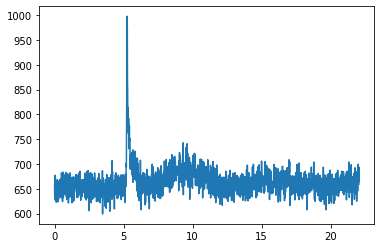

In [121]:

phi_a = (target.t0 - t[0])/target.Prot_d * 2 * np.pi-.15
theta_a = 49*np.pi/180#target.theta_a_init
a = target.ampl*1
fwhm = target.dur /target.Prot_d * 2 * np.pi/5
i_mu = target.incl
i_sigma = target.incl_err
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = 240 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R, 0, 0, np.pi/2, phi0=0)
theta_a, i_mu, phi_a, radius


In [113]:
.86/np.pi*180

49.274370381250804

(600, 1000)

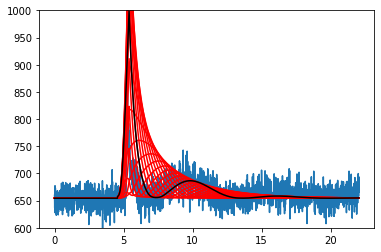

In [122]:
plt.plot(phi,flux)
for i in range(0,360,20):
    plt.plot(phi, big_model(phi_a, theta_a, a, fwhm, i_mu, phi0=i * np.pi / 180,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=1,)
plt.plot(phi, big_model(phi_a, theta_a, a, fwhm, i_mu, phi0=240 * np.pi / 180,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
plt.ylim(600,1000)

### Save inits

In [123]:
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = "date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,median\n"
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},{median}\n")
   # f.write(firstout)
    f.write(out)

## Run MCMC

In [124]:

inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 6))
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                backend=backend)

In [125]:

sampler.run_mcmc(pos, 5000, progress=True, store=True);

 10%|█         | 514/5000 [08:40<1:15:33,  1.01s/it]

prior inf


 11%|█         | 532/5000 [08:59<1:13:45,  1.01it/s]

prior inf


 11%|█         | 535/5000 [09:01<1:13:21,  1.01it/s]

prior inf


 11%|█         | 541/5000 [09:07<1:12:42,  1.02it/s]

prior inf


 11%|█         | 553/5000 [09:19<1:13:11,  1.01it/s]

prior inf


 11%|█         | 555/5000 [09:21<1:12:46,  1.02it/s]

prior inf


 11%|█         | 558/5000 [09:24<1:12:11,  1.03it/s]

prior inf


 11%|█▏        | 564/5000 [09:30<1:13:07,  1.01it/s]

prior inf


 11%|█▏        | 565/5000 [09:31<1:13:10,  1.01it/s]

prior inf
prior inf


 11%|█▏        | 569/5000 [09:35<1:12:49,  1.01it/s]

prior inf


 11%|█▏        | 572/5000 [09:38<1:12:32,  1.02it/s]

prior inf


 11%|█▏        | 573/5000 [09:39<1:11:58,  1.03it/s]

prior inf


 11%|█▏        | 574/5000 [09:40<1:14:49,  1.01s/it]

prior inf


 12%|█▏        | 575/5000 [09:41<1:15:34,  1.02s/it]

prior inf


 12%|█▏        | 577/5000 [09:43<1:17:28,  1.05s/it]

prior inf


 12%|█▏        | 581/5000 [09:47<1:15:28,  1.02s/it]

prior inf


 12%|█▏        | 582/5000 [09:48<1:14:56,  1.02s/it]

prior inf


 12%|█▏        | 583/5000 [09:49<1:15:17,  1.02s/it]

prior inf


 12%|█▏        | 586/5000 [09:52<1:16:04,  1.03s/it]

prior inf
prior inf


 12%|█▏        | 588/5000 [09:54<1:14:55,  1.02s/it]

prior inf


 12%|█▏        | 589/5000 [09:55<1:13:19,  1.00it/s]

prior inf


 12%|█▏        | 590/5000 [09:56<1:13:18,  1.00it/s]

prior inf
prior inf
prior inf


 12%|█▏        | 592/5000 [09:58<1:15:14,  1.02s/it]

prior inf


 12%|█▏        | 600/5000 [10:07<1:18:51,  1.08s/it]

prior inf


 12%|█▏        | 604/5000 [10:11<1:18:56,  1.08s/it]

prior inf


 12%|█▏        | 605/5000 [10:12<1:18:23,  1.07s/it]

prior inf


 12%|█▏        | 608/5000 [10:15<1:17:31,  1.06s/it]

prior inf


 12%|█▏        | 610/5000 [10:17<1:16:14,  1.04s/it]

prior inf


 12%|█▏        | 611/5000 [10:18<1:14:47,  1.02s/it]

prior inf


 12%|█▏        | 613/5000 [10:21<1:18:04,  1.07s/it]

prior inf


 12%|█▏        | 614/5000 [10:22<1:17:41,  1.06s/it]

prior inf


 12%|█▏        | 615/5000 [10:23<1:16:17,  1.04s/it]

prior inf


 12%|█▏        | 618/5000 [10:26<1:14:51,  1.03s/it]

prior inf


 12%|█▏        | 619/5000 [10:27<1:14:58,  1.03s/it]

prior inf


 12%|█▏        | 623/5000 [10:31<1:15:42,  1.04s/it]

prior inf


 13%|█▎        | 627/5000 [10:35<1:13:57,  1.01s/it]

prior inf


 13%|█▎        | 628/5000 [10:36<1:14:30,  1.02s/it]

prior inf


 13%|█▎        | 632/5000 [10:40<1:15:01,  1.03s/it]

prior inf


 13%|█▎        | 637/5000 [10:45<1:16:07,  1.05s/it]

prior inf


 13%|█▎        | 638/5000 [10:46<1:15:29,  1.04s/it]

prior inf
prior inf


 13%|█▎        | 639/5000 [10:47<1:14:15,  1.02s/it]

prior inf
prior inf


 13%|█▎        | 640/5000 [10:48<1:14:01,  1.02s/it]

prior inf


 13%|█▎        | 645/5000 [10:54<1:16:06,  1.05s/it]

prior inf
prior inf


 13%|█▎        | 647/5000 [10:56<1:16:03,  1.05s/it]

prior inf


 13%|█▎        | 648/5000 [10:57<1:15:38,  1.04s/it]

prior inf


 13%|█▎        | 649/5000 [10:58<1:15:46,  1.04s/it]

prior inf


 13%|█▎        | 650/5000 [10:59<1:15:08,  1.04s/it]

prior inf
prior inf


 13%|█▎        | 651/5000 [11:00<1:14:15,  1.02s/it]

prior inf


 13%|█▎        | 653/5000 [11:02<1:13:25,  1.01s/it]

prior inf


 13%|█▎        | 655/5000 [11:04<1:14:05,  1.02s/it]

prior inf


 13%|█▎        | 656/5000 [11:05<1:13:57,  1.02s/it]

prior inf


 13%|█▎        | 657/5000 [11:06<1:13:20,  1.01s/it]

prior inf


 13%|█▎        | 658/5000 [11:07<1:14:02,  1.02s/it]

prior inf
prior inf


 13%|█▎        | 659/5000 [11:08<1:12:19,  1.00it/s]

prior inf


 13%|█▎        | 660/5000 [11:09<1:13:13,  1.01s/it]

prior inf


 13%|█▎        | 661/5000 [11:10<1:13:34,  1.02s/it]

prior inf


 13%|█▎        | 662/5000 [11:11<1:14:08,  1.03s/it]

prior inf


 13%|█▎        | 663/5000 [11:12<1:11:41,  1.01it/s]

prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 664/5000 [11:13<1:13:25,  1.02s/it]

prior inf
prior inf


 13%|█▎        | 666/5000 [11:15<1:13:16,  1.01s/it]

prior inf


 13%|█▎        | 667/5000 [11:16<1:11:40,  1.01it/s]

prior inf
prior inf


 13%|█▎        | 668/5000 [11:17<1:14:19,  1.03s/it]

prior inf
prior inf


 13%|█▎        | 669/5000 [11:18<1:13:23,  1.02s/it]

prior inf
prior inf
prior inf


 13%|█▎        | 670/5000 [11:19<1:12:07,  1.00it/s]

prior inf
prior inf
prior inf


 13%|█▎        | 672/5000 [11:21<1:11:23,  1.01it/s]

prior inf
prior inf


 13%|█▎        | 673/5000 [11:22<1:10:18,  1.03it/s]

prior inf


 13%|█▎        | 674/5000 [11:23<1:11:35,  1.01it/s]

prior inf


 14%|█▎        | 676/5000 [11:25<1:15:23,  1.05s/it]

prior inf


 14%|█▎        | 678/5000 [11:27<1:17:03,  1.07s/it]

prior inf


 14%|█▎        | 679/5000 [11:28<1:15:38,  1.05s/it]

prior inf


 14%|█▎        | 680/5000 [11:29<1:14:54,  1.04s/it]

prior inf


 14%|█▎        | 682/5000 [11:32<1:16:05,  1.06s/it]

prior inf
prior inf


 14%|█▎        | 683/5000 [11:33<1:14:22,  1.03s/it]

prior inf


 14%|█▎        | 684/5000 [11:34<1:14:22,  1.03s/it]

prior inf
prior inf
prior inf


 14%|█▎        | 685/5000 [11:35<1:12:48,  1.01s/it]

prior inf


 14%|█▎        | 686/5000 [11:35<1:11:53,  1.00it/s]

prior inf
prior inf


 14%|█▎        | 687/5000 [11:36<1:10:38,  1.02it/s]

prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 688/5000 [11:37<1:10:36,  1.02it/s]

prior inf


 14%|█▍        | 689/5000 [11:38<1:11:22,  1.01it/s]

prior inf


 14%|█▍        | 690/5000 [11:39<1:10:45,  1.02it/s]

prior inf
prior inf


 14%|█▍        | 691/5000 [11:40<1:11:51,  1.00s/it]

prior inf
prior inf


 14%|█▍        | 692/5000 [11:41<1:10:32,  1.02it/s]

prior inf
prior inf


 14%|█▍        | 693/5000 [11:42<1:11:23,  1.01it/s]

prior inf


 14%|█▍        | 694/5000 [11:43<1:11:23,  1.01it/s]

prior inf


 14%|█▍        | 695/5000 [11:44<1:11:56,  1.00s/it]

prior inf


 14%|█▍        | 697/5000 [11:46<1:13:10,  1.02s/it]

prior inf
prior inf
prior inf


 14%|█▍        | 698/5000 [11:47<1:11:39,  1.00it/s]

prior inf


 14%|█▍        | 702/5000 [11:52<1:12:34,  1.01s/it]

prior inf
prior inf
prior inf


 14%|█▍        | 703/5000 [11:53<1:13:18,  1.02s/it]

prior inf


 14%|█▍        | 704/5000 [11:54<1:13:17,  1.02s/it]

prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 705/5000 [11:54<1:10:14,  1.02it/s]

prior inf


 14%|█▍        | 707/5000 [11:56<1:10:20,  1.02it/s]

prior inf


 14%|█▍        | 708/5000 [11:57<1:09:23,  1.03it/s]

prior inf
prior inf
prior inf


 14%|█▍        | 709/5000 [11:58<1:09:25,  1.03it/s]

prior inf
prior inf


 14%|█▍        | 710/5000 [11:59<1:09:30,  1.03it/s]

prior inf


 14%|█▍        | 711/5000 [12:00<1:09:58,  1.02it/s]

prior inf
prior inf
prior inf


 14%|█▍        | 712/5000 [12:01<1:08:21,  1.05it/s]

prior inf
prior inf
prior inf


 14%|█▍        | 713/5000 [12:02<1:07:32,  1.06it/s]

prior inf
prior inf


 14%|█▍        | 714/5000 [12:03<1:07:29,  1.06it/s]

prior inf
prior inf


 14%|█▍        | 715/5000 [12:04<1:07:29,  1.06it/s]

prior inf
prior inf
prior inf


 14%|█▍        | 716/5000 [12:05<1:07:00,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 717/5000 [12:06<1:06:45,  1.07it/s]

prior inf
prior inf
prior inf


 14%|█▍        | 718/5000 [12:07<1:07:46,  1.05it/s]

prior inf
prior inf


 14%|█▍        | 719/5000 [12:08<1:07:11,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 720/5000 [12:09<1:08:51,  1.04it/s]

prior inf
prior inf


 14%|█▍        | 721/5000 [12:10<1:09:48,  1.02it/s]

prior inf
prior inf


 14%|█▍        | 722/5000 [12:11<1:11:02,  1.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 723/5000 [12:12<1:09:00,  1.03it/s]

prior inf
prior inf
prior inf


 14%|█▍        | 724/5000 [12:13<1:07:48,  1.05it/s]

prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 725/5000 [12:14<1:06:58,  1.06it/s]

prior inf
prior inf


 15%|█▍        | 726/5000 [12:15<1:07:02,  1.06it/s]

prior inf
prior inf
prior inf


 15%|█▍        | 727/5000 [12:16<1:07:27,  1.06it/s]

prior inf
prior inf
prior inf


 15%|█▍        | 728/5000 [12:17<1:10:12,  1.01it/s]

prior inf


 15%|█▍        | 729/5000 [12:18<1:11:40,  1.01s/it]

prior inf
prior inf


 15%|█▍        | 730/5000 [12:19<1:11:36,  1.01s/it]

prior inf
prior inf
prior inf


 15%|█▍        | 731/5000 [12:20<1:09:37,  1.02it/s]

prior inf
prior inf


 15%|█▍        | 732/5000 [12:21<1:09:37,  1.02it/s]

prior inf
prior inf
prior inf


 15%|█▍        | 733/5000 [12:21<1:08:27,  1.04it/s]

prior inf


 15%|█▍        | 734/5000 [12:22<1:09:17,  1.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 735/5000 [12:23<1:06:54,  1.06it/s]

prior inf
prior inf


 15%|█▍        | 736/5000 [12:24<1:07:05,  1.06it/s]

prior inf


 15%|█▍        | 737/5000 [12:25<1:08:29,  1.04it/s]

prior inf


 15%|█▍        | 738/5000 [12:26<1:09:23,  1.02it/s]

prior inf


 15%|█▍        | 739/5000 [12:27<1:08:25,  1.04it/s]

prior inf
prior inf


 15%|█▍        | 740/5000 [12:28<1:07:42,  1.05it/s]

prior inf
prior inf


 15%|█▍        | 741/5000 [12:29<1:07:16,  1.06it/s]

prior inf
prior inf
prior inf


 15%|█▍        | 743/5000 [12:31<1:07:58,  1.04it/s]

prior inf


 15%|█▍        | 744/5000 [12:32<1:08:02,  1.04it/s]

prior inf
prior inf


 15%|█▍        | 745/5000 [12:33<1:08:49,  1.03it/s]

prior inf
prior inf


 15%|█▍        | 746/5000 [12:34<1:08:58,  1.03it/s]

prior inf


 15%|█▍        | 747/5000 [12:35<1:08:24,  1.04it/s]

prior inf
prior inf
prior inf


 15%|█▍        | 748/5000 [12:36<1:06:44,  1.06it/s]

prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 749/5000 [12:37<1:06:44,  1.06it/s]

prior inf
prior inf


 15%|█▌        | 750/5000 [12:38<1:06:42,  1.06it/s]

prior inf


 15%|█▌        | 751/5000 [12:39<1:06:48,  1.06it/s]

prior inf


 15%|█▌        | 752/5000 [12:40<1:07:44,  1.05it/s]

prior inf
prior inf


 15%|█▌        | 754/5000 [12:42<1:11:00,  1.00s/it]

prior inf
prior inf
prior inf


 15%|█▌        | 755/5000 [12:43<1:10:36,  1.00it/s]

prior inf
prior inf


 15%|█▌        | 756/5000 [12:44<1:10:29,  1.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 757/5000 [12:45<1:08:25,  1.03it/s]

prior inf


 15%|█▌        | 758/5000 [12:46<1:08:44,  1.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 759/5000 [12:46<1:07:10,  1.05it/s]

prior inf
prior inf


 15%|█▌        | 760/5000 [12:47<1:07:05,  1.05it/s]

prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 761/5000 [12:48<1:06:18,  1.07it/s]

prior inf
prior inf


 15%|█▌        | 762/5000 [12:49<1:07:30,  1.05it/s]

prior inf
prior inf


 15%|█▌        | 763/5000 [12:50<1:08:17,  1.03it/s]

prior inf
prior inf
prior inf


 15%|█▌        | 764/5000 [12:51<1:06:55,  1.05it/s]

prior inf


 15%|█▌        | 765/5000 [12:52<1:08:11,  1.04it/s]

prior inf


 15%|█▌        | 766/5000 [12:53<1:08:44,  1.03it/s]

prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 767/5000 [12:54<1:08:07,  1.04it/s]

prior inf


 15%|█▌        | 769/5000 [12:56<1:09:14,  1.02it/s]

prior inf
prior inf
prior inf


 15%|█▌        | 770/5000 [12:57<1:10:02,  1.01it/s]

prior inf
prior inf


 15%|█▌        | 771/5000 [12:58<1:11:04,  1.01s/it]

prior inf


 15%|█▌        | 772/5000 [12:59<1:10:48,  1.00s/it]

prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 773/5000 [13:00<1:08:46,  1.02it/s]

prior inf
prior inf


 15%|█▌        | 774/5000 [13:01<1:08:28,  1.03it/s]

prior inf


 16%|█▌        | 775/5000 [13:02<1:09:41,  1.01it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 776/5000 [13:03<1:08:53,  1.02it/s]

prior inf


 16%|█▌        | 778/5000 [13:05<1:09:32,  1.01it/s]

prior inf
prior inf


 16%|█▌        | 779/5000 [13:06<1:10:03,  1.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 780/5000 [13:07<1:10:27,  1.00s/it]

prior inf


 16%|█▌        | 781/5000 [13:08<1:09:00,  1.02it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 782/5000 [13:09<1:06:18,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 783/5000 [13:10<1:06:43,  1.05it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 784/5000 [13:11<1:05:18,  1.08it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 785/5000 [13:12<1:05:52,  1.07it/s]

prior inf


 16%|█▌        | 786/5000 [13:13<1:07:00,  1.05it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 787/5000 [13:14<1:05:29,  1.07it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 788/5000 [13:15<1:07:33,  1.04it/s]

prior inf


 16%|█▌        | 789/5000 [13:16<1:12:41,  1.04s/it]

prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 790/5000 [13:17<1:10:19,  1.00s/it]

prior inf
prior inf


 16%|█▌        | 791/5000 [13:18<1:10:19,  1.00s/it]

prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 792/5000 [13:19<1:10:00,  1.00it/s]

prior inf


 16%|█▌        | 793/5000 [13:20<1:11:29,  1.02s/it]

prior inf
prior inf
prior inf


 16%|█▌        | 794/5000 [13:21<1:09:00,  1.02it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 795/5000 [13:22<1:07:03,  1.05it/s]

prior inf


 16%|█▌        | 796/5000 [13:23<1:07:06,  1.04it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 797/5000 [13:23<1:05:02,  1.08it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 798/5000 [13:24<1:06:31,  1.05it/s]

prior inf


 16%|█▌        | 799/5000 [13:25<1:06:13,  1.06it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 800/5000 [13:26<1:05:55,  1.06it/s]

prior inf


 16%|█▌        | 802/5000 [13:28<1:06:08,  1.06it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 803/5000 [13:29<1:05:28,  1.07it/s]

prior inf
prior inf


 16%|█▌        | 804/5000 [13:30<1:06:00,  1.06it/s]

prior inf
prior inf


 16%|█▌        | 805/5000 [13:31<1:06:21,  1.05it/s]

prior inf


 16%|█▌        | 806/5000 [13:32<1:06:32,  1.05it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 807/5000 [13:33<1:05:38,  1.06it/s]

prior inf


 16%|█▌        | 808/5000 [13:34<1:06:57,  1.04it/s]

prior inf


 16%|█▌        | 809/5000 [13:35<1:06:41,  1.05it/s]

prior inf
prior inf


 16%|█▌        | 810/5000 [13:36<1:07:32,  1.03it/s]

prior inf


 16%|█▌        | 811/5000 [13:37<1:07:25,  1.04it/s]

prior inf
prior inf


 16%|█▌        | 812/5000 [13:38<1:06:57,  1.04it/s]

prior inf
prior inf
prior inf


 16%|█▋        | 815/5000 [13:41<1:06:50,  1.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▋        | 816/5000 [13:41<1:04:32,  1.08it/s]

prior inf
prior inf


 16%|█▋        | 817/5000 [13:42<1:05:14,  1.07it/s]

prior inf
prior inf


 16%|█▋        | 818/5000 [13:43<1:03:49,  1.09it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▋        | 820/5000 [13:45<1:06:29,  1.05it/s]

prior inf


 16%|█▋        | 821/5000 [13:46<1:06:20,  1.05it/s]

prior inf
prior inf


 16%|█▋        | 822/5000 [13:47<1:07:33,  1.03it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▋        | 823/5000 [13:48<1:07:16,  1.03it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▋        | 824/5000 [13:49<1:09:14,  1.01it/s]

prior inf


 16%|█▋        | 825/5000 [13:50<1:08:15,  1.02it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 827/5000 [13:52<1:10:27,  1.01s/it]

prior inf
prior inf
prior inf


 17%|█▋        | 828/5000 [13:53<1:09:02,  1.01it/s]

prior inf


 17%|█▋        | 829/5000 [13:54<1:08:27,  1.02it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 830/5000 [13:55<1:07:17,  1.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 832/5000 [13:57<1:05:26,  1.06it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 833/5000 [13:58<1:07:27,  1.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 834/5000 [13:59<1:06:08,  1.05it/s]

prior inf


 17%|█▋        | 835/5000 [14:00<1:06:12,  1.05it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 836/5000 [14:01<1:06:54,  1.04it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 837/5000 [14:02<1:06:40,  1.04it/s]

prior inf


 17%|█▋        | 838/5000 [14:03<1:06:02,  1.05it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 839/5000 [14:04<1:06:23,  1.04it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 840/5000 [14:05<1:04:46,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 841/5000 [14:05<1:02:44,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 842/5000 [14:06<1:01:30,  1.13it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 843/5000 [14:07<1:02:53,  1.10it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 844/5000 [14:08<1:04:29,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 845/5000 [14:09<1:03:32,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 846/5000 [14:10<1:03:23,  1.09it/s]

prior inf
prior inf


 17%|█▋        | 847/5000 [14:11<1:05:16,  1.06it/s]

prior inf
prior inf


 17%|█▋        | 848/5000 [14:12<1:06:32,  1.04it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 849/5000 [14:13<1:06:10,  1.05it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 850/5000 [14:14<1:06:34,  1.04it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 851/5000 [14:15<1:05:35,  1.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 852/5000 [14:16<1:05:50,  1.05it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 853/5000 [14:17<1:04:28,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 854/5000 [14:18<1:03:05,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 855/5000 [14:18<1:03:02,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 856/5000 [14:19<1:03:16,  1.09it/s]

prior inf
prior inf


 17%|█▋        | 857/5000 [14:20<1:03:54,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 858/5000 [14:21<1:03:46,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 859/5000 [14:22<1:02:42,  1.10it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 860/5000 [14:23<1:04:06,  1.08it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 861/5000 [14:24<1:05:06,  1.06it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 862/5000 [14:25<1:04:50,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 863/5000 [14:26<1:04:00,  1.08it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 864/5000 [14:27<1:02:35,  1.10it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 865/5000 [14:28<1:04:09,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 866/5000 [14:29<1:03:28,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 867/5000 [14:30<1:02:24,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 868/5000 [14:30<1:00:59,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 869/5000 [14:31<1:01:32,  1.12it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 870/5000 [14:32<1:02:39,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 871/5000 [14:33<1:02:07,  1.11it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 872/5000 [14:34<1:03:19,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 873/5000 [14:35<1:00:58,  1.13it/s]

prior inf
prior inf


 17%|█▋        | 874/5000 [14:36<1:02:47,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 875/5000 [14:37<1:00:56,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 876/5000 [14:38<59:51,  1.15it/s]  

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 877/5000 [14:38<1:00:03,  1.14it/s]

prior inf
prior inf
prior inf


 18%|█▊        | 878/5000 [14:39<1:00:42,  1.13it/s]

prior inf


 18%|█▊        | 879/5000 [14:40<1:02:26,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 880/5000 [14:41<1:00:42,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 881/5000 [14:42<59:20,  1.16it/s]  

prior inf
prior inf


 18%|█▊        | 882/5000 [14:43<1:01:27,  1.12it/s]

prior inf
prior inf
prior inf


 18%|█▊        | 883/5000 [14:44<1:01:50,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 884/5000 [14:45<58:52,  1.17it/s]  

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 885/5000 [14:45<58:34,  1.17it/s]

prior inf
prior inf
prior inf


 18%|█▊        | 886/5000 [14:46<59:43,  1.15it/s]

prior inf


 18%|█▊        | 887/5000 [14:47<1:00:57,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 888/5000 [14:48<59:28,  1.15it/s]  

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 889/5000 [14:49<56:43,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 890/5000 [14:50<56:24,  1.21it/s]

prior inf
prior inf
prior inf


 18%|█▊        | 891/5000 [14:51<58:50,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 892/5000 [14:51<58:31,  1.17it/s]

prior inf
prior inf
prior inf


 18%|█▊        | 893/5000 [14:52<1:00:54,  1.12it/s]

prior inf
prior inf


 18%|█▊        | 894/5000 [14:53<1:00:04,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 895/5000 [14:54<1:02:01,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 896/5000 [14:55<58:04,  1.18it/s]  

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 897/5000 [14:56<56:49,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 898/5000 [14:57<56:12,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 899/5000 [14:57<56:53,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 900/5000 [14:58<57:58,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 901/5000 [14:59<57:20,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 902/5000 [15:00<58:37,  1.17it/s]

prior inf
prior inf
prior inf


 18%|█▊        | 903/5000 [15:01<59:18,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 904/5000 [15:02<57:43,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 905/5000 [15:03<57:37,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 906/5000 [15:03<59:01,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 907/5000 [15:04<59:48,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 908/5000 [15:05<58:22,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 909/5000 [15:06<59:16,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 910/5000 [15:07<59:27,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 911/5000 [15:08<57:57,  1.18it/s]

prior inf
prior inf


 18%|█▊        | 912/5000 [15:09<1:00:17,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 913/5000 [15:10<58:48,  1.16it/s]  

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 914/5000 [15:10<58:19,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 915/5000 [15:11<57:46,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 916/5000 [15:12<55:55,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 917/5000 [15:13<57:23,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 918/5000 [15:14<58:49,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 919/5000 [15:15<58:50,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 920/5000 [15:16<1:00:26,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 921/5000 [15:16<1:00:09,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 922/5000 [15:17<59:23,  1.14it/s]  

prior inf


 18%|█▊        | 923/5000 [15:18<1:00:21,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 924/5000 [15:19<59:35,  1.14it/s]  

prior inf
prior inf
prior inf


 18%|█▊        | 925/5000 [15:20<1:00:25,  1.12it/s]

prior inf
prior inf


 19%|█▊        | 926/5000 [15:21<1:01:29,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 927/5000 [15:22<1:02:37,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 928/5000 [15:23<59:22,  1.14it/s]  

prior inf
prior inf
prior inf


 19%|█▊        | 929/5000 [15:24<59:31,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 930/5000 [15:24<59:41,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 931/5000 [15:25<57:17,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 932/5000 [15:26<55:48,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 933/5000 [15:27<55:11,  1.23it/s]

prior inf
prior inf
prior inf


 19%|█▊        | 934/5000 [15:28<59:05,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 935/5000 [15:29<59:08,  1.15it/s]

prior inf
prior inf
prior inf


 19%|█▊        | 936/5000 [15:30<1:00:28,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 937/5000 [15:30<58:47,  1.15it/s]  

prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 938/5000 [15:31<56:28,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 939/5000 [15:32<55:46,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 940/5000 [15:33<56:59,  1.19it/s]

prior inf
prior inf
prior inf


 19%|█▉        | 941/5000 [15:34<59:31,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 942/5000 [15:34<56:01,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 944/5000 [15:36<1:00:06,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 945/5000 [15:37<1:00:46,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 946/5000 [15:38<1:00:06,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 947/5000 [15:39<59:01,  1.14it/s]  

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 948/5000 [15:40<56:47,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 949/5000 [15:41<58:07,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 950/5000 [15:41<55:56,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 951/5000 [15:42<58:14,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 952/5000 [15:43<59:18,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 953/5000 [15:44<59:03,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 954/5000 [15:45<58:25,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 955/5000 [15:46<56:09,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 956/5000 [15:47<56:14,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 957/5000 [15:47<55:57,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 958/5000 [15:48<56:22,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 959/5000 [15:49<56:24,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 960/5000 [15:50<54:40,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 961/5000 [15:51<53:37,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 962/5000 [15:51<52:10,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 963/5000 [15:52<51:14,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 964/5000 [15:53<52:14,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 965/5000 [15:54<52:25,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 966/5000 [15:54<52:08,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 967/5000 [15:55<52:49,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 968/5000 [15:56<51:00,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 969/5000 [15:57<49:39,  1.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 970/5000 [15:57<51:32,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 971/5000 [15:58<52:50,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 972/5000 [15:59<54:22,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 973/5000 [16:00<56:36,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 974/5000 [16:01<56:28,  1.19it/s]

prior inf


 20%|█▉        | 975/5000 [16:02<57:33,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 976/5000 [16:03<55:38,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 977/5000 [16:03<57:09,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 978/5000 [16:04<57:36,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 979/5000 [16:05<56:32,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 980/5000 [16:06<55:57,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 981/5000 [16:07<56:25,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 982/5000 [16:08<57:12,  1.17it/s]

prior inf
prior inf
prior inf


 20%|█▉        | 983/5000 [16:09<57:03,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 984/5000 [16:09<55:49,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 985/5000 [16:10<54:56,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 986/5000 [16:11<54:58,  1.22it/s]

prior inf
prior inf
prior inf


 20%|█▉        | 987/5000 [16:12<55:12,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 988/5000 [16:13<54:49,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 989/5000 [16:13<53:02,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 990/5000 [16:14<53:34,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 991/5000 [16:15<52:20,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 992/5000 [16:16<53:27,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 993/5000 [16:17<53:54,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 994/5000 [16:17<51:15,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 995/5000 [16:18<50:35,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 996/5000 [16:19<53:49,  1.24it/s]

prior inf
prior inf
prior inf


 20%|█▉        | 997/5000 [16:20<55:37,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 998/5000 [16:21<55:44,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 999/5000 [16:22<57:34,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1000/5000 [16:22<55:37,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1001/5000 [16:23<54:56,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1002/5000 [16:24<55:40,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1003/5000 [16:25<56:28,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1004/5000 [16:26<55:42,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 20%|██        | 1005/5000 [16:27<55:41,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1006/5000 [16:27<57:38,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1007/5000 [16:28<56:03,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 20%|██        | 1008/5000 [16:29<56:35,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1009/5000 [16:30<54:39,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1010/5000 [16:31<57:16,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 20%|██        | 1011/5000 [16:32<57:36,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1012/5000 [16:32<55:43,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1013/5000 [16:33<56:46,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1014/5000 [16:34<53:47,  1.23it/s]

prior inf
prior inf


 20%|██        | 1015/5000 [16:35<55:16,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 20%|██        | 1016/5000 [16:36<55:38,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1017/5000 [16:37<56:22,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1018/5000 [16:37<54:29,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1019/5000 [16:38<52:07,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1020/5000 [16:39<53:53,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1021/5000 [16:40<54:33,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 20%|██        | 1022/5000 [16:41<54:59,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1023/5000 [16:42<55:03,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1024/5000 [16:42<52:37,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1025/5000 [16:43<54:51,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 21%|██        | 1026/5000 [16:44<54:08,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1027/5000 [16:45<54:31,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1028/5000 [16:46<55:22,  1.20it/s]

prior inf
prior inf
prior inf


 21%|██        | 1029/5000 [16:47<57:02,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1030/5000 [16:48<58:12,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 21%|██        | 1031/5000 [16:48<58:26,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1032/5000 [16:49<57:42,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1033/5000 [16:50<56:58,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1034/5000 [16:51<57:31,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1035/5000 [16:52<57:14,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1036/5000 [16:53<57:03,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 21%|██        | 1037/5000 [16:54<58:44,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1038/5000 [16:54<57:28,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1039/5000 [16:55<53:21,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1040/5000 [16:56<53:22,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1041/5000 [16:57<53:46,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1042/5000 [16:58<54:11,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1043/5000 [16:58<54:46,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1044/5000 [16:59<52:42,  1.25it/s]

prior inf
prior inf


 21%|██        | 1045/5000 [17:00<54:58,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1046/5000 [17:01<55:27,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1047/5000 [17:02<54:24,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1048/5000 [17:03<54:13,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1049/5000 [17:03<52:57,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1050/5000 [17:04<53:15,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 21%|██        | 1051/5000 [17:05<53:19,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1052/5000 [17:06<51:40,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1053/5000 [17:06<51:50,  1.27it/s]

prior inf
prior inf
prior inf


 21%|██        | 1054/5000 [17:07<54:18,  1.21it/s]

prior inf
prior inf


 21%|██        | 1055/5000 [17:08<56:00,  1.17it/s]

prior inf
prior inf
prior inf


 21%|██        | 1056/5000 [17:09<56:28,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1057/5000 [17:10<57:28,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1058/5000 [17:11<56:58,  1.15it/s]

prior inf
prior inf


 21%|██        | 1059/5000 [17:12<58:20,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1060/5000 [17:13<57:02,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1061/5000 [17:13<54:48,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 21%|██        | 1062/5000 [17:14<55:33,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1063/5000 [17:15<56:15,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1064/5000 [17:16<55:32,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1065/5000 [17:17<55:29,  1.18it/s]

prior inf
prior inf
prior inf


 21%|██▏       | 1066/5000 [17:18<55:12,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1067/5000 [17:19<55:33,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1068/5000 [17:19<56:14,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1069/5000 [17:20<55:27,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1070/5000 [17:21<53:05,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1071/5000 [17:22<53:48,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1072/5000 [17:23<54:24,  1.20it/s]

prior inf
prior inf
prior inf


 21%|██▏       | 1073/5000 [17:24<56:02,  1.17it/s]

prior inf
prior inf


 21%|██▏       | 1074/5000 [17:25<57:14,  1.14it/s]

prior inf
prior inf


 22%|██▏       | 1075/5000 [17:25<56:41,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1076/5000 [17:26<55:43,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1077/5000 [17:27<52:33,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1078/5000 [17:28<50:22,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1079/5000 [17:28<51:15,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1080/5000 [17:29<50:15,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1081/5000 [17:30<50:28,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1082/5000 [17:31<49:49,  1.31it/s]

prior inf


 22%|██▏       | 1083/5000 [17:32<53:16,  1.23it/s]

prior inf
prior inf
prior inf


 22%|██▏       | 1084/5000 [17:33<55:39,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1085/5000 [17:33<53:50,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1086/5000 [17:34<54:12,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1087/5000 [17:35<54:29,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1088/5000 [17:36<54:09,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1089/5000 [17:37<54:29,  1.20it/s]

prior inf
prior inf


 22%|██▏       | 1090/5000 [17:38<58:26,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1091/5000 [17:38<56:37,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1092/5000 [17:39<55:18,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1093/5000 [17:40<57:01,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1094/5000 [17:41<58:00,  1.12it/s]

prior inf
prior inf
prior inf


 22%|██▏       | 1095/5000 [17:42<1:00:02,  1.08it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1096/5000 [17:43<59:15,  1.10it/s]  

prior inf
prior inf
prior inf


 22%|██▏       | 1097/5000 [17:44<59:02,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1098/5000 [17:45<57:10,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1099/5000 [17:46<57:26,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1100/5000 [17:46<55:47,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1101/5000 [17:47<54:04,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1102/5000 [17:48<53:27,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1103/5000 [17:49<52:35,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1104/5000 [17:50<53:55,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1105/5000 [17:50<53:08,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1106/5000 [17:51<52:37,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1107/5000 [17:52<52:39,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1108/5000 [17:53<52:41,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1109/5000 [17:54<53:41,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1110/5000 [17:55<54:07,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1111/5000 [17:55<53:29,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1112/5000 [17:56<54:30,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1113/5000 [17:57<53:45,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1114/5000 [17:58<55:34,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1115/5000 [17:59<55:37,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1116/5000 [18:00<55:30,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1117/5000 [18:01<54:22,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1118/5000 [18:01<55:15,  1.17it/s]

prior inf
prior inf
prior inf


 22%|██▏       | 1119/5000 [18:02<55:31,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1120/5000 [18:03<56:22,  1.15it/s]

prior inf
prior inf
prior inf


 22%|██▏       | 1121/5000 [18:04<56:48,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1122/5000 [18:05<57:00,  1.13it/s]

prior inf
prior inf


 22%|██▏       | 1123/5000 [18:06<57:30,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1124/5000 [18:07<56:55,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▎       | 1125/5000 [18:07<54:03,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1126/5000 [18:08<53:44,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1127/5000 [18:09<52:21,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1128/5000 [18:10<53:09,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1129/5000 [18:11<52:20,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1130/5000 [18:12<54:52,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1131/5000 [18:13<56:37,  1.14it/s]

prior inf
prior inf
prior inf


 23%|██▎       | 1132/5000 [18:14<57:45,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1133/5000 [18:14<53:54,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1134/5000 [18:15<54:49,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1135/5000 [18:16<55:36,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1136/5000 [18:17<54:52,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1137/5000 [18:18<53:57,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1138/5000 [18:18<54:12,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1139/5000 [18:19<54:53,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1140/5000 [18:20<53:44,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1141/5000 [18:21<54:48,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1142/5000 [18:22<53:04,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1143/5000 [18:23<55:30,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1144/5000 [18:24<56:10,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1145/5000 [18:24<55:06,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1146/5000 [18:25<53:29,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1147/5000 [18:26<54:37,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1148/5000 [18:27<53:18,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1149/5000 [18:28<54:37,  1.17it/s]

prior inf
prior inf
prior inf


 23%|██▎       | 1150/5000 [18:29<57:22,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1151/5000 [18:30<56:26,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1152/5000 [18:31<56:10,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1153/5000 [18:31<54:18,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1154/5000 [18:32<58:07,  1.10it/s]

prior inf
prior inf


 23%|██▎       | 1155/5000 [18:33<1:00:28,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1156/5000 [18:34<59:05,  1.08it/s]  

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1157/5000 [18:35<58:50,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1158/5000 [18:36<55:43,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1159/5000 [18:37<55:33,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1160/5000 [18:38<56:24,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1161/5000 [18:39<57:04,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1162/5000 [18:39<56:47,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1163/5000 [18:40<58:55,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1164/5000 [18:41<58:17,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1165/5000 [18:42<56:27,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1166/5000 [18:43<55:18,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1167/5000 [18:44<55:35,  1.15it/s]

prior inf
prior inf
prior inf


 23%|██▎       | 1168/5000 [18:45<59:03,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1169/5000 [18:46<58:58,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1170/5000 [18:47<57:30,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1171/5000 [18:48<57:04,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1172/5000 [18:49<58:23,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1173/5000 [18:49<57:44,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1174/5000 [18:50<58:49,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1175/5000 [18:51<57:39,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1176/5000 [18:52<58:44,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1177/5000 [18:53<1:00:06,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1178/5000 [18:54<58:40,  1.09it/s]  

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1179/5000 [18:55<59:31,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1180/5000 [18:56<58:04,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1181/5000 [18:57<54:11,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1182/5000 [18:58<56:02,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1183/5000 [18:58<56:12,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1184/5000 [18:59<57:01,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1185/5000 [19:00<57:22,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1186/5000 [19:01<55:56,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1187/5000 [19:02<56:40,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1188/5000 [19:03<57:21,  1.11it/s]

prior inf
prior inf
prior inf


 24%|██▍       | 1189/5000 [19:04<59:05,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1190/5000 [19:05<58:02,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1191/5000 [19:06<59:03,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1192/5000 [19:07<59:19,  1.07it/s]

prior inf
prior inf
prior inf


 24%|██▍       | 1193/5000 [19:08<59:16,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1194/5000 [19:08<56:16,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1195/5000 [19:09<55:30,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1196/5000 [19:10<55:38,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1197/5000 [19:11<55:01,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1198/5000 [19:12<53:31,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1199/5000 [19:13<52:29,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1200/5000 [19:13<52:16,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1201/5000 [19:14<51:57,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1202/5000 [19:15<50:03,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1203/5000 [19:16<49:55,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1204/5000 [19:17<49:50,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1205/5000 [19:17<52:05,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1206/5000 [19:18<50:32,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1207/5000 [19:19<52:44,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1208/5000 [19:20<53:17,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1209/5000 [19:21<54:01,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1210/5000 [19:22<52:44,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1211/5000 [19:22<52:36,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1212/5000 [19:23<53:02,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1213/5000 [19:24<50:46,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1214/5000 [19:25<52:04,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1215/5000 [19:26<49:53,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1216/5000 [19:26<49:48,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1217/5000 [19:27<49:44,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1218/5000 [19:28<49:40,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1219/5000 [19:29<51:34,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1220/5000 [19:30<55:38,  1.13it/s]

prior inf
prior inf
prior inf


 24%|██▍       | 1221/5000 [19:31<56:44,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1222/5000 [19:32<52:55,  1.19it/s]

prior inf
prior inf
prior inf


 24%|██▍       | 1223/5000 [19:33<55:24,  1.14it/s]

prior inf


 24%|██▍       | 1224/5000 [19:33<56:14,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1225/5000 [19:34<58:14,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1226/5000 [19:35<53:09,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1227/5000 [19:36<54:53,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1228/5000 [19:37<54:31,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1229/5000 [19:38<54:30,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1230/5000 [19:39<55:54,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1231/5000 [19:40<53:59,  1.16it/s]

prior inf


 25%|██▍       | 1232/5000 [19:40<54:15,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1233/5000 [19:41<52:42,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1234/5000 [19:42<52:30,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1235/5000 [19:43<53:55,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1236/5000 [19:44<54:49,  1.14it/s]

prior inf
prior inf
prior inf


 25%|██▍       | 1237/5000 [19:45<54:37,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1238/5000 [19:46<57:25,  1.09it/s]

prior inf


 25%|██▍       | 1239/5000 [19:47<1:01:55,  1.01it/s]

prior inf
prior inf
prior inf


 25%|██▍       | 1240/5000 [19:48<1:01:48,  1.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1241/5000 [19:49<58:57,  1.06it/s]  

prior inf
prior inf


 25%|██▍       | 1242/5000 [19:50<1:00:04,  1.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1243/5000 [19:50<57:07,  1.10it/s]  

prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1244/5000 [19:51<57:02,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1245/5000 [19:52<54:57,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1246/5000 [19:53<52:45,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1247/5000 [19:54<53:45,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1248/5000 [19:55<54:46,  1.14it/s]

prior inf
prior inf


 25%|██▍       | 1249/5000 [19:56<55:37,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1250/5000 [19:57<54:26,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1251/5000 [19:57<53:24,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1252/5000 [19:58<54:27,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1253/5000 [19:59<49:23,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1254/5000 [20:00<49:48,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1255/5000 [20:00<50:07,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1256/5000 [20:01<50:35,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1257/5000 [20:02<51:27,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1258/5000 [20:03<50:44,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1259/5000 [20:04<51:46,  1.20it/s]

prior inf
prior inf
prior inf


 25%|██▌       | 1260/5000 [20:05<52:05,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1261/5000 [20:06<52:15,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1262/5000 [20:06<51:15,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1263/5000 [20:07<51:12,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1264/5000 [20:08<51:07,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1265/5000 [20:09<52:41,  1.18it/s]

prior inf
prior inf


 25%|██▌       | 1266/5000 [20:10<53:39,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1267/5000 [20:11<53:48,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1268/5000 [20:11<53:25,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1269/5000 [20:12<53:57,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1270/5000 [20:13<52:41,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1271/5000 [20:14<52:56,  1.17it/s]

prior inf
prior inf
prior inf


 25%|██▌       | 1272/5000 [20:15<51:36,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1273/5000 [20:16<51:26,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1274/5000 [20:17<52:25,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1275/5000 [20:17<52:13,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1276/5000 [20:18<49:38,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1277/5000 [20:19<50:00,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1278/5000 [20:20<50:31,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1279/5000 [20:21<50:23,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1280/5000 [20:21<51:31,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1281/5000 [20:22<51:54,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1282/5000 [20:23<51:22,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1283/5000 [20:24<51:11,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1284/5000 [20:25<50:07,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1285/5000 [20:25<50:14,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1286/5000 [20:26<50:15,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1287/5000 [20:27<50:17,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1288/5000 [20:28<49:43,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1289/5000 [20:29<49:06,  1.26it/s]

prior inf


 26%|██▌       | 1290/5000 [20:30<52:57,  1.17it/s]

prior inf
prior inf
prior inf


 26%|██▌       | 1291/5000 [20:31<55:12,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1292/5000 [20:32<56:47,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1293/5000 [20:32<55:20,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1294/5000 [20:33<55:48,  1.11it/s]

prior inf
prior inf
prior inf


 26%|██▌       | 1295/5000 [20:34<56:02,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1296/5000 [20:35<56:06,  1.10it/s]

prior inf
prior inf
prior inf


 26%|██▌       | 1297/5000 [20:36<56:18,  1.10it/s]

prior inf
prior inf
prior inf


 26%|██▌       | 1298/5000 [20:37<53:54,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1299/5000 [20:38<53:02,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1300/5000 [20:39<53:25,  1.15it/s]

prior inf
prior inf
prior inf


 26%|██▌       | 1301/5000 [20:39<53:33,  1.15it/s]

prior inf
prior inf


 26%|██▌       | 1302/5000 [20:40<53:35,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1303/5000 [20:41<52:36,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1304/5000 [20:42<52:24,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1305/5000 [20:43<49:32,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1306/5000 [20:44<50:30,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1307/5000 [20:44<48:28,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1308/5000 [20:45<49:50,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1309/5000 [20:46<49:45,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1310/5000 [20:47<50:59,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1311/5000 [20:48<50:42,  1.21it/s]

prior inf


 26%|██▌       | 1312/5000 [20:49<53:34,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1313/5000 [20:49<52:04,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1314/5000 [20:50<51:29,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1315/5000 [20:51<50:25,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1316/5000 [20:52<49:54,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1317/5000 [20:53<51:15,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1318/5000 [20:53<49:49,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1319/5000 [20:54<49:26,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1320/5000 [20:55<49:02,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1321/5000 [20:56<50:40,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1322/5000 [20:57<50:52,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1323/5000 [20:58<50:51,  1.20it/s]

prior inf
prior inf
prior inf


 26%|██▋       | 1324/5000 [20:58<51:52,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1325/5000 [20:59<52:31,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1326/5000 [21:00<51:43,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1327/5000 [21:01<50:06,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1328/5000 [21:02<48:55,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1329/5000 [21:02<49:05,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1330/5000 [21:03<50:04,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1331/5000 [21:04<50:34,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1332/5000 [21:05<50:06,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1333/5000 [21:06<50:18,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1334/5000 [21:07<48:47,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1335/5000 [21:07<49:46,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1336/5000 [21:08<48:27,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1337/5000 [21:09<49:42,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1338/5000 [21:10<50:35,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1339/5000 [21:11<48:53,  1.25it/s]

prior inf
prior inf
prior inf


 27%|██▋       | 1340/5000 [21:11<49:50,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1341/5000 [21:12<51:13,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1342/5000 [21:13<51:27,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1343/5000 [21:14<52:23,  1.16it/s]

prior inf
prior inf


 27%|██▋       | 1344/5000 [21:15<54:39,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1345/5000 [21:16<54:04,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1346/5000 [21:17<54:36,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1347/5000 [21:18<54:33,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1348/5000 [21:18<51:02,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1349/5000 [21:19<51:46,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1350/5000 [21:20<53:14,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1351/5000 [21:21<52:47,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1352/5000 [21:22<52:57,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1353/5000 [21:23<52:14,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1354/5000 [21:24<51:56,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1355/5000 [21:25<51:48,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1356/5000 [21:25<51:05,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1357/5000 [21:26<51:43,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1358/5000 [21:27<51:00,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1359/5000 [21:28<52:36,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1360/5000 [21:29<52:17,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1361/5000 [21:30<51:30,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1362/5000 [21:30<51:08,  1.19it/s]

prior inf
prior inf


 27%|██▋       | 1363/5000 [21:31<51:28,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1364/5000 [21:32<47:35,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1365/5000 [21:33<50:28,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1366/5000 [21:34<50:50,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1367/5000 [21:35<52:21,  1.16it/s]

prior inf
prior inf
prior inf


 27%|██▋       | 1368/5000 [21:36<52:16,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1369/5000 [21:36<52:42,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1370/5000 [21:37<52:22,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1371/5000 [21:38<53:35,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1372/5000 [21:39<50:46,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1373/5000 [21:40<51:27,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1374/5000 [21:41<50:52,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1375/5000 [21:41<48:44,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1376/5000 [21:42<49:25,  1.22it/s]

prior inf
prior inf
prior inf


 28%|██▊       | 1377/5000 [21:43<52:30,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1378/5000 [21:44<51:58,  1.16it/s]

prior inf
prior inf
prior inf


 28%|██▊       | 1379/5000 [21:45<51:45,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1380/5000 [21:46<52:04,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1381/5000 [21:47<51:25,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1382/5000 [21:47<51:21,  1.17it/s]

prior inf
prior inf


 28%|██▊       | 1383/5000 [21:48<52:32,  1.15it/s]

prior inf
prior inf


 28%|██▊       | 1384/5000 [21:49<53:41,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1385/5000 [21:50<51:11,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1386/5000 [21:51<50:03,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1387/5000 [21:52<49:48,  1.21it/s]

prior inf
prior inf


 28%|██▊       | 1388/5000 [21:53<51:35,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1389/5000 [21:53<51:47,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1390/5000 [21:54<51:17,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1391/5000 [21:55<50:45,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1392/5000 [21:56<49:43,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1393/5000 [21:57<51:31,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1394/5000 [21:58<50:54,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1395/5000 [21:59<51:45,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1396/5000 [21:59<51:33,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1397/5000 [22:00<49:13,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1398/5000 [22:01<50:35,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1399/5000 [22:02<47:59,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1400/5000 [22:03<49:56,  1.20it/s]

prior inf
prior inf
prior inf


 28%|██▊       | 1401/5000 [22:04<50:13,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1402/5000 [22:04<50:13,  1.19it/s]

prior inf
prior inf
prior inf


 28%|██▊       | 1403/5000 [22:05<50:55,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1404/5000 [22:06<50:58,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1405/5000 [22:07<49:11,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1406/5000 [22:08<49:41,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1407/5000 [22:08<48:55,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1408/5000 [22:09<49:59,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1409/5000 [22:10<49:34,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1410/5000 [22:11<49:27,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1411/5000 [22:12<49:25,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1412/5000 [22:13<50:58,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1413/5000 [22:14<50:24,  1.19it/s]

prior inf
prior inf
prior inf


 28%|██▊       | 1414/5000 [22:15<53:10,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1415/5000 [22:15<53:31,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1416/5000 [22:16<51:03,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1417/5000 [22:17<50:32,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1418/5000 [22:18<49:07,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1419/5000 [22:19<49:00,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1420/5000 [22:20<50:17,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1421/5000 [22:20<49:04,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1422/5000 [22:21<50:02,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1423/5000 [22:22<50:09,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1424/5000 [22:23<48:03,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1425/5000 [22:24<48:52,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1426/5000 [22:24<47:43,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1427/5000 [22:25<47:29,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1428/5000 [22:26<47:25,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1429/5000 [22:27<48:25,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1430/5000 [22:28<49:33,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1431/5000 [22:28<49:29,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1432/5000 [22:29<49:33,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1433/5000 [22:30<50:41,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1434/5000 [22:31<48:32,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1435/5000 [22:32<48:41,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1436/5000 [22:33<47:57,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1437/5000 [22:33<48:49,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1438/5000 [22:34<47:55,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1439/5000 [22:35<50:31,  1.17it/s]

prior inf
prior inf
prior inf


 29%|██▉       | 1440/5000 [22:36<51:48,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1441/5000 [22:37<53:45,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1442/5000 [22:38<52:38,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1443/5000 [22:39<52:27,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1444/5000 [22:40<51:10,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1445/5000 [22:41<52:43,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1446/5000 [22:41<51:40,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1447/5000 [22:42<51:02,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1448/5000 [22:43<53:06,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1449/5000 [22:44<53:53,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1450/5000 [22:45<51:28,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1451/5000 [22:46<50:49,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1452/5000 [22:47<51:29,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1453/5000 [22:47<51:14,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1454/5000 [22:48<50:00,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1455/5000 [22:49<49:30,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1456/5000 [22:50<50:48,  1.16it/s]

prior inf
prior inf
prior inf


 29%|██▉       | 1457/5000 [22:51<51:46,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1458/5000 [22:52<51:59,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1459/5000 [22:53<52:08,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1460/5000 [22:54<51:03,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1461/5000 [22:54<49:29,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1462/5000 [22:55<50:40,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1463/5000 [22:56<50:59,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1464/5000 [22:57<51:34,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1465/5000 [22:58<52:30,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1466/5000 [22:59<51:09,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1467/5000 [23:00<50:25,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1468/5000 [23:00<48:55,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1469/5000 [23:01<49:12,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1470/5000 [23:02<48:24,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1471/5000 [23:03<49:59,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1472/5000 [23:04<48:36,  1.21it/s]

prior inf
prior inf
prior inf


 29%|██▉       | 1473/5000 [23:04<48:35,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1474/5000 [23:05<48:01,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1475/5000 [23:06<48:09,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1476/5000 [23:07<47:42,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1477/5000 [23:08<47:01,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1478/5000 [23:09<47:27,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1479/5000 [23:09<45:32,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1480/5000 [23:10<45:24,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1481/5000 [23:11<45:26,  1.29it/s]

prior inf
prior inf
prior inf


 30%|██▉       | 1482/5000 [23:12<47:17,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1483/5000 [23:12<47:52,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1484/5000 [23:13<50:12,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1485/5000 [23:14<50:48,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1486/5000 [23:15<51:40,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1487/5000 [23:16<50:45,  1.15it/s]

prior inf
prior inf


 30%|██▉       | 1488/5000 [23:17<49:28,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1489/5000 [23:18<51:51,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1490/5000 [23:19<50:04,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1491/5000 [23:20<50:31,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1492/5000 [23:20<48:50,  1.20it/s]

prior inf
prior inf
prior inf


 30%|██▉       | 1493/5000 [23:21<50:06,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1494/5000 [23:22<51:26,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1495/5000 [23:23<51:59,  1.12it/s]

prior inf
prior inf
prior inf


 30%|██▉       | 1496/5000 [23:24<51:23,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1497/5000 [23:25<50:27,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1498/5000 [23:26<51:35,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1499/5000 [23:26<49:26,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 30%|███       | 1500/5000 [23:27<51:41,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1501/5000 [23:28<51:06,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1502/5000 [23:29<52:32,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1503/5000 [23:30<51:29,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1504/5000 [23:31<50:43,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1505/5000 [23:32<49:45,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1506/5000 [23:33<49:23,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1507/5000 [23:33<49:27,  1.18it/s]

prior inf
prior inf


 30%|███       | 1508/5000 [23:34<50:51,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1509/5000 [23:35<48:24,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1510/5000 [23:36<48:21,  1.20it/s]

prior inf
prior inf
prior inf


 30%|███       | 1511/5000 [23:37<49:41,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 30%|███       | 1512/5000 [23:38<49:33,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1513/5000 [23:38<49:35,  1.17it/s]

prior inf
prior inf


 30%|███       | 1514/5000 [23:39<51:10,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1515/5000 [23:40<50:07,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 30%|███       | 1516/5000 [23:41<50:32,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 30%|███       | 1518/5000 [23:43<52:01,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1519/5000 [23:44<51:30,  1.13it/s]

prior inf
prior inf
prior inf


 30%|███       | 1520/5000 [23:45<51:56,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1521/5000 [23:46<51:21,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1522/5000 [23:46<50:20,  1.15it/s]

prior inf
prior inf
prior inf


 30%|███       | 1523/5000 [23:47<51:11,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1524/5000 [23:48<51:55,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1525/5000 [23:49<51:00,  1.14it/s]

prior inf
prior inf


 31%|███       | 1526/5000 [23:50<51:38,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1527/5000 [23:51<50:45,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1528/5000 [23:52<49:08,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1529/5000 [23:53<49:31,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1530/5000 [23:53<50:25,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1531/5000 [23:54<51:27,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1532/5000 [23:55<52:42,  1.10it/s]

prior inf
prior inf


 31%|███       | 1533/5000 [23:56<54:35,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1534/5000 [23:57<51:01,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1535/5000 [23:58<47:57,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1536/5000 [23:59<52:34,  1.10it/s]

prior inf
prior inf
prior inf


 31%|███       | 1537/5000 [24:00<53:14,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1538/5000 [24:01<54:16,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1539/5000 [24:02<53:18,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1540/5000 [24:03<52:09,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1541/5000 [24:03<50:26,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1542/5000 [24:04<50:32,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1543/5000 [24:05<50:15,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1544/5000 [24:06<48:58,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1545/5000 [24:07<50:19,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1546/5000 [24:08<49:30,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1547/5000 [24:09<49:45,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1548/5000 [24:09<49:16,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1549/5000 [24:10<50:35,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1550/5000 [24:11<53:41,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1551/5000 [24:12<53:32,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1552/5000 [24:13<50:37,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1553/5000 [24:14<51:39,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1554/5000 [24:15<52:17,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1555/5000 [24:16<55:23,  1.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1556/5000 [24:17<55:43,  1.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1557/5000 [24:18<53:02,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1558/5000 [24:19<52:05,  1.10it/s]

prior inf
prior inf


 31%|███       | 1559/5000 [24:20<53:05,  1.08it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1560/5000 [24:21<54:46,  1.05it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1561/5000 [24:22<54:18,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1562/5000 [24:23<53:52,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1563/5000 [24:24<53:15,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1564/5000 [24:24<52:40,  1.09it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1565/5000 [24:25<51:37,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1566/5000 [24:26<50:03,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1567/5000 [24:27<53:17,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1568/5000 [24:28<51:12,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1569/5000 [24:29<50:18,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1570/5000 [24:30<49:39,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1571/5000 [24:31<50:09,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1572/5000 [24:31<50:55,  1.12it/s]

prior inf
prior inf


 31%|███▏      | 1573/5000 [24:33<53:49,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1574/5000 [24:33<52:12,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1575/5000 [24:34<54:02,  1.06it/s]

prior inf
prior inf
prior inf


 32%|███▏      | 1576/5000 [24:35<54:16,  1.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1577/5000 [24:36<52:38,  1.08it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1579/5000 [24:38<54:49,  1.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1580/5000 [24:39<50:54,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1581/5000 [24:40<51:36,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1582/5000 [24:41<50:03,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1583/5000 [24:41<48:57,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1584/5000 [24:42<47:40,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1585/5000 [24:43<46:43,  1.22it/s]

prior inf
prior inf
prior inf


 32%|███▏      | 1586/5000 [24:44<47:37,  1.19it/s]

prior inf
prior inf


 32%|███▏      | 1587/5000 [24:45<49:20,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1588/5000 [24:46<49:23,  1.15it/s]

prior inf
prior inf


 32%|███▏      | 1589/5000 [24:47<50:05,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1590/5000 [24:47<49:02,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1591/5000 [24:48<49:03,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1592/5000 [24:49<48:50,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1593/5000 [24:50<48:16,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1594/5000 [24:51<47:15,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1595/5000 [24:52<47:16,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1596/5000 [24:53<48:36,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1597/5000 [24:53<48:21,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1598/5000 [24:54<48:09,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1599/5000 [24:55<46:06,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1600/5000 [24:56<45:49,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1601/5000 [24:57<45:39,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1602/5000 [24:57<46:18,  1.22it/s]

prior inf
prior inf
prior inf


 32%|███▏      | 1603/5000 [24:58<46:47,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1604/5000 [24:59<47:02,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1605/5000 [25:00<46:49,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1606/5000 [25:01<44:32,  1.27it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1607/5000 [25:01<46:03,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1608/5000 [25:02<47:07,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1609/5000 [25:03<46:25,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1610/5000 [25:04<46:26,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1611/5000 [25:05<47:22,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1612/5000 [25:06<47:33,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1613/5000 [25:07<48:43,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1614/5000 [25:08<49:18,  1.14it/s]

prior inf
prior inf
prior inf


 32%|███▏      | 1615/5000 [25:08<50:12,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1616/5000 [25:09<49:15,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1617/5000 [25:10<46:23,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1618/5000 [25:11<47:59,  1.17it/s]

prior inf
prior inf
prior inf


 32%|███▏      | 1619/5000 [25:12<50:38,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1620/5000 [25:13<51:36,  1.09it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1621/5000 [25:14<52:44,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1622/5000 [25:15<51:04,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1623/5000 [25:16<51:15,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1624/5000 [25:16<50:38,  1.11it/s]

prior inf
prior inf
prior inf


 32%|███▎      | 1625/5000 [25:17<50:13,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1626/5000 [25:18<48:58,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1627/5000 [25:19<48:01,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1628/5000 [25:20<45:31,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1629/5000 [25:21<47:20,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1630/5000 [25:21<47:02,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1631/5000 [25:22<46:36,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1632/5000 [25:23<45:58,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1633/5000 [25:24<48:48,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1634/5000 [25:25<50:16,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1635/5000 [25:26<51:49,  1.08it/s]

prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1636/5000 [25:27<51:56,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1637/5000 [25:28<52:15,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1638/5000 [25:29<52:52,  1.06it/s]

prior inf
prior inf
prior inf


 33%|███▎      | 1639/5000 [25:30<55:42,  1.01it/s]

prior inf
prior inf


 33%|███▎      | 1640/5000 [25:31<57:13,  1.02s/it]

prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1641/5000 [25:32<58:30,  1.05s/it]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1642/5000 [25:33<53:17,  1.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1643/5000 [25:34<52:56,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1644/5000 [25:35<52:16,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1645/5000 [25:36<50:49,  1.10it/s]

prior inf
prior inf
prior inf


 33%|███▎      | 1646/5000 [25:37<52:44,  1.06it/s]

prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1647/5000 [25:38<53:52,  1.04it/s]

prior inf
prior inf


 33%|███▎      | 1648/5000 [25:39<56:25,  1.01s/it]

prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1649/5000 [25:40<56:39,  1.01s/it]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1650/5000 [25:41<53:30,  1.04it/s]

prior inf
prior inf
prior inf


 33%|███▎      | 1651/5000 [25:42<54:28,  1.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1652/5000 [25:42<51:53,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1653/5000 [25:43<50:10,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1654/5000 [25:44<47:53,  1.16it/s]

prior inf
prior inf


 33%|███▎      | 1655/5000 [25:45<46:11,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1656/5000 [25:46<45:36,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1657/5000 [25:46<46:45,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1658/5000 [25:47<46:56,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1659/5000 [25:48<45:41,  1.22it/s]

prior inf
prior inf
prior inf


 33%|███▎      | 1660/5000 [25:49<45:38,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1661/5000 [25:50<45:57,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1662/5000 [25:51<45:48,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1663/5000 [25:51<46:22,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1664/5000 [25:52<46:05,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1665/5000 [25:53<46:27,  1.20it/s]

prior inf
prior inf
prior inf


 33%|███▎      | 1666/5000 [25:54<47:10,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1667/5000 [25:55<47:40,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1668/5000 [25:56<47:31,  1.17it/s]

prior inf
prior inf


 33%|███▎      | 1669/5000 [25:57<47:58,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1670/5000 [25:57<48:48,  1.14it/s]

prior inf
prior inf
prior inf


 33%|███▎      | 1671/5000 [25:58<49:23,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1672/5000 [25:59<48:11,  1.15it/s]

prior inf
prior inf
prior inf


 33%|███▎      | 1673/5000 [26:00<48:48,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1674/5000 [26:01<48:18,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1675/5000 [26:02<48:25,  1.14it/s]

prior inf
prior inf
prior inf


 34%|███▎      | 1676/5000 [26:03<49:39,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1677/5000 [26:04<47:51,  1.16it/s]

prior inf
prior inf
prior inf


 34%|███▎      | 1678/5000 [26:04<48:06,  1.15it/s]

prior inf
prior inf
prior inf


 34%|███▎      | 1679/5000 [26:05<47:16,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1680/5000 [26:06<47:08,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1681/5000 [26:07<46:57,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1682/5000 [26:08<45:54,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1683/5000 [26:09<45:50,  1.21it/s]

prior inf
prior inf


 34%|███▎      | 1684/5000 [26:10<48:07,  1.15it/s]

prior inf
prior inf


 34%|███▎      | 1685/5000 [26:10<49:02,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1686/5000 [26:11<49:22,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1687/5000 [26:12<48:58,  1.13it/s]

prior inf
prior inf
prior inf


 34%|███▍      | 1688/5000 [26:13<49:59,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1689/5000 [26:14<49:14,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1690/5000 [26:15<49:32,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1691/5000 [26:16<50:19,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1692/5000 [26:17<47:55,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1693/5000 [26:18<47:12,  1.17it/s]

prior inf
prior inf
prior inf


 34%|███▍      | 1694/5000 [26:18<48:56,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1695/5000 [26:19<48:13,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1696/5000 [26:20<47:13,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1697/5000 [26:21<46:43,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1698/5000 [26:22<45:07,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1699/5000 [26:23<44:37,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1700/5000 [26:23<44:08,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1701/5000 [26:24<45:19,  1.21it/s]

prior inf
prior inf


 34%|███▍      | 1702/5000 [26:25<45:32,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1703/5000 [26:26<45:25,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1704/5000 [26:27<46:14,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1705/5000 [26:28<46:52,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1706/5000 [26:28<47:37,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1707/5000 [26:29<45:18,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1708/5000 [26:30<46:14,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1709/5000 [26:31<46:47,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1710/5000 [26:32<45:12,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1711/5000 [26:33<47:08,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1712/5000 [26:34<47:25,  1.16it/s]

prior inf
prior inf


 34%|███▍      | 1713/5000 [26:35<48:39,  1.13it/s]

prior inf


 34%|███▍      | 1714/5000 [26:35<48:29,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1715/5000 [26:36<48:22,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1716/5000 [26:37<47:30,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1717/5000 [26:38<44:41,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1718/5000 [26:39<45:40,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1719/5000 [26:39<43:54,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1720/5000 [26:40<43:35,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1721/5000 [26:41<44:51,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1722/5000 [26:42<44:23,  1.23it/s]

prior inf
prior inf


 34%|███▍      | 1723/5000 [26:43<46:11,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1724/5000 [26:44<46:50,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1725/5000 [26:44<44:10,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1726/5000 [26:45<45:44,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1727/5000 [26:46<46:15,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1728/5000 [26:47<45:50,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1729/5000 [26:48<46:30,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1730/5000 [26:49<46:26,  1.17it/s]

prior inf
prior inf
prior inf


 35%|███▍      | 1731/5000 [26:50<47:19,  1.15it/s]

prior inf
prior inf
prior inf


 35%|███▍      | 1732/5000 [26:51<49:02,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1733/5000 [26:51<49:09,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1734/5000 [26:52<47:38,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1735/5000 [26:53<48:20,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1736/5000 [26:54<45:33,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1737/5000 [26:55<46:31,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1738/5000 [26:56<45:49,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1739/5000 [26:56<45:20,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1740/5000 [26:57<45:02,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1741/5000 [26:58<46:47,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1742/5000 [26:59<47:18,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1743/5000 [27:00<45:33,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1744/5000 [27:01<47:28,  1.14it/s]

prior inf
prior inf
prior inf


 35%|███▍      | 1745/5000 [27:02<47:44,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1746/5000 [27:02<45:04,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1747/5000 [27:03<45:00,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1748/5000 [27:04<45:02,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1749/5000 [27:05<42:10,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1750/5000 [27:06<42:58,  1.26it/s]

prior inf
prior inf
prior inf


 35%|███▌      | 1751/5000 [27:06<44:56,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1752/5000 [27:07<44:21,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1753/5000 [27:08<45:31,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1754/5000 [27:09<45:28,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1755/5000 [27:10<45:06,  1.20it/s]

prior inf
prior inf
prior inf


 35%|███▌      | 1756/5000 [27:11<46:56,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1757/5000 [27:12<47:00,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1758/5000 [27:12<45:03,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1759/5000 [27:13<45:18,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1760/5000 [27:14<47:25,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1761/5000 [27:15<46:13,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1762/5000 [27:16<43:46,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1763/5000 [27:17<44:08,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1764/5000 [27:17<42:51,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1765/5000 [27:18<43:16,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1766/5000 [27:19<43:42,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1767/5000 [27:20<44:01,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1768/5000 [27:21<44:06,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1769/5000 [27:22<45:17,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1770/5000 [27:22<45:08,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1771/5000 [27:23<45:53,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1772/5000 [27:24<45:46,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1773/5000 [27:25<45:40,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1774/5000 [27:26<45:50,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1775/5000 [27:27<45:44,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1776/5000 [27:27<44:16,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1778/5000 [27:29<44:58,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1779/5000 [27:30<46:07,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1780/5000 [27:31<46:08,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1781/5000 [27:32<46:52,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1782/5000 [27:33<47:42,  1.12it/s]

prior inf
prior inf
prior inf


 36%|███▌      | 1783/5000 [27:34<48:42,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1784/5000 [27:34<47:15,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1785/5000 [27:35<46:44,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1786/5000 [27:36<46:59,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1787/5000 [27:37<45:32,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1788/5000 [27:38<45:40,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1789/5000 [27:39<45:55,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1790/5000 [27:40<45:45,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1791/5000 [27:40<45:04,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1792/5000 [27:41<45:32,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1793/5000 [27:42<45:29,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1794/5000 [27:43<44:59,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1795/5000 [27:44<45:47,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1796/5000 [27:45<46:57,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1797/5000 [27:46<46:53,  1.14it/s]

prior inf
prior inf
prior inf


 36%|███▌      | 1798/5000 [27:47<47:18,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1799/5000 [27:47<46:33,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1800/5000 [27:48<45:02,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1801/5000 [27:49<45:12,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1802/5000 [27:50<45:16,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1803/5000 [27:51<46:54,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1804/5000 [27:52<46:41,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1805/5000 [27:53<46:42,  1.14it/s]

prior inf
prior inf


 36%|███▌      | 1806/5000 [27:53<47:32,  1.12it/s]

prior inf
prior inf
prior inf


 36%|███▌      | 1807/5000 [27:54<46:42,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1808/5000 [27:55<46:10,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1809/5000 [27:56<44:17,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1810/5000 [27:57<43:26,  1.22it/s]

prior inf
prior inf
prior inf


 36%|███▌      | 1811/5000 [27:58<44:43,  1.19it/s]

prior inf
prior inf


 36%|███▌      | 1812/5000 [27:59<46:04,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1813/5000 [27:59<45:07,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1814/5000 [28:00<44:58,  1.18it/s]

prior inf
prior inf
prior inf


 36%|███▋      | 1815/5000 [28:01<45:31,  1.17it/s]

prior inf
prior inf
prior inf


 36%|███▋      | 1816/5000 [28:02<46:39,  1.14it/s]

prior inf
prior inf
prior inf


 36%|███▋      | 1817/5000 [28:03<47:00,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1818/5000 [28:04<42:53,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1819/5000 [28:04<42:00,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1820/5000 [28:05<41:54,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1821/5000 [28:06<41:45,  1.27it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1822/5000 [28:07<43:51,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1823/5000 [28:08<44:28,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1824/5000 [28:08<43:33,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1825/5000 [28:09<45:03,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1826/5000 [28:10<45:38,  1.16it/s]

prior inf
prior inf
prior inf


 37%|███▋      | 1827/5000 [28:11<46:21,  1.14it/s]

prior inf
prior inf


 37%|███▋      | 1828/5000 [28:12<47:34,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1829/5000 [28:13<45:19,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1830/5000 [28:14<45:39,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1831/5000 [28:15<44:56,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1832/5000 [28:15<43:54,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1833/5000 [28:16<44:19,  1.19it/s]

prior inf


 37%|███▋      | 1834/5000 [28:17<47:31,  1.11it/s]

prior inf
prior inf
prior inf


 37%|███▋      | 1835/5000 [28:18<49:45,  1.06it/s]

prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1836/5000 [28:19<47:37,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1837/5000 [28:20<48:59,  1.08it/s]

prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1838/5000 [28:21<48:44,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1839/5000 [28:22<47:27,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1840/5000 [28:23<46:28,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1841/5000 [28:24<47:27,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1842/5000 [28:24<45:22,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1843/5000 [28:25<46:43,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1844/5000 [28:26<46:33,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1845/5000 [28:27<44:47,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1846/5000 [28:28<44:16,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1847/5000 [28:29<42:06,  1.25it/s]

prior inf
prior inf


 37%|███▋      | 1848/5000 [28:29<42:58,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1849/5000 [28:30<43:33,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1851/5000 [28:32<45:55,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1852/5000 [28:33<46:22,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1853/5000 [28:34<46:10,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1854/5000 [28:35<45:48,  1.14it/s]

prior inf
prior inf
prior inf


 37%|███▋      | 1855/5000 [28:36<46:22,  1.13it/s]

prior inf
prior inf
prior inf


 37%|███▋      | 1856/5000 [28:37<47:04,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1857/5000 [28:37<45:32,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1858/5000 [28:38<44:00,  1.19it/s]

prior inf
prior inf


 37%|███▋      | 1859/5000 [28:39<46:03,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1860/5000 [28:40<44:31,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1861/5000 [28:41<45:10,  1.16it/s]

prior inf
prior inf


 37%|███▋      | 1862/5000 [28:42<45:12,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1863/5000 [28:42<44:08,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1864/5000 [28:43<42:46,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1865/5000 [28:44<43:59,  1.19it/s]

prior inf


 37%|███▋      | 1866/5000 [28:45<46:45,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1867/5000 [28:46<46:41,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1868/5000 [28:47<46:05,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1869/5000 [28:48<45:39,  1.14it/s]

prior inf
prior inf


 37%|███▋      | 1870/5000 [28:49<46:26,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1871/5000 [28:50<47:39,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1872/5000 [28:50<46:50,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1873/5000 [28:51<45:03,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1874/5000 [28:52<44:25,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1875/5000 [28:53<43:27,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1876/5000 [28:54<45:41,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1877/5000 [28:55<44:45,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1878/5000 [28:55<43:24,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1879/5000 [28:56<43:59,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1880/5000 [28:57<44:02,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1881/5000 [28:58<44:12,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1882/5000 [28:59<44:48,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1883/5000 [29:00<46:09,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1884/5000 [29:01<46:02,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1885/5000 [29:02<45:34,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1886/5000 [29:02<44:11,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1887/5000 [29:03<42:37,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1888/5000 [29:04<42:54,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1889/5000 [29:05<42:43,  1.21it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1890/5000 [29:06<42:30,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1891/5000 [29:06<39:37,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1892/5000 [29:07<38:30,  1.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1893/5000 [29:08<40:01,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1894/5000 [29:09<41:10,  1.26it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1895/5000 [29:09<40:55,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1896/5000 [29:10<39:52,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1897/5000 [29:11<40:33,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1898/5000 [29:12<41:35,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1899/5000 [29:13<42:42,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1900/5000 [29:13<41:38,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1901/5000 [29:14<43:34,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1902/5000 [29:15<43:04,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1903/5000 [29:16<42:13,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1904/5000 [29:17<42:14,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1905/5000 [29:18<41:47,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1906/5000 [29:18<42:45,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1907/5000 [29:19<41:34,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1908/5000 [29:20<41:31,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1909/5000 [29:21<43:00,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1910/5000 [29:22<43:18,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1911/5000 [29:23<43:51,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1912/5000 [29:24<44:27,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1913/5000 [29:24<44:08,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1914/5000 [29:25<44:45,  1.15it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1915/5000 [29:26<45:35,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1916/5000 [29:27<45:54,  1.12it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1917/5000 [29:28<46:28,  1.11it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1918/5000 [29:29<46:13,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1919/5000 [29:30<46:35,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1920/5000 [29:31<47:15,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1921/5000 [29:32<45:40,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1922/5000 [29:33<46:08,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1923/5000 [29:33<43:36,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1924/5000 [29:34<45:56,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1925/5000 [29:35<44:04,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1926/5000 [29:36<43:47,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1927/5000 [29:37<43:51,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1928/5000 [29:38<43:18,  1.18it/s]

prior inf


 39%|███▊      | 1929/5000 [29:38<43:43,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1930/5000 [29:39<45:41,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1931/5000 [29:40<43:59,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1932/5000 [29:41<45:16,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1933/5000 [29:42<45:08,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1934/5000 [29:43<44:13,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1935/5000 [29:44<44:59,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1936/5000 [29:45<44:06,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1937/5000 [29:45<44:12,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1938/5000 [29:46<44:20,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1939/5000 [29:47<44:26,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1940/5000 [29:48<43:25,  1.17it/s]

prior inf
prior inf
prior inf


 39%|███▉      | 1941/5000 [29:49<45:04,  1.13it/s]

prior inf
prior inf
prior inf


 39%|███▉      | 1942/5000 [29:50<45:47,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1943/5000 [29:51<42:44,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1944/5000 [29:51<43:01,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1945/5000 [29:52<44:08,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1946/5000 [29:53<42:36,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1947/5000 [29:54<44:27,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1948/5000 [29:55<46:02,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1949/5000 [29:56<45:24,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1950/5000 [29:57<43:07,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1951/5000 [29:58<42:39,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1952/5000 [29:58<41:43,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1953/5000 [29:59<41:07,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1954/5000 [30:00<40:45,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1955/5000 [30:01<42:18,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1956/5000 [30:01<40:08,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1957/5000 [30:02<41:01,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1958/5000 [30:03<41:50,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1959/5000 [30:04<40:48,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1960/5000 [30:05<41:16,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1961/5000 [30:06<40:51,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1962/5000 [30:06<42:20,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1963/5000 [30:07<41:13,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1964/5000 [30:08<41:44,  1.21it/s]

prior inf
prior inf


 39%|███▉      | 1965/5000 [30:09<41:36,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1966/5000 [30:10<40:53,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1967/5000 [30:11<40:58,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1968/5000 [30:11<39:17,  1.29it/s]

prior inf
prior inf
prior inf


 39%|███▉      | 1969/5000 [30:12<41:24,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1970/5000 [30:13<41:27,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1971/5000 [30:14<41:30,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1972/5000 [30:15<41:26,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1973/5000 [30:15<39:01,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1974/5000 [30:16<38:12,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1975/5000 [30:17<37:21,  1.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1976/5000 [30:17<37:30,  1.34it/s]

prior inf
prior inf
prior inf


 40%|███▉      | 1977/5000 [30:18<39:38,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1978/5000 [30:19<40:33,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1979/5000 [30:20<40:23,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1980/5000 [30:21<40:43,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1981/5000 [30:22<40:28,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1982/5000 [30:22<42:02,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1983/5000 [30:23<40:34,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1984/5000 [30:24<41:16,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1985/5000 [30:25<40:20,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1986/5000 [30:26<41:31,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1987/5000 [30:27<41:30,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1988/5000 [30:27<41:46,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1989/5000 [30:28<41:29,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1990/5000 [30:29<41:58,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1991/5000 [30:30<39:51,  1.26it/s]

prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1992/5000 [30:31<41:26,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1993/5000 [30:31<41:17,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1994/5000 [30:32<41:15,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1995/5000 [30:33<42:32,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1996/5000 [30:34<41:10,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1997/5000 [30:35<41:57,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1998/5000 [30:36<39:15,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1999/5000 [30:36<38:50,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2000/5000 [30:37<39:53,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 40%|████      | 2001/5000 [30:38<41:34,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2002/5000 [30:39<41:19,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 40%|████      | 2003/5000 [30:40<41:07,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2004/5000 [30:41<41:33,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2005/5000 [30:41<40:58,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2006/5000 [30:42<41:29,  1.20it/s]

prior inf
prior inf
prior inf


 40%|████      | 2007/5000 [30:43<42:32,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2008/5000 [30:44<42:21,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 40%|████      | 2009/5000 [30:45<42:22,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2010/5000 [30:46<41:32,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2011/5000 [30:46<41:37,  1.20it/s]

prior inf
prior inf
prior inf


 40%|████      | 2012/5000 [30:47<42:38,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2013/5000 [30:48<41:59,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2014/5000 [30:49<41:40,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2015/5000 [30:50<40:25,  1.23it/s]

prior inf


 40%|████      | 2016/5000 [30:51<42:09,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2017/5000 [30:52<42:55,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2018/5000 [30:52<42:13,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2019/5000 [30:53<42:08,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 40%|████      | 2020/5000 [30:54<42:57,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 40%|████      | 2021/5000 [30:55<45:05,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 40%|████      | 2022/5000 [30:56<45:25,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2023/5000 [30:57<44:31,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2024/5000 [30:58<45:12,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2025/5000 [30:59<44:11,  1.12it/s]

prior inf
prior inf
prior inf


 41%|████      | 2026/5000 [31:00<45:26,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2027/5000 [31:00<43:23,  1.14it/s]

prior inf
prior inf
prior inf


 41%|████      | 2028/5000 [31:01<43:43,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2029/5000 [31:02<43:34,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2030/5000 [31:03<43:41,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2031/5000 [31:04<42:54,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2032/5000 [31:05<42:50,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2033/5000 [31:06<41:58,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2034/5000 [31:06<42:05,  1.17it/s]

prior inf
prior inf
prior inf


 41%|████      | 2035/5000 [31:07<40:39,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2036/5000 [31:08<41:39,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2037/5000 [31:09<41:19,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2038/5000 [31:10<41:23,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2039/5000 [31:11<42:01,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2041/5000 [31:12<42:07,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2042/5000 [31:13<40:17,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2043/5000 [31:14<42:44,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2044/5000 [31:15<41:01,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2045/5000 [31:16<40:14,  1.22it/s]

prior inf
prior inf
prior inf


 41%|████      | 2046/5000 [31:16<40:49,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2047/5000 [31:17<41:37,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2048/5000 [31:18<40:48,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2049/5000 [31:19<39:41,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2050/5000 [31:20<40:39,  1.21it/s]

prior inf
prior inf


 41%|████      | 2051/5000 [31:21<41:53,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2052/5000 [31:22<41:48,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2053/5000 [31:22<41:52,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2054/5000 [31:23<40:46,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2055/5000 [31:24<40:20,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2056/5000 [31:25<40:13,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2057/5000 [31:26<40:43,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2058/5000 [31:27<42:16,  1.16it/s]

prior inf
prior inf
prior inf


 41%|████      | 2059/5000 [31:27<42:11,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2060/5000 [31:28<40:09,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2061/5000 [31:29<40:38,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2062/5000 [31:30<39:09,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2063/5000 [31:31<40:19,  1.21it/s]

prior inf
prior inf
prior inf


 41%|████▏     | 2064/5000 [31:31<41:17,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2065/5000 [31:32<41:27,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2066/5000 [31:33<41:22,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2067/5000 [31:34<43:23,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2068/5000 [31:35<41:56,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2069/5000 [31:36<40:32,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2070/5000 [31:36<39:35,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2071/5000 [31:37<39:54,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2072/5000 [31:38<39:21,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2073/5000 [31:39<39:47,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2074/5000 [31:40<38:43,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2075/5000 [31:40<38:58,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2076/5000 [31:41<39:54,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2077/5000 [31:42<38:57,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2078/5000 [31:43<37:42,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2079/5000 [31:44<38:49,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2080/5000 [31:44<38:14,  1.27it/s]

prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2081/5000 [31:45<39:05,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2082/5000 [31:46<40:11,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2083/5000 [31:47<39:36,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2084/5000 [31:48<41:30,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2085/5000 [31:49<39:42,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2086/5000 [31:49<38:20,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2087/5000 [31:50<36:38,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2088/5000 [31:51<37:32,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2089/5000 [31:52<38:37,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2090/5000 [31:52<38:27,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2091/5000 [31:53<38:02,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2092/5000 [31:54<38:39,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2093/5000 [31:55<39:47,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2094/5000 [31:56<40:09,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2095/5000 [31:57<40:32,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2096/5000 [31:57<39:11,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2097/5000 [31:58<38:58,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2098/5000 [31:59<39:58,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2099/5000 [32:00<40:39,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2100/5000 [32:01<40:31,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2101/5000 [32:02<39:01,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2102/5000 [32:02<38:16,  1.26it/s]

prior inf
prior inf


 42%|████▏     | 2103/5000 [32:03<39:51,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2104/5000 [32:04<40:07,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2105/5000 [32:05<39:05,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2106/5000 [32:05<36:53,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2107/5000 [32:06<37:36,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2108/5000 [32:07<38:58,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2109/5000 [32:08<38:13,  1.26it/s]

prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2110/5000 [32:09<39:14,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2111/5000 [32:10<38:41,  1.24it/s]

prior inf
prior inf
prior inf


 42%|████▏     | 2112/5000 [32:10<40:49,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2113/5000 [32:11<40:36,  1.18it/s]

prior inf
prior inf


 42%|████▏     | 2114/5000 [32:12<42:01,  1.14it/s]

prior inf
prior inf


 42%|████▏     | 2115/5000 [32:13<42:00,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2116/5000 [32:14<41:27,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2117/5000 [32:15<40:02,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2118/5000 [32:16<39:23,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2119/5000 [32:16<37:36,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2120/5000 [32:17<38:42,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2121/5000 [32:18<39:50,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2122/5000 [32:19<39:56,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2123/5000 [32:20<40:14,  1.19it/s]

prior inf
prior inf
prior inf


 42%|████▏     | 2124/5000 [32:21<42:26,  1.13it/s]

prior inf


 42%|████▎     | 2125/5000 [32:22<43:39,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2126/5000 [32:23<44:27,  1.08it/s]

prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2127/5000 [32:24<44:15,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2128/5000 [32:24<41:39,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2129/5000 [32:25<42:41,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2130/5000 [32:26<42:03,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2131/5000 [32:27<41:15,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2132/5000 [32:28<41:04,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2133/5000 [32:29<40:27,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2134/5000 [32:29<39:53,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2135/5000 [32:30<41:07,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2136/5000 [32:31<39:10,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2137/5000 [32:32<39:44,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2138/5000 [32:33<38:59,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2139/5000 [32:34<41:28,  1.15it/s]

prior inf
prior inf


 43%|████▎     | 2140/5000 [32:35<43:10,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2141/5000 [32:35<42:19,  1.13it/s]

prior inf
prior inf
prior inf


 43%|████▎     | 2142/5000 [32:36<42:36,  1.12it/s]

prior inf
prior inf
prior inf


 43%|████▎     | 2143/5000 [32:37<41:29,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2144/5000 [32:38<40:42,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2145/5000 [32:39<39:16,  1.21it/s]

prior inf
prior inf
prior inf


 43%|████▎     | 2146/5000 [32:40<39:16,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2147/5000 [32:40<39:40,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2148/5000 [32:41<40:56,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2149/5000 [32:42<42:54,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2150/5000 [32:43<41:12,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2151/5000 [32:44<40:19,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2152/5000 [32:45<39:39,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2153/5000 [32:46<41:42,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2154/5000 [32:46<39:19,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2155/5000 [32:47<37:50,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2156/5000 [32:48<37:41,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2157/5000 [32:49<38:26,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2158/5000 [32:50<39:22,  1.20it/s]

prior inf
prior inf
prior inf


 43%|████▎     | 2159/5000 [32:51<39:15,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2160/5000 [32:51<38:58,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2161/5000 [32:52<38:45,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2162/5000 [32:53<38:33,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2163/5000 [32:54<39:29,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2164/5000 [32:55<38:53,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2165/5000 [32:56<40:35,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2166/5000 [32:56<40:22,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2167/5000 [32:57<42:28,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2168/5000 [32:58<41:54,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2169/5000 [32:59<41:31,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2170/5000 [33:00<40:51,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2171/5000 [33:01<40:30,  1.16it/s]

prior inf
prior inf


 43%|████▎     | 2172/5000 [33:02<43:05,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2173/5000 [33:03<41:18,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2174/5000 [33:03<40:00,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2175/5000 [33:04<40:00,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2176/5000 [33:05<39:35,  1.19it/s]

prior inf
prior inf
prior inf


 44%|████▎     | 2177/5000 [33:06<39:49,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2178/5000 [33:07<40:12,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2179/5000 [33:08<40:06,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2180/5000 [33:08<38:54,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2181/5000 [33:09<38:17,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2182/5000 [33:10<38:15,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2183/5000 [33:11<38:13,  1.23it/s]

prior inf
prior inf
prior inf


 44%|████▎     | 2184/5000 [33:12<38:47,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2185/5000 [33:13<38:38,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2186/5000 [33:13<38:28,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2187/5000 [33:14<38:25,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2188/5000 [33:15<37:55,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2189/5000 [33:16<37:33,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2190/5000 [33:16<36:01,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2191/5000 [33:17<37:46,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2192/5000 [33:18<37:55,  1.23it/s]

prior inf
prior inf
prior inf


 44%|████▍     | 2193/5000 [33:19<39:46,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2194/5000 [33:20<39:42,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2195/5000 [33:21<40:47,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2196/5000 [33:22<39:38,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2197/5000 [33:23<41:28,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2198/5000 [33:24<41:29,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2199/5000 [33:24<40:55,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2200/5000 [33:25<41:25,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2201/5000 [33:26<42:56,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2202/5000 [33:27<41:31,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2203/5000 [33:28<40:42,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2204/5000 [33:29<39:43,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2205/5000 [33:30<39:58,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2206/5000 [33:30<39:49,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2207/5000 [33:31<39:45,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2208/5000 [33:32<40:03,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2209/5000 [33:33<39:30,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2210/5000 [33:34<40:11,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2211/5000 [33:35<41:12,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2212/5000 [33:36<41:32,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2213/5000 [33:37<41:01,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2214/5000 [33:37<40:02,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2215/5000 [33:38<39:06,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2216/5000 [33:39<41:09,  1.13it/s]

prior inf
prior inf
prior inf


 44%|████▍     | 2217/5000 [33:40<38:53,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2218/5000 [33:41<36:55,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2219/5000 [33:41<35:32,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2220/5000 [33:42<36:47,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2221/5000 [33:43<35:27,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2222/5000 [33:44<36:01,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2223/5000 [33:44<35:45,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2224/5000 [33:45<35:04,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2225/5000 [33:46<36:15,  1.28it/s]

prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2226/5000 [33:47<35:23,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2227/5000 [33:47<34:08,  1.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2228/5000 [33:48<36:00,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2229/5000 [33:49<35:35,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2230/5000 [33:50<35:47,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2231/5000 [33:51<34:37,  1.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2232/5000 [33:51<34:43,  1.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2233/5000 [33:52<36:27,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2234/5000 [33:53<36:25,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2235/5000 [33:54<36:04,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2236/5000 [33:55<36:09,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2237/5000 [33:55<34:29,  1.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2238/5000 [33:56<34:31,  1.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2239/5000 [33:57<35:47,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2240/5000 [33:58<35:40,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2241/5000 [33:58<36:34,  1.26it/s]

prior inf
prior inf
prior inf


 45%|████▍     | 2242/5000 [33:59<38:15,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2243/5000 [34:00<37:54,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2244/5000 [34:01<38:45,  1.18it/s]

prior inf
prior inf


 45%|████▍     | 2245/5000 [34:02<40:52,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2246/5000 [34:03<38:23,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2247/5000 [34:04<38:29,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2248/5000 [34:04<36:28,  1.26it/s]

prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2249/5000 [34:05<38:34,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2250/5000 [34:06<39:01,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2251/5000 [34:07<40:25,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2252/5000 [34:08<39:43,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2253/5000 [34:09<37:23,  1.22it/s]

prior inf
prior inf
prior inf


 45%|████▌     | 2254/5000 [34:09<38:14,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2255/5000 [34:10<37:14,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2256/5000 [34:11<38:30,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2257/5000 [34:12<40:15,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2258/5000 [34:13<39:35,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2259/5000 [34:14<39:25,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2260/5000 [34:15<38:02,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2261/5000 [34:16<40:29,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2262/5000 [34:16<40:13,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2263/5000 [34:17<39:27,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2264/5000 [34:18<37:16,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2265/5000 [34:19<38:07,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2266/5000 [34:20<39:11,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2267/5000 [34:21<39:24,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2268/5000 [34:21<39:07,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2269/5000 [34:22<39:11,  1.16it/s]

prior inf
prior inf


 45%|████▌     | 2270/5000 [34:23<39:28,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2271/5000 [34:24<37:37,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2272/5000 [34:25<38:25,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2273/5000 [34:26<39:26,  1.15it/s]

prior inf
prior inf


 45%|████▌     | 2274/5000 [34:27<39:58,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2275/5000 [34:28<40:02,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2276/5000 [34:28<36:15,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2277/5000 [34:29<36:43,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2278/5000 [34:30<36:08,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2279/5000 [34:31<36:07,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2280/5000 [34:31<36:59,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2281/5000 [34:32<37:33,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2282/5000 [34:33<35:45,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2283/5000 [34:34<35:20,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2284/5000 [34:35<37:12,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2285/5000 [34:35<37:12,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2286/5000 [34:36<38:28,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2287/5000 [34:37<38:11,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2288/5000 [34:38<38:10,  1.18it/s]

prior inf
prior inf


 46%|████▌     | 2289/5000 [34:39<39:07,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2290/5000 [34:40<36:48,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2291/5000 [34:41<37:05,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2292/5000 [34:41<37:13,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2293/5000 [34:42<36:31,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2294/5000 [34:43<37:46,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2295/5000 [34:44<38:29,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2296/5000 [34:45<38:01,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2297/5000 [34:46<37:48,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2298/5000 [34:46<37:58,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2299/5000 [34:47<37:22,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2300/5000 [34:48<36:24,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2301/5000 [34:49<36:49,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2302/5000 [34:50<37:59,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2303/5000 [34:51<37:45,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2304/5000 [34:51<38:46,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2305/5000 [34:52<37:44,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2306/5000 [34:53<37:25,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2307/5000 [34:54<36:31,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2308/5000 [34:55<36:26,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2309/5000 [34:56<38:19,  1.17it/s]

prior inf
prior inf
prior inf


 46%|████▌     | 2310/5000 [34:57<39:36,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2311/5000 [34:57<38:51,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2312/5000 [34:58<39:30,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2313/5000 [34:59<40:13,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2314/5000 [35:00<39:52,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2315/5000 [35:01<40:03,  1.12it/s]

prior inf
prior inf
prior inf


 46%|████▋     | 2316/5000 [35:02<40:22,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2317/5000 [35:03<41:07,  1.09it/s]

prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2318/5000 [35:04<40:54,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2319/5000 [35:05<41:46,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2320/5000 [35:06<41:11,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2321/5000 [35:06<39:45,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2322/5000 [35:07<39:18,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2323/5000 [35:08<39:50,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2324/5000 [35:09<39:59,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2325/5000 [35:10<38:41,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2326/5000 [35:11<38:14,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2327/5000 [35:12<37:57,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2328/5000 [35:12<37:15,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2329/5000 [35:13<39:37,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2330/5000 [35:14<36:45,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2331/5000 [35:15<38:15,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2332/5000 [35:16<38:38,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2333/5000 [35:17<38:32,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2334/5000 [35:18<38:47,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2335/5000 [35:19<39:00,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2336/5000 [35:19<37:53,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2337/5000 [35:20<38:44,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2338/5000 [35:21<38:29,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2339/5000 [35:22<39:04,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2340/5000 [35:23<39:53,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2341/5000 [35:24<38:57,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2342/5000 [35:25<37:16,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2343/5000 [35:25<37:23,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2344/5000 [35:26<37:37,  1.18it/s]

prior inf
prior inf
prior inf


 47%|████▋     | 2345/5000 [35:27<39:21,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2346/5000 [35:28<37:54,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2347/5000 [35:29<38:49,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2348/5000 [35:30<38:52,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2349/5000 [35:31<37:39,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2350/5000 [35:32<37:50,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2351/5000 [35:32<37:23,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2352/5000 [35:33<35:49,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2353/5000 [35:34<35:39,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2354/5000 [35:35<36:12,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2355/5000 [35:36<36:31,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2356/5000 [35:36<36:52,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2357/5000 [35:37<36:24,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2358/5000 [35:38<35:27,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2359/5000 [35:39<34:27,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2360/5000 [35:40<34:06,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2361/5000 [35:40<33:32,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2362/5000 [35:41<34:51,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2363/5000 [35:42<34:05,  1.29it/s]

prior inf
prior inf
prior inf


 47%|████▋     | 2364/5000 [35:43<34:59,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2365/5000 [35:43<34:27,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2366/5000 [35:44<35:17,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2367/5000 [35:45<35:26,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2368/5000 [35:46<34:54,  1.26it/s]

prior inf
prior inf
prior inf


 47%|████▋     | 2369/5000 [35:47<36:19,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2370/5000 [35:48<35:23,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2371/5000 [35:48<36:24,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2372/5000 [35:49<35:24,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2373/5000 [35:50<34:18,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2374/5000 [35:51<33:59,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2375/5000 [35:52<36:46,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2376/5000 [35:52<34:40,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2377/5000 [35:53<34:52,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2378/5000 [35:54<36:08,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2379/5000 [35:55<36:33,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2380/5000 [35:56<36:19,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2381/5000 [35:57<36:13,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2382/5000 [35:57<36:05,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2383/5000 [35:58<35:17,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2384/5000 [35:59<36:38,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2385/5000 [36:00<36:01,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2386/5000 [36:01<35:53,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2387/5000 [36:01<33:29,  1.30it/s]

prior inf
prior inf
prior inf


 48%|████▊     | 2388/5000 [36:02<34:58,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2389/5000 [36:03<35:10,  1.24it/s]

prior inf
prior inf
prior inf


 48%|████▊     | 2390/5000 [36:04<37:16,  1.17it/s]

prior inf
prior inf
prior inf


 48%|████▊     | 2391/5000 [36:05<37:09,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2392/5000 [36:06<36:04,  1.20it/s]

prior inf
prior inf
prior inf


 48%|████▊     | 2393/5000 [36:06<36:51,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2394/5000 [36:07<36:46,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2395/5000 [36:08<37:17,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2396/5000 [36:09<36:38,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2397/5000 [36:10<37:22,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2398/5000 [36:11<36:31,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2399/5000 [36:12<35:52,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2400/5000 [36:12<36:43,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2401/5000 [36:13<37:15,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2402/5000 [36:14<36:28,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2403/5000 [36:15<36:18,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2404/5000 [36:16<36:45,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2405/5000 [36:17<36:25,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2406/5000 [36:17<36:04,  1.20it/s]

prior inf
prior inf


 48%|████▊     | 2407/5000 [36:18<38:28,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2408/5000 [36:19<38:38,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2409/5000 [36:20<36:30,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2410/5000 [36:21<34:58,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2411/5000 [36:22<35:07,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2412/5000 [36:22<34:13,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2413/5000 [36:23<32:26,  1.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2414/5000 [36:24<31:03,  1.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2415/5000 [36:25<33:54,  1.27it/s]

prior inf
prior inf
prior inf


 48%|████▊     | 2416/5000 [36:25<34:13,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2417/5000 [36:26<34:12,  1.26it/s]

prior inf
prior inf
prior inf


 48%|████▊     | 2418/5000 [36:27<34:39,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2419/5000 [36:28<35:43,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2420/5000 [36:29<36:04,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2421/5000 [36:30<36:26,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2422/5000 [36:31<36:48,  1.17it/s]

prior inf
prior inf
prior inf


 48%|████▊     | 2423/5000 [36:31<37:28,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2424/5000 [36:32<35:36,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2425/5000 [36:33<36:15,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2426/5000 [36:34<35:09,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2427/5000 [36:35<34:44,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2428/5000 [36:36<35:25,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2429/5000 [36:36<36:44,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2430/5000 [36:37<36:10,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2431/5000 [36:38<36:04,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2432/5000 [36:39<36:16,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2433/5000 [36:40<36:40,  1.17it/s]

prior inf
prior inf
prior inf


 49%|████▊     | 2434/5000 [36:41<37:55,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2435/5000 [36:42<38:06,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2436/5000 [36:42<36:45,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2437/5000 [36:43<36:29,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2438/5000 [36:44<36:17,  1.18it/s]

prior inf


 49%|████▉     | 2439/5000 [36:45<37:36,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2440/5000 [36:46<37:18,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2441/5000 [36:47<36:45,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2442/5000 [36:47<34:16,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2443/5000 [36:48<34:22,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2444/5000 [36:49<34:36,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2445/5000 [36:50<35:43,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2446/5000 [36:51<36:41,  1.16it/s]

prior inf
prior inf
prior inf


 49%|████▉     | 2447/5000 [36:52<37:41,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2448/5000 [36:53<37:12,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2449/5000 [36:54<36:42,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2450/5000 [36:54<36:52,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2451/5000 [36:55<35:02,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2452/5000 [36:56<34:30,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2453/5000 [36:57<33:46,  1.26it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2454/5000 [36:58<35:33,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2455/5000 [36:58<34:55,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2456/5000 [36:59<34:14,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2457/5000 [37:00<34:03,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2458/5000 [37:01<35:23,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2459/5000 [37:02<34:35,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2460/5000 [37:02<34:32,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2461/5000 [37:03<35:00,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2462/5000 [37:04<35:03,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2463/5000 [37:05<34:51,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2464/5000 [37:06<36:21,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2465/5000 [37:07<35:15,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2466/5000 [37:08<35:25,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2467/5000 [37:08<35:55,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2468/5000 [37:09<35:42,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2469/5000 [37:10<34:45,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2470/5000 [37:11<34:00,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2471/5000 [37:12<33:48,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2472/5000 [37:12<34:25,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2473/5000 [37:13<35:27,  1.19it/s]

prior inf
prior inf
prior inf


 49%|████▉     | 2474/5000 [37:14<36:10,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2475/5000 [37:15<35:21,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2476/5000 [37:16<34:02,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2477/5000 [37:17<33:09,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2478/5000 [37:17<33:21,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2479/5000 [37:18<33:47,  1.24it/s]

prior inf
prior inf
prior inf


 50%|████▉     | 2480/5000 [37:19<35:44,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2481/5000 [37:20<33:38,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2482/5000 [37:21<33:21,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2483/5000 [37:21<32:55,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2484/5000 [37:22<33:02,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2485/5000 [37:23<33:11,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2486/5000 [37:24<32:28,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2487/5000 [37:24<31:52,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2488/5000 [37:25<33:01,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2489/5000 [37:26<32:44,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2490/5000 [37:27<32:51,  1.27it/s]

prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2491/5000 [37:28<34:47,  1.20it/s]

prior inf
prior inf


 50%|████▉     | 2492/5000 [37:29<35:03,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2493/5000 [37:29<34:27,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2494/5000 [37:30<34:14,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2495/5000 [37:31<35:01,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2496/5000 [37:32<35:44,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2497/5000 [37:33<35:42,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2498/5000 [37:34<35:20,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2499/5000 [37:35<35:25,  1.18it/s]

prior inf
prior inf
prior inf


 50%|█████     | 2501/5000 [37:36<37:16,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2502/5000 [37:37<34:50,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2503/5000 [37:38<33:53,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2504/5000 [37:39<34:03,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2505/5000 [37:40<34:00,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2506/5000 [37:40<33:12,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2507/5000 [37:41<33:37,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2508/5000 [37:42<33:30,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2509/5000 [37:43<33:36,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2510/5000 [37:43<32:49,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2511/5000 [37:44<32:37,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2512/5000 [37:45<31:36,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2513/5000 [37:46<33:00,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2514/5000 [37:47<34:19,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2515/5000 [37:48<34:35,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2516/5000 [37:48<35:16,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2517/5000 [37:49<35:23,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2518/5000 [37:50<35:44,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2519/5000 [37:51<35:12,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2520/5000 [37:52<36:13,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2521/5000 [37:53<36:04,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2522/5000 [37:54<34:06,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2523/5000 [37:54<32:56,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2524/5000 [37:55<35:15,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2525/5000 [37:56<35:25,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2526/5000 [37:57<36:19,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2527/5000 [37:58<35:53,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2528/5000 [37:59<36:20,  1.13it/s]

prior inf
prior inf
prior inf


 51%|█████     | 2529/5000 [38:00<38:46,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2530/5000 [38:01<37:13,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2531/5000 [38:02<35:46,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2532/5000 [38:02<33:34,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2533/5000 [38:03<34:02,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2534/5000 [38:04<36:57,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2535/5000 [38:05<38:12,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2536/5000 [38:06<37:29,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2537/5000 [38:07<36:42,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2538/5000 [38:08<35:31,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2539/5000 [38:08<34:30,  1.19it/s]

prior inf
prior inf
prior inf


 51%|█████     | 2540/5000 [38:09<34:47,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2541/5000 [38:10<34:17,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2542/5000 [38:11<35:28,  1.15it/s]

prior inf
prior inf
prior inf


 51%|█████     | 2543/5000 [38:12<37:06,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2544/5000 [38:13<36:29,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2545/5000 [38:14<37:32,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2546/5000 [38:15<36:16,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2547/5000 [38:16<35:53,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2548/5000 [38:16<36:08,  1.13it/s]

prior inf
prior inf
prior inf


 51%|█████     | 2549/5000 [38:17<35:54,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2550/5000 [38:18<35:38,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2551/5000 [38:19<35:40,  1.14it/s]

prior inf
prior inf
prior inf


 51%|█████     | 2552/5000 [38:20<35:40,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2553/5000 [38:21<36:40,  1.11it/s]

prior inf
prior inf


 51%|█████     | 2554/5000 [38:22<37:29,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2555/5000 [38:23<35:12,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2556/5000 [38:24<36:01,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2557/5000 [38:24<36:37,  1.11it/s]

prior inf


 51%|█████     | 2558/5000 [38:25<37:07,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2559/5000 [38:26<35:59,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2560/5000 [38:27<35:24,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2561/5000 [38:28<35:01,  1.16it/s]

prior inf


 51%|█████     | 2562/5000 [38:29<36:01,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2563/5000 [38:30<35:49,  1.13it/s]

prior inf
prior inf
prior inf


 51%|█████▏    | 2564/5000 [38:31<36:49,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2565/5000 [38:32<36:22,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2566/5000 [38:32<36:55,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2567/5000 [38:33<36:04,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2568/5000 [38:34<35:12,  1.15it/s]

prior inf
prior inf
prior inf


 51%|█████▏    | 2569/5000 [38:35<34:33,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2570/5000 [38:36<34:50,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2571/5000 [38:37<34:40,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2572/5000 [38:37<33:42,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2573/5000 [38:38<33:23,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2574/5000 [38:39<33:34,  1.20it/s]

prior inf
prior inf


 52%|█████▏    | 2575/5000 [38:40<35:49,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2576/5000 [38:41<34:52,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2577/5000 [38:42<35:15,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2578/5000 [38:43<35:35,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2579/5000 [38:44<35:38,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2580/5000 [38:45<35:54,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2581/5000 [38:45<35:13,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2582/5000 [38:46<34:17,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2583/5000 [38:47<34:24,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2584/5000 [38:48<33:51,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2585/5000 [38:49<33:39,  1.20it/s]

prior inf
prior inf


 52%|█████▏    | 2586/5000 [38:50<35:46,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2587/5000 [38:51<35:37,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2588/5000 [38:51<35:31,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2589/5000 [38:52<34:51,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2590/5000 [38:53<34:19,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2591/5000 [38:54<34:33,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2592/5000 [38:55<34:13,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2593/5000 [38:56<34:50,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2594/5000 [38:57<37:10,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2595/5000 [38:58<35:39,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2596/5000 [38:59<36:12,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2597/5000 [38:59<35:13,  1.14it/s]

prior inf
prior inf
prior inf


 52%|█████▏    | 2598/5000 [39:00<35:57,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2599/5000 [39:01<34:34,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2600/5000 [39:02<33:36,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2601/5000 [39:03<32:35,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2602/5000 [39:04<33:35,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2603/5000 [39:04<33:20,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2604/5000 [39:05<32:06,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2605/5000 [39:06<32:15,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2606/5000 [39:07<32:25,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2607/5000 [39:08<32:47,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2608/5000 [39:08<32:37,  1.22it/s]

prior inf
prior inf
prior inf


 52%|█████▏    | 2609/5000 [39:09<34:45,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2610/5000 [39:10<34:37,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2611/5000 [39:11<36:35,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2612/5000 [39:12<36:58,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2613/5000 [39:13<36:25,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2614/5000 [39:14<36:26,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2615/5000 [39:15<35:31,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2616/5000 [39:16<36:02,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2617/5000 [39:17<36:09,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2618/5000 [39:18<37:35,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2619/5000 [39:18<35:27,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2620/5000 [39:19<35:23,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2621/5000 [39:20<35:52,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2622/5000 [39:21<36:19,  1.09it/s]

prior inf
prior inf
prior inf


 52%|█████▏    | 2623/5000 [39:22<37:26,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2624/5000 [39:23<36:13,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▎    | 2625/5000 [39:24<37:36,  1.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2626/5000 [39:25<35:33,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2627/5000 [39:26<36:19,  1.09it/s]

prior inf
prior inf


 53%|█████▎    | 2628/5000 [39:27<36:23,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2629/5000 [39:28<35:00,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2630/5000 [39:28<33:25,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2631/5000 [39:29<35:05,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2632/5000 [39:30<34:19,  1.15it/s]

prior inf
prior inf


 53%|█████▎    | 2633/5000 [39:31<35:16,  1.12it/s]

prior inf
prior inf
prior inf


 53%|█████▎    | 2634/5000 [39:32<36:17,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2635/5000 [39:33<33:14,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2636/5000 [39:34<34:17,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2637/5000 [39:35<36:19,  1.08it/s]

prior inf
prior inf


 53%|█████▎    | 2638/5000 [39:36<36:27,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2639/5000 [39:36<33:52,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2640/5000 [39:37<36:22,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2641/5000 [39:38<34:39,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2642/5000 [39:39<34:36,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2643/5000 [39:40<35:12,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2644/5000 [39:41<33:33,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2645/5000 [39:42<33:35,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2646/5000 [39:43<35:04,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2647/5000 [39:44<34:59,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2648/5000 [39:44<33:31,  1.17it/s]

prior inf
prior inf
prior inf


 53%|█████▎    | 2649/5000 [39:45<35:17,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2650/5000 [39:46<34:59,  1.12it/s]

prior inf
prior inf
prior inf


 53%|█████▎    | 2651/5000 [39:47<34:24,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2652/5000 [39:48<33:39,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2653/5000 [39:49<34:18,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2654/5000 [39:50<33:26,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2655/5000 [39:51<34:30,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2656/5000 [39:52<40:53,  1.05s/it]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2657/5000 [39:53<37:59,  1.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2658/5000 [39:54<37:01,  1.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2659/5000 [39:54<35:18,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2660/5000 [39:55<34:44,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2661/5000 [39:56<34:04,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2662/5000 [39:57<34:38,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2663/5000 [39:58<33:49,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2664/5000 [39:59<32:24,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2666/5000 [40:00<32:55,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2667/5000 [40:01<32:14,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2668/5000 [40:02<34:00,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2669/5000 [40:03<34:23,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2670/5000 [40:04<33:44,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2671/5000 [40:05<33:38,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2672/5000 [40:06<33:44,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2673/5000 [40:06<33:04,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2674/5000 [40:07<33:35,  1.15it/s]

prior inf
prior inf
prior inf


 54%|█████▎    | 2675/5000 [40:08<34:16,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2676/5000 [40:09<34:01,  1.14it/s]

prior inf
prior inf
prior inf


 54%|█████▎    | 2677/5000 [40:10<33:38,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2678/5000 [40:11<33:31,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2679/5000 [40:12<32:33,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2680/5000 [40:13<33:56,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2681/5000 [40:13<33:58,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2682/5000 [40:14<34:31,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2683/5000 [40:15<34:20,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2684/5000 [40:16<32:14,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2685/5000 [40:17<31:59,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2686/5000 [40:18<32:06,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2687/5000 [40:18<32:02,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2688/5000 [40:19<31:44,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2689/5000 [40:21<38:44,  1.01s/it]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2690/5000 [40:22<38:10,  1.01it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2691/5000 [40:23<37:08,  1.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2692/5000 [40:23<35:42,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2693/5000 [40:24<35:36,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2694/5000 [40:25<32:37,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2695/5000 [40:26<33:12,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2696/5000 [40:27<33:01,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2697/5000 [40:28<34:41,  1.11it/s]

prior inf
prior inf
prior inf


 54%|█████▍    | 2698/5000 [40:29<36:03,  1.06it/s]

prior inf
prior inf


 54%|█████▍    | 2699/5000 [40:30<36:59,  1.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2700/5000 [40:31<36:10,  1.06it/s]

prior inf
prior inf
prior inf


 54%|█████▍    | 2701/5000 [40:32<35:55,  1.07it/s]

prior inf
prior inf
prior inf


 54%|█████▍    | 2702/5000 [40:33<35:37,  1.08it/s]

prior inf
prior inf
prior inf


 54%|█████▍    | 2703/5000 [40:33<35:25,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2704/5000 [40:34<33:49,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2705/5000 [40:35<32:39,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2706/5000 [40:36<30:33,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2707/5000 [40:37<31:10,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2708/5000 [40:37<31:59,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2709/5000 [40:38<31:54,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2710/5000 [40:39<31:50,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2711/5000 [40:40<32:27,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2712/5000 [40:41<32:54,  1.16it/s]

prior inf
prior inf
prior inf


 54%|█████▍    | 2713/5000 [40:42<32:35,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2714/5000 [40:43<32:40,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2715/5000 [40:43<31:40,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2716/5000 [40:44<30:03,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2717/5000 [40:45<31:09,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2718/5000 [40:46<30:48,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2719/5000 [40:46<29:52,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2720/5000 [40:47<29:14,  1.30it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2721/5000 [40:48<30:38,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2722/5000 [40:49<30:56,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2723/5000 [40:50<29:18,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2724/5000 [40:50<29:10,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2725/5000 [40:51<28:39,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2726/5000 [40:52<28:20,  1.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2727/5000 [40:52<27:50,  1.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2728/5000 [40:53<28:06,  1.35it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2729/5000 [40:54<29:42,  1.27it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2730/5000 [40:55<30:47,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2731/5000 [40:56<30:30,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2732/5000 [40:57<30:47,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2733/5000 [40:57<30:10,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2734/5000 [40:58<31:07,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2735/5000 [40:59<30:23,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2736/5000 [41:00<30:49,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2737/5000 [41:01<31:48,  1.19it/s]

prior inf
prior inf


 55%|█████▍    | 2738/5000 [41:02<31:36,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2739/5000 [41:02<31:44,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2740/5000 [41:03<33:24,  1.13it/s]

prior inf
prior inf
prior inf


 55%|█████▍    | 2741/5000 [41:04<33:22,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2742/5000 [41:05<34:40,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2743/5000 [41:06<34:41,  1.08it/s]

prior inf
prior inf
prior inf


 55%|█████▍    | 2744/5000 [41:07<33:52,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2745/5000 [41:08<32:49,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2746/5000 [41:09<33:01,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2747/5000 [41:10<32:30,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2748/5000 [41:11<33:03,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2749/5000 [41:11<32:39,  1.15it/s]

prior inf


 55%|█████▌    | 2750/5000 [41:12<32:56,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2751/5000 [41:13<32:26,  1.16it/s]

prior inf


 55%|█████▌    | 2752/5000 [41:14<32:45,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2753/5000 [41:15<32:18,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2754/5000 [41:16<32:18,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2755/5000 [41:17<34:38,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2756/5000 [41:18<34:13,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2757/5000 [41:19<33:47,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2758/5000 [41:19<33:09,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2759/5000 [41:20<33:08,  1.13it/s]

prior inf
prior inf
prior inf


 55%|█████▌    | 2760/5000 [41:21<33:21,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2761/5000 [41:22<31:18,  1.19it/s]

prior inf
prior inf
prior inf


 55%|█████▌    | 2762/5000 [41:23<32:46,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2763/5000 [41:24<31:55,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2764/5000 [41:25<31:22,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2765/5000 [41:25<31:07,  1.20it/s]

prior inf
prior inf
prior inf


 55%|█████▌    | 2766/5000 [41:26<31:03,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2767/5000 [41:27<31:22,  1.19it/s]

prior inf
prior inf
prior inf


 55%|█████▌    | 2768/5000 [41:28<31:33,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2769/5000 [41:29<29:49,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2770/5000 [41:29<29:57,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2771/5000 [41:30<30:10,  1.23it/s]

prior inf
prior inf
prior inf


 55%|█████▌    | 2772/5000 [41:31<30:31,  1.22it/s]

prior inf
prior inf
prior inf


 55%|█████▌    | 2773/5000 [41:32<32:21,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2774/5000 [41:33<32:28,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2775/5000 [41:34<30:51,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2776/5000 [41:34<29:55,  1.24it/s]

prior inf
prior inf
prior inf


 56%|█████▌    | 2777/5000 [41:35<30:43,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2778/5000 [41:36<30:38,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2779/5000 [41:37<29:10,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2780/5000 [41:38<29:35,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2781/5000 [41:38<29:49,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2782/5000 [41:39<28:57,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2783/5000 [41:40<29:46,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2784/5000 [41:41<29:59,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2785/5000 [41:42<29:53,  1.24it/s]

prior inf
prior inf
prior inf


 56%|█████▌    | 2786/5000 [41:43<31:04,  1.19it/s]

prior inf
prior inf
prior inf


 56%|█████▌    | 2787/5000 [41:44<31:49,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2788/5000 [41:44<31:21,  1.18it/s]

prior inf
prior inf
prior inf


 56%|█████▌    | 2789/5000 [41:45<31:33,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2790/5000 [41:46<32:08,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2791/5000 [41:47<31:55,  1.15it/s]

prior inf
prior inf


 56%|█████▌    | 2792/5000 [41:48<31:37,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2793/5000 [41:49<30:56,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2794/5000 [41:49<30:37,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2795/5000 [41:50<30:44,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2796/5000 [41:51<30:30,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2797/5000 [41:52<29:50,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2798/5000 [41:53<31:48,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2799/5000 [41:54<31:39,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2800/5000 [41:55<31:36,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2801/5000 [41:55<30:40,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2802/5000 [41:56<30:55,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2803/5000 [41:57<29:56,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2804/5000 [41:58<29:13,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2805/5000 [41:58<28:44,  1.27it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2806/5000 [41:59<29:43,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2807/5000 [42:00<29:22,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2808/5000 [42:01<30:35,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2809/5000 [42:02<29:04,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2810/5000 [42:03<29:37,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2811/5000 [42:03<30:03,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2812/5000 [42:04<30:26,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2813/5000 [42:05<29:55,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2814/5000 [42:06<29:15,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2815/5000 [42:07<29:59,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2816/5000 [42:08<29:37,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2817/5000 [42:08<28:26,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2818/5000 [42:09<28:49,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2819/5000 [42:10<28:15,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2820/5000 [42:11<28:24,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2821/5000 [42:11<27:51,  1.30it/s]

prior inf
prior inf
prior inf


 56%|█████▋    | 2822/5000 [42:12<28:04,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2823/5000 [42:13<28:14,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2824/5000 [42:14<28:38,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2825/5000 [42:14<27:43,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2826/5000 [42:15<27:51,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2827/5000 [42:16<27:41,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2828/5000 [42:17<27:36,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2829/5000 [42:17<27:22,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2830/5000 [42:18<26:45,  1.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2831/5000 [42:19<26:40,  1.35it/s]

prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2832/5000 [42:20<28:36,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2833/5000 [42:21<27:58,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2834/5000 [42:21<28:50,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2835/5000 [42:22<27:44,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2836/5000 [42:23<28:48,  1.25it/s]

prior inf
prior inf
prior inf


 57%|█████▋    | 2837/5000 [42:24<30:09,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2838/5000 [42:25<29:42,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2839/5000 [42:26<29:58,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2840/5000 [42:26<29:08,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2841/5000 [42:27<27:14,  1.32it/s]

prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2842/5000 [42:28<28:09,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2843/5000 [42:29<27:33,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2844/5000 [42:29<27:45,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2845/5000 [42:30<27:37,  1.30it/s]

prior inf
prior inf
prior inf


 57%|█████▋    | 2846/5000 [42:31<29:06,  1.23it/s]

prior inf
prior inf


 57%|█████▋    | 2847/5000 [42:32<30:29,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2848/5000 [42:33<28:52,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2849/5000 [42:33<28:45,  1.25it/s]

prior inf
prior inf


 57%|█████▋    | 2850/5000 [42:34<29:52,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2851/5000 [42:35<28:07,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2852/5000 [42:36<28:14,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2853/5000 [42:37<28:35,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2854/5000 [42:37<29:29,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2855/5000 [42:38<28:10,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2856/5000 [42:39<28:51,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2857/5000 [42:40<29:19,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2858/5000 [42:41<28:19,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2859/5000 [42:41<28:55,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2860/5000 [42:42<28:20,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2861/5000 [42:43<28:51,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2862/5000 [42:44<29:34,  1.20it/s]

prior inf
prior inf
prior inf


 57%|█████▋    | 2863/5000 [42:45<29:48,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2864/5000 [42:46<29:38,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2865/5000 [42:46<28:46,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2866/5000 [42:47<28:37,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2867/5000 [42:48<28:45,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2868/5000 [42:49<29:12,  1.22it/s]

prior inf
prior inf
prior inf


 57%|█████▋    | 2869/5000 [42:50<30:25,  1.17it/s]

prior inf
prior inf
prior inf


 57%|█████▋    | 2870/5000 [42:51<31:02,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2871/5000 [42:52<30:29,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2872/5000 [42:52<29:37,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2873/5000 [42:53<29:12,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2874/5000 [42:54<29:15,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▊    | 2875/5000 [42:55<29:28,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2876/5000 [42:56<29:26,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2877/5000 [42:56<28:41,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2878/5000 [42:57<27:29,  1.29it/s]

prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2879/5000 [42:58<27:29,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2880/5000 [42:59<28:51,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2881/5000 [43:00<29:35,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2882/5000 [43:00<29:21,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2883/5000 [43:01<29:41,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2884/5000 [43:02<29:43,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2885/5000 [43:03<28:53,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2886/5000 [43:04<28:15,  1.25it/s]

prior inf
prior inf
prior inf


 58%|█████▊    | 2887/5000 [43:04<28:04,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2888/5000 [43:05<29:33,  1.19it/s]

prior inf


 58%|█████▊    | 2889/5000 [43:06<29:38,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2890/5000 [43:07<30:05,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2891/5000 [43:08<30:07,  1.17it/s]

prior inf
prior inf


 58%|█████▊    | 2892/5000 [43:09<30:00,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 58%|█████▊    | 2893/5000 [43:10<29:41,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2894/5000 [43:10<28:30,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2895/5000 [43:11<29:16,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2896/5000 [43:12<27:37,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2897/5000 [43:13<28:15,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2898/5000 [43:14<28:22,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2899/5000 [43:15<29:06,  1.20it/s]

prior inf
prior inf
prior inf


 58%|█████▊    | 2900/5000 [43:16<30:27,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2901/5000 [43:16<29:33,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2902/5000 [43:17<28:52,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2903/5000 [43:18<29:03,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2905/5000 [43:20<30:27,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2906/5000 [43:21<29:35,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2907/5000 [43:21<30:35,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2908/5000 [43:22<30:02,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2909/5000 [43:23<29:49,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2910/5000 [43:24<29:08,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2911/5000 [43:25<28:28,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2912/5000 [43:25<28:13,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2913/5000 [43:26<28:24,  1.22it/s]

prior inf
prior inf
prior inf


 58%|█████▊    | 2914/5000 [43:27<29:08,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2915/5000 [43:28<29:00,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2916/5000 [43:29<29:38,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2917/5000 [43:30<28:30,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2918/5000 [43:30<28:03,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2919/5000 [43:31<28:05,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2920/5000 [43:32<27:09,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2921/5000 [43:33<27:03,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2922/5000 [43:34<27:28,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2923/5000 [43:34<24:50,  1.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2924/5000 [43:35<26:15,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2925/5000 [43:36<27:03,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2926/5000 [43:36<25:54,  1.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2927/5000 [43:37<27:07,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2928/5000 [43:38<25:54,  1.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2929/5000 [43:39<26:51,  1.28it/s]

prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2930/5000 [43:40<28:30,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2931/5000 [43:41<29:43,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2932/5000 [43:42<29:43,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2933/5000 [43:42<29:47,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2934/5000 [43:43<29:36,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2935/5000 [43:44<29:52,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2936/5000 [43:45<30:00,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2937/5000 [43:46<29:06,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2938/5000 [43:47<28:50,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2939/5000 [43:48<30:24,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2940/5000 [43:49<30:38,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2941/5000 [43:49<29:19,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2942/5000 [43:50<28:45,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2943/5000 [43:51<28:17,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2944/5000 [43:52<29:06,  1.18it/s]

prior inf
prior inf
prior inf


 59%|█████▉    | 2945/5000 [43:53<29:27,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2946/5000 [43:54<28:57,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2947/5000 [43:54<27:45,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2948/5000 [43:55<27:12,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2949/5000 [43:56<27:40,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2950/5000 [43:57<29:03,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2951/5000 [43:58<28:34,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2952/5000 [43:59<29:04,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2953/5000 [43:59<27:45,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2954/5000 [44:00<27:45,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2955/5000 [44:01<27:18,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2956/5000 [44:02<28:57,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2957/5000 [44:03<29:38,  1.15it/s]

prior inf
prior inf
prior inf


 59%|█████▉    | 2958/5000 [44:04<30:29,  1.12it/s]

prior inf


 59%|█████▉    | 2959/5000 [44:05<31:37,  1.08it/s]

prior inf
prior inf


 59%|█████▉    | 2960/5000 [44:06<32:20,  1.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2961/5000 [44:07<31:38,  1.07it/s]

prior inf
prior inf
prior inf


 59%|█████▉    | 2962/5000 [44:08<33:00,  1.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2963/5000 [44:08<31:29,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2964/5000 [44:09<32:01,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2965/5000 [44:10<31:52,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2966/5000 [44:11<31:39,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2967/5000 [44:12<31:27,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2968/5000 [44:13<29:50,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2969/5000 [44:14<27:54,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2970/5000 [44:14<27:33,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2971/5000 [44:15<27:27,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2972/5000 [44:16<28:06,  1.20it/s]

prior inf
prior inf
prior inf


 59%|█████▉    | 2973/5000 [44:17<28:38,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2974/5000 [44:18<29:19,  1.15it/s]

prior inf
prior inf
prior inf


 60%|█████▉    | 2975/5000 [44:19<29:52,  1.13it/s]

prior inf
prior inf
prior inf


 60%|█████▉    | 2976/5000 [44:20<29:51,  1.13it/s]

prior inf
prior inf
prior inf


 60%|█████▉    | 2977/5000 [44:21<30:33,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2978/5000 [44:22<29:18,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2979/5000 [44:22<29:22,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2980/5000 [44:23<28:40,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2981/5000 [44:24<28:43,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2982/5000 [44:25<28:24,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2983/5000 [44:26<28:32,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2984/5000 [44:27<27:57,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2985/5000 [44:27<28:28,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2986/5000 [44:28<28:50,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2987/5000 [44:29<28:56,  1.16it/s]

prior inf
prior inf


 60%|█████▉    | 2988/5000 [44:30<29:19,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2989/5000 [44:31<28:46,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2990/5000 [44:32<28:43,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2991/5000 [44:33<28:41,  1.17it/s]

prior inf
prior inf
prior inf


 60%|█████▉    | 2992/5000 [44:33<27:48,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2993/5000 [44:34<28:20,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2994/5000 [44:35<27:43,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2995/5000 [44:36<27:49,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2996/5000 [44:37<27:58,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2997/5000 [44:38<28:09,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2998/5000 [44:38<28:01,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2999/5000 [44:39<28:47,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3000/5000 [44:40<27:58,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3001/5000 [44:41<27:56,  1.19it/s]

prior inf
prior inf
prior inf


 60%|██████    | 3002/5000 [44:42<28:32,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3003/5000 [44:43<28:30,  1.17it/s]

prior inf
prior inf


 60%|██████    | 3004/5000 [44:44<29:03,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3005/5000 [44:45<29:33,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3006/5000 [44:45<29:12,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3007/5000 [44:46<27:59,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3008/5000 [44:47<26:32,  1.25it/s]

prior inf
prior inf
prior inf


 60%|██████    | 3009/5000 [44:48<26:58,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3010/5000 [44:49<28:00,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3011/5000 [44:49<26:15,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3012/5000 [44:50<27:09,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3013/5000 [44:51<27:34,  1.20it/s]

prior inf
prior inf
prior inf


 60%|██████    | 3014/5000 [44:52<27:46,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3015/5000 [44:53<28:11,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3016/5000 [44:54<27:33,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3017/5000 [44:54<28:17,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3018/5000 [44:55<27:15,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3019/5000 [44:56<27:29,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3020/5000 [44:57<27:15,  1.21it/s]

prior inf
prior inf
prior inf


 60%|██████    | 3021/5000 [44:58<27:47,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3022/5000 [44:59<27:11,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3023/5000 [44:59<27:47,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3024/5000 [45:00<27:12,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3025/5000 [45:01<26:56,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3026/5000 [45:02<26:12,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3027/5000 [45:03<26:53,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3028/5000 [45:03<26:45,  1.23it/s]

prior inf
prior inf
prior inf


 61%|██████    | 3029/5000 [45:04<27:52,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3030/5000 [45:05<28:00,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3031/5000 [45:06<27:43,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3032/5000 [45:07<27:49,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3033/5000 [45:08<27:51,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3034/5000 [45:09<27:38,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3035/5000 [45:09<27:13,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3036/5000 [45:10<27:27,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3037/5000 [45:11<27:20,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3038/5000 [45:12<27:39,  1.18it/s]

prior inf
prior inf


 61%|██████    | 3039/5000 [45:13<28:24,  1.15it/s]

prior inf
prior inf
prior inf


 61%|██████    | 3040/5000 [45:14<29:35,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3041/5000 [45:15<28:55,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3042/5000 [45:16<28:55,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3043/5000 [45:16<27:39,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3044/5000 [45:17<27:48,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3045/5000 [45:18<27:21,  1.19it/s]

prior inf
prior inf
prior inf


 61%|██████    | 3046/5000 [45:19<27:38,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3047/5000 [45:20<27:16,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3048/5000 [45:21<27:47,  1.17it/s]

prior inf
prior inf
prior inf


 61%|██████    | 3049/5000 [45:22<28:30,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3050/5000 [45:22<27:59,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3051/5000 [45:23<29:03,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3052/5000 [45:24<27:17,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3053/5000 [45:25<27:19,  1.19it/s]

prior inf
prior inf
prior inf


 61%|██████    | 3054/5000 [45:26<27:44,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3055/5000 [45:27<26:20,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3056/5000 [45:27<24:43,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3057/5000 [45:28<24:58,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3058/5000 [45:29<25:35,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3059/5000 [45:30<26:25,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3060/5000 [45:31<27:42,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3061/5000 [45:31<27:40,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3062/5000 [45:32<27:45,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3063/5000 [45:33<27:41,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3064/5000 [45:34<26:11,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3065/5000 [45:35<26:33,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3066/5000 [45:36<26:17,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3067/5000 [45:36<25:37,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3068/5000 [45:37<26:05,  1.23it/s]

prior inf
prior inf
prior inf


 61%|██████▏   | 3069/5000 [45:38<27:04,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3070/5000 [45:39<27:20,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3071/5000 [45:40<27:51,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3072/5000 [45:41<26:39,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3073/5000 [45:41<26:41,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3074/5000 [45:42<26:55,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3075/5000 [45:43<26:36,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3076/5000 [45:44<26:17,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3077/5000 [45:45<27:06,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3078/5000 [45:46<26:46,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3079/5000 [45:46<25:39,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3080/5000 [45:47<24:52,  1.29it/s]

prior inf
prior inf


 62%|██████▏   | 3081/5000 [45:48<26:30,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3082/5000 [45:49<26:22,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3083/5000 [45:50<25:22,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3084/5000 [45:50<26:52,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3085/5000 [45:52<28:48,  1.11it/s]

prior inf
prior inf
prior inf


 62%|██████▏   | 3086/5000 [45:52<28:50,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3087/5000 [45:53<28:46,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3088/5000 [45:54<27:18,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3089/5000 [45:55<27:10,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3090/5000 [45:56<27:44,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3091/5000 [45:57<27:31,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3092/5000 [45:58<27:40,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3093/5000 [45:58<27:43,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3094/5000 [45:59<25:58,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3095/5000 [46:00<26:16,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3096/5000 [46:01<25:51,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3097/5000 [46:02<27:46,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3098/5000 [46:03<26:19,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3099/5000 [46:03<26:20,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3100/5000 [46:04<25:58,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3101/5000 [46:05<27:41,  1.14it/s]

prior inf
prior inf


 62%|██████▏   | 3102/5000 [46:06<28:09,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3103/5000 [46:07<27:25,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3104/5000 [46:08<26:54,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3105/5000 [46:09<26:44,  1.18it/s]

prior inf
prior inf


 62%|██████▏   | 3106/5000 [46:09<27:27,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3107/5000 [46:10<26:43,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3108/5000 [46:11<26:38,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3109/5000 [46:12<26:48,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3110/5000 [46:13<27:10,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3111/5000 [46:14<25:58,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3112/5000 [46:14<25:24,  1.24it/s]

prior inf
prior inf
prior inf


 62%|██████▏   | 3113/5000 [46:15<26:55,  1.17it/s]

prior inf
prior inf
prior inf


 62%|██████▏   | 3114/5000 [46:16<27:14,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3115/5000 [46:17<27:29,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3116/5000 [46:18<27:15,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3117/5000 [46:19<27:06,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3118/5000 [46:20<28:02,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3119/5000 [46:21<26:49,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3120/5000 [46:21<27:34,  1.14it/s]

prior inf


 62%|██████▏   | 3121/5000 [46:22<28:38,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3122/5000 [46:23<28:27,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3123/5000 [46:24<28:19,  1.10it/s]

prior inf
prior inf
prior inf


 62%|██████▏   | 3124/5000 [46:25<28:56,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▎   | 3125/5000 [46:26<27:33,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3126/5000 [46:27<26:55,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3127/5000 [46:28<27:03,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3128/5000 [46:29<27:03,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3129/5000 [46:29<25:29,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3130/5000 [46:30<25:18,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3131/5000 [46:31<25:21,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3132/5000 [46:32<25:06,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3133/5000 [46:32<24:56,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3134/5000 [46:33<24:15,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3135/5000 [46:34<24:23,  1.27it/s]

prior inf


 63%|██████▎   | 3136/5000 [46:35<25:49,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3137/5000 [46:36<24:40,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3138/5000 [46:36<24:43,  1.25it/s]

prior inf
prior inf
prior inf


 63%|██████▎   | 3139/5000 [46:37<26:55,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3140/5000 [46:38<26:59,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3141/5000 [46:39<27:44,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3142/5000 [46:40<26:39,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3143/5000 [46:41<26:33,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3144/5000 [46:42<26:08,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3145/5000 [46:43<26:35,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3146/5000 [46:43<25:56,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3147/5000 [46:44<25:32,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3148/5000 [46:45<26:02,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3149/5000 [46:46<24:42,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3150/5000 [46:47<24:53,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3151/5000 [46:47<24:24,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3152/5000 [46:48<24:41,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3153/5000 [46:49<23:46,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3154/5000 [46:50<23:58,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3155/5000 [46:50<23:35,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3156/5000 [46:51<23:31,  1.31it/s]

prior inf
prior inf
prior inf


 63%|██████▎   | 3157/5000 [46:52<24:48,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3158/5000 [46:53<24:54,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3159/5000 [46:54<24:48,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3160/5000 [46:55<24:54,  1.23it/s]

prior inf
prior inf


 63%|██████▎   | 3161/5000 [46:56<26:17,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3162/5000 [46:56<26:15,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3163/5000 [46:57<25:53,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3164/5000 [46:58<25:13,  1.21it/s]

prior inf
prior inf
prior inf


 63%|██████▎   | 3165/5000 [46:59<25:54,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3166/5000 [47:00<26:10,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3167/5000 [47:01<26:40,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3168/5000 [47:02<26:50,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3169/5000 [47:02<26:16,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3170/5000 [47:03<25:53,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3171/5000 [47:04<25:34,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3172/5000 [47:05<25:36,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3173/5000 [47:06<25:28,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3174/5000 [47:07<25:57,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3175/5000 [47:07<25:27,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3176/5000 [47:08<25:20,  1.20it/s]

prior inf
prior inf
prior inf


 64%|██████▎   | 3177/5000 [47:09<25:50,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3178/5000 [47:10<25:45,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3179/5000 [47:11<26:02,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3180/5000 [47:12<25:44,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3181/5000 [47:13<26:18,  1.15it/s]

prior inf
prior inf
prior inf


 64%|██████▎   | 3182/5000 [47:14<26:54,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3183/5000 [47:14<26:01,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3184/5000 [47:15<25:40,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3185/5000 [47:16<25:40,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3186/5000 [47:17<25:30,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3187/5000 [47:18<24:56,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3188/5000 [47:18<24:36,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3189/5000 [47:19<24:29,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3190/5000 [47:20<24:49,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3191/5000 [47:21<25:18,  1.19it/s]

prior inf
prior inf
prior inf


 64%|██████▍   | 3192/5000 [47:22<25:48,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3193/5000 [47:23<25:56,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3194/5000 [47:24<26:48,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3195/5000 [47:25<26:45,  1.12it/s]

prior inf
prior inf
prior inf


 64%|██████▍   | 3196/5000 [47:25<27:13,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3197/5000 [47:26<26:45,  1.12it/s]

prior inf
prior inf
prior inf


 64%|██████▍   | 3198/5000 [47:27<26:49,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3199/5000 [47:28<26:38,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3200/5000 [47:29<27:16,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3201/5000 [47:30<26:57,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3202/5000 [47:31<25:55,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3203/5000 [47:32<26:27,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3204/5000 [47:32<26:07,  1.15it/s]

prior inf
prior inf


 64%|██████▍   | 3205/5000 [47:33<26:40,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3206/5000 [47:34<25:00,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3207/5000 [47:35<25:28,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3208/5000 [47:36<24:21,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3209/5000 [47:37<24:13,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3210/5000 [47:37<23:32,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3211/5000 [47:38<24:06,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3212/5000 [47:39<24:07,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3213/5000 [47:40<23:25,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3214/5000 [47:41<23:59,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3215/5000 [47:41<23:07,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3216/5000 [47:42<24:17,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3217/5000 [47:43<24:08,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3218/5000 [47:44<24:22,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3219/5000 [47:45<24:00,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3220/5000 [47:45<23:57,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3221/5000 [47:46<24:36,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3222/5000 [47:47<23:28,  1.26it/s]

prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3223/5000 [47:48<23:41,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3224/5000 [47:49<23:08,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3225/5000 [47:49<22:56,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3226/5000 [47:50<23:02,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3227/5000 [47:51<21:49,  1.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3228/5000 [47:52<23:00,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3229/5000 [47:52<23:11,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3230/5000 [47:53<22:30,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3231/5000 [47:54<23:01,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3232/5000 [47:55<23:18,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3233/5000 [47:55<22:19,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3234/5000 [47:56<23:20,  1.26it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3235/5000 [47:57<24:00,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3236/5000 [47:58<23:04,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3237/5000 [47:59<23:25,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3238/5000 [48:00<23:36,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3239/5000 [48:00<23:48,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3240/5000 [48:01<23:26,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3241/5000 [48:02<23:45,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3242/5000 [48:03<23:53,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3243/5000 [48:04<24:25,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3244/5000 [48:05<24:24,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3245/5000 [48:05<22:46,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3246/5000 [48:06<23:41,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3247/5000 [48:07<23:26,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3248/5000 [48:08<23:49,  1.23it/s]

prior inf
prior inf


 65%|██████▍   | 3249/5000 [48:08<23:42,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3250/5000 [48:09<24:11,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3251/5000 [48:10<24:35,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3252/5000 [48:11<24:08,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3253/5000 [48:12<23:18,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3254/5000 [48:13<23:31,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3255/5000 [48:13<23:40,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3256/5000 [48:14<24:10,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3257/5000 [48:15<24:33,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3258/5000 [48:16<24:07,  1.20it/s]

prior inf
prior inf


 65%|██████▌   | 3259/5000 [48:17<24:21,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3260/5000 [48:18<24:56,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3261/5000 [48:19<25:22,  1.14it/s]

prior inf
prior inf


 65%|██████▌   | 3262/5000 [48:20<26:00,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3263/5000 [48:20<25:05,  1.15it/s]

prior inf
prior inf
prior inf


 65%|██████▌   | 3264/5000 [48:21<25:35,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3265/5000 [48:22<26:00,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3266/5000 [48:23<26:25,  1.09it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3267/5000 [48:24<26:19,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3268/5000 [48:25<26:23,  1.09it/s]

prior inf
prior inf
prior inf


 65%|██████▌   | 3269/5000 [48:26<26:48,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3270/5000 [48:27<26:27,  1.09it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3271/5000 [48:28<25:32,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3272/5000 [48:29<26:44,  1.08it/s]

prior inf


 65%|██████▌   | 3273/5000 [48:30<26:52,  1.07it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3274/5000 [48:30<25:41,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3275/5000 [48:31<25:02,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3276/5000 [48:32<23:54,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3277/5000 [48:33<24:10,  1.19it/s]

prior inf
prior inf


 66%|██████▌   | 3278/5000 [48:34<25:22,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3279/5000 [48:35<24:49,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3280/5000 [48:36<24:33,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3281/5000 [48:36<24:18,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3282/5000 [48:37<24:53,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3283/5000 [48:38<23:58,  1.19it/s]

prior inf
prior inf
prior inf


 66%|██████▌   | 3284/5000 [48:39<24:41,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3285/5000 [48:40<25:07,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3286/5000 [48:41<25:02,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3287/5000 [48:42<25:01,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3288/5000 [48:42<24:01,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3289/5000 [48:43<24:20,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3290/5000 [48:44<24:13,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3291/5000 [48:45<23:03,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3292/5000 [48:45<21:43,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3293/5000 [48:46<22:49,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3294/5000 [48:47<23:04,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3295/5000 [48:48<23:50,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3296/5000 [48:49<23:55,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3297/5000 [48:50<24:35,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3298/5000 [48:51<24:29,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3299/5000 [48:52<25:37,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3300/5000 [48:53<24:34,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3301/5000 [48:53<24:14,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3302/5000 [48:54<24:11,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3303/5000 [48:55<23:17,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3304/5000 [48:56<23:01,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3305/5000 [48:57<23:01,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3306/5000 [48:57<23:20,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3307/5000 [48:58<23:11,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3308/5000 [48:59<22:57,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3309/5000 [49:00<21:25,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3310/5000 [49:00<20:30,  1.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3311/5000 [49:01<20:00,  1.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3312/5000 [49:02<21:00,  1.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3313/5000 [49:03<21:36,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3314/5000 [49:03<22:12,  1.26it/s]

prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3315/5000 [49:04<22:51,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3316/5000 [49:05<22:42,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3317/5000 [49:06<22:18,  1.26it/s]

prior inf


 66%|██████▋   | 3318/5000 [49:07<23:25,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3319/5000 [49:08<23:04,  1.21it/s]

prior inf
prior inf
prior inf


 66%|██████▋   | 3320/5000 [49:08<23:23,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3321/5000 [49:09<23:12,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3322/5000 [49:10<22:48,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3323/5000 [49:11<22:42,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3324/5000 [49:12<23:05,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3325/5000 [49:13<22:46,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3326/5000 [49:13<22:48,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3327/5000 [49:14<23:20,  1.19it/s]

prior inf
prior inf
prior inf


 67%|██████▋   | 3328/5000 [49:15<23:42,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3329/5000 [49:16<23:12,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3330/5000 [49:17<22:33,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3331/5000 [49:17<22:16,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3332/5000 [49:18<21:55,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3333/5000 [49:19<21:55,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3334/5000 [49:20<22:11,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3335/5000 [49:21<22:09,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3336/5000 [49:21<22:09,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3337/5000 [49:22<22:23,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3338/5000 [49:23<23:02,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3339/5000 [49:24<22:57,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3340/5000 [49:25<23:24,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3341/5000 [49:26<24:08,  1.15it/s]

prior inf
prior inf


 67%|██████▋   | 3342/5000 [49:27<25:12,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3343/5000 [49:28<25:13,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3344/5000 [49:28<23:34,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3345/5000 [49:29<23:18,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3346/5000 [49:30<23:32,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3347/5000 [49:31<23:53,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3348/5000 [49:32<22:33,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3349/5000 [49:33<23:08,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3350/5000 [49:34<23:56,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3351/5000 [49:34<24:36,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3352/5000 [49:35<23:48,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3353/5000 [49:36<23:06,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3354/5000 [49:37<22:49,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3355/5000 [49:38<23:04,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3356/5000 [49:39<24:17,  1.13it/s]

prior inf
prior inf
prior inf


 67%|██████▋   | 3357/5000 [49:40<25:05,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3358/5000 [49:41<24:35,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3359/5000 [49:41<24:00,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3360/5000 [49:42<23:20,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3361/5000 [49:43<22:50,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3362/5000 [49:44<23:37,  1.16it/s]

prior inf
prior inf
prior inf


 67%|██████▋   | 3363/5000 [49:45<24:22,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3364/5000 [49:46<23:31,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3365/5000 [49:47<23:09,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3366/5000 [49:47<23:30,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3367/5000 [49:48<23:35,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3368/5000 [49:49<23:06,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3369/5000 [49:50<23:05,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3370/5000 [49:51<22:41,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3371/5000 [49:52<22:34,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3372/5000 [49:52<22:47,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3373/5000 [49:53<23:52,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3374/5000 [49:54<24:49,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3375/5000 [49:55<23:41,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3376/5000 [49:56<23:23,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3377/5000 [49:57<23:30,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3378/5000 [49:58<23:22,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3379/5000 [49:59<23:05,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3380/5000 [49:59<22:20,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3381/5000 [50:00<22:46,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3382/5000 [50:01<22:18,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3383/5000 [50:02<21:44,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3384/5000 [50:03<22:21,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3385/5000 [50:03<21:34,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3386/5000 [50:04<21:13,  1.27it/s]

prior inf
prior inf
prior inf


 68%|██████▊   | 3387/5000 [50:05<22:12,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3388/5000 [50:06<23:04,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3389/5000 [50:07<21:15,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3390/5000 [50:07<21:25,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3391/5000 [50:08<22:47,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3392/5000 [50:09<24:00,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3393/5000 [50:10<24:15,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3394/5000 [50:11<24:47,  1.08it/s]

prior inf
prior inf
prior inf


 68%|██████▊   | 3395/5000 [50:12<24:40,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3396/5000 [50:13<24:13,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3397/5000 [50:14<23:56,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3398/5000 [50:15<23:59,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3399/5000 [50:16<24:27,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3400/5000 [50:17<23:39,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3401/5000 [50:18<23:19,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3402/5000 [50:18<22:57,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3403/5000 [50:19<23:52,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3404/5000 [50:20<23:14,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3405/5000 [50:21<22:39,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3406/5000 [50:22<22:54,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3407/5000 [50:23<23:21,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3408/5000 [50:24<23:00,  1.15it/s]

prior inf
prior inf
prior inf


 68%|██████▊   | 3409/5000 [50:24<23:14,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3410/5000 [50:25<23:15,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3411/5000 [50:26<23:57,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3412/5000 [50:27<23:29,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3413/5000 [50:28<22:54,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3414/5000 [50:29<22:47,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3415/5000 [50:30<22:34,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3416/5000 [50:31<23:13,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3417/5000 [50:31<22:34,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3418/5000 [50:32<21:26,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3419/5000 [50:33<22:04,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3420/5000 [50:34<22:39,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3421/5000 [50:35<23:13,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3422/5000 [50:36<22:51,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3423/5000 [50:37<22:20,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3424/5000 [50:37<23:05,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3425/5000 [50:38<22:59,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3426/5000 [50:39<22:59,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3427/5000 [50:40<22:34,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3428/5000 [50:41<22:28,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3429/5000 [50:42<22:09,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3430/5000 [50:42<21:21,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3431/5000 [50:43<21:30,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3432/5000 [50:44<21:14,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3433/5000 [50:45<21:55,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3434/5000 [50:46<21:46,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3435/5000 [50:47<21:42,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3436/5000 [50:47<21:07,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3437/5000 [50:48<21:09,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3438/5000 [50:49<19:46,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3439/5000 [50:50<19:33,  1.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3440/5000 [50:50<19:51,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3441/5000 [50:51<19:08,  1.36it/s]

prior inf
prior inf
prior inf


 69%|██████▉   | 3442/5000 [50:52<20:26,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3443/5000 [50:53<21:16,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3444/5000 [50:54<21:18,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3445/5000 [50:54<20:51,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3446/5000 [50:55<20:48,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3447/5000 [50:56<21:23,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3448/5000 [50:57<20:02,  1.29it/s]

prior inf
prior inf
prior inf


 69%|██████▉   | 3449/5000 [50:58<21:32,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3450/5000 [50:59<20:57,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3451/5000 [50:59<20:36,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3452/5000 [51:00<19:44,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3453/5000 [51:01<19:52,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3454/5000 [51:01<19:35,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3455/5000 [51:02<19:12,  1.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3456/5000 [51:03<20:15,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3457/5000 [51:04<20:28,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3458/5000 [51:05<20:43,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3459/5000 [51:06<20:59,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3460/5000 [51:07<22:03,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3461/5000 [51:07<22:26,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3462/5000 [51:08<22:55,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3463/5000 [51:09<22:43,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3464/5000 [51:10<22:41,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3465/5000 [51:11<23:32,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3466/5000 [51:12<22:58,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3467/5000 [51:13<23:24,  1.09it/s]

prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3468/5000 [51:14<24:08,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3469/5000 [51:15<24:16,  1.05it/s]

prior inf
prior inf
prior inf


 69%|██████▉   | 3470/5000 [51:16<24:35,  1.04it/s]

prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3471/5000 [51:17<24:10,  1.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3472/5000 [51:18<23:44,  1.07it/s]

prior inf
prior inf


 69%|██████▉   | 3473/5000 [51:19<24:09,  1.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3474/5000 [51:20<23:24,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3475/5000 [51:20<22:55,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3476/5000 [51:21<22:49,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3477/5000 [51:22<22:35,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3478/5000 [51:23<22:54,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3479/5000 [51:24<23:14,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3480/5000 [51:25<22:28,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3481/5000 [51:26<21:39,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3482/5000 [51:27<22:22,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3483/5000 [51:27<22:17,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3484/5000 [51:28<22:54,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3485/5000 [51:29<22:07,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3486/5000 [51:30<22:42,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3487/5000 [51:31<23:24,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3488/5000 [51:32<23:11,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3489/5000 [51:33<23:09,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3490/5000 [51:34<23:25,  1.07it/s]

prior inf
prior inf
prior inf


 70%|██████▉   | 3491/5000 [51:35<24:05,  1.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3492/5000 [51:36<22:35,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3493/5000 [51:37<22:40,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3494/5000 [51:38<22:26,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3495/5000 [51:38<21:55,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3496/5000 [51:39<22:05,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3497/5000 [51:40<22:00,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3498/5000 [51:41<22:53,  1.09it/s]

prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3499/5000 [51:42<22:18,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3500/5000 [51:43<21:49,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3501/5000 [51:44<22:39,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3502/5000 [51:45<22:07,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3503/5000 [51:45<21:43,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3504/5000 [51:46<21:51,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3505/5000 [51:47<21:59,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3506/5000 [51:48<22:13,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3507/5000 [51:49<22:15,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3508/5000 [51:50<20:24,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3509/5000 [51:51<21:10,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3510/5000 [51:52<21:44,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3511/5000 [51:52<19:54,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3512/5000 [51:53<20:38,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3513/5000 [51:54<21:04,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3514/5000 [51:55<21:10,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3515/5000 [51:56<20:51,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3516/5000 [51:57<20:33,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3517/5000 [51:57<20:55,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3518/5000 [51:58<20:53,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3519/5000 [51:59<19:22,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3520/5000 [52:00<18:48,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3521/5000 [52:00<18:53,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3522/5000 [52:01<19:14,  1.28it/s]

prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3523/5000 [52:02<20:27,  1.20it/s]

prior inf


 70%|███████   | 3524/5000 [52:03<20:24,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3525/5000 [52:04<20:17,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3526/5000 [52:05<19:52,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3527/5000 [52:05<19:35,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3528/5000 [52:06<20:01,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3529/5000 [52:07<20:01,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3530/5000 [52:08<19:51,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3531/5000 [52:09<19:44,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3532/5000 [52:09<19:38,  1.25it/s]

prior inf
prior inf
prior inf


 71%|███████   | 3533/5000 [52:10<19:35,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3534/5000 [52:11<19:06,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3535/5000 [52:12<20:00,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3536/5000 [52:13<19:55,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3537/5000 [52:14<20:37,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3538/5000 [52:14<21:10,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3539/5000 [52:15<21:02,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3540/5000 [52:16<20:40,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3541/5000 [52:17<20:19,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3542/5000 [52:18<20:16,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3543/5000 [52:19<19:46,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3544/5000 [52:19<19:22,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3545/5000 [52:20<19:22,  1.25it/s]

prior inf
prior inf


 71%|███████   | 3546/5000 [52:21<20:38,  1.17it/s]

prior inf
prior inf
prior inf


 71%|███████   | 3547/5000 [52:22<20:56,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3548/5000 [52:23<21:01,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3549/5000 [52:24<21:14,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3550/5000 [52:25<21:29,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3551/5000 [52:25<21:10,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3552/5000 [52:26<21:07,  1.14it/s]

prior inf
prior inf
prior inf


 71%|███████   | 3553/5000 [52:27<21:49,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3554/5000 [52:28<21:06,  1.14it/s]

prior inf
prior inf


 71%|███████   | 3555/5000 [52:29<21:24,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3556/5000 [52:30<21:23,  1.12it/s]

prior inf
prior inf


 71%|███████   | 3557/5000 [52:31<21:59,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3558/5000 [52:32<21:13,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3559/5000 [52:33<21:17,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3560/5000 [52:33<20:32,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3561/5000 [52:34<20:49,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3562/5000 [52:35<20:11,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3563/5000 [52:36<20:04,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3564/5000 [52:37<20:23,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3565/5000 [52:38<20:39,  1.16it/s]

ll error
prior inf
prior inf
prior inf


 71%|███████▏  | 3566/5000 [52:39<20:43,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3567/5000 [52:40<21:09,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3568/5000 [52:41<21:57,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3569/5000 [52:41<20:23,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3570/5000 [52:42<20:04,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3571/5000 [52:43<19:41,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3572/5000 [52:44<19:23,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3573/5000 [52:44<19:55,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3574/5000 [52:45<19:59,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3575/5000 [52:46<20:33,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3576/5000 [52:47<20:35,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3577/5000 [52:48<19:36,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3578/5000 [52:49<19:07,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3579/5000 [52:49<19:27,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3580/5000 [52:50<20:41,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3581/5000 [52:51<20:02,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3582/5000 [52:52<20:14,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3583/5000 [52:53<19:30,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3584/5000 [52:54<19:45,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3585/5000 [52:55<19:34,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3586/5000 [52:55<19:10,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3587/5000 [52:56<18:45,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3588/5000 [52:57<19:24,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3589/5000 [52:58<19:11,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3590/5000 [52:59<18:40,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3591/5000 [53:00<20:18,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3592/5000 [53:00<20:11,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3593/5000 [53:01<20:42,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3594/5000 [53:02<20:10,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3595/5000 [53:03<20:05,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3596/5000 [53:04<19:52,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3597/5000 [53:05<20:55,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3598/5000 [53:06<20:49,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3599/5000 [53:07<20:53,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3600/5000 [53:08<21:41,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3601/5000 [53:09<21:10,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3602/5000 [53:09<21:02,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3603/5000 [53:10<20:16,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3604/5000 [53:11<19:41,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3605/5000 [53:12<19:51,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3606/5000 [53:13<20:02,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3607/5000 [53:13<19:14,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3608/5000 [53:14<19:35,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3609/5000 [53:15<19:14,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3610/5000 [53:16<19:31,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3611/5000 [53:17<19:36,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3612/5000 [53:18<19:16,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3613/5000 [53:19<19:32,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3614/5000 [53:19<18:18,  1.26it/s]

prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3615/5000 [53:20<18:04,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3616/5000 [53:21<17:31,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3617/5000 [53:22<18:20,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3618/5000 [53:22<18:44,  1.23it/s]

prior inf
prior inf


 72%|███████▏  | 3619/5000 [53:23<19:24,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3620/5000 [53:24<19:04,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3621/5000 [53:25<18:59,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3622/5000 [53:26<19:31,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3623/5000 [53:27<19:25,  1.18it/s]

prior inf
prior inf
prior inf


 72%|███████▏  | 3624/5000 [53:28<20:28,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▎  | 3625/5000 [53:29<19:52,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3626/5000 [53:29<19:36,  1.17it/s]

prior inf
prior inf
prior inf


 73%|███████▎  | 3627/5000 [53:30<20:05,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3628/5000 [53:31<19:01,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3629/5000 [53:32<19:00,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3630/5000 [53:33<19:09,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3631/5000 [53:33<18:23,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3632/5000 [53:34<18:24,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3633/5000 [53:35<18:52,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3634/5000 [53:36<18:58,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3635/5000 [53:37<19:00,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3636/5000 [53:38<18:48,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3637/5000 [53:38<19:10,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3638/5000 [53:39<18:52,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3639/5000 [53:40<19:12,  1.18it/s]

prior inf
prior inf


 73%|███████▎  | 3640/5000 [53:41<19:56,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3641/5000 [53:42<20:04,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3642/5000 [53:43<19:57,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3643/5000 [53:44<18:59,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3644/5000 [53:45<19:29,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3645/5000 [53:45<19:03,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3646/5000 [53:46<20:00,  1.13it/s]

prior inf
prior inf
prior inf


 73%|███████▎  | 3647/5000 [53:47<19:19,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3648/5000 [53:48<19:33,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3649/5000 [53:49<18:25,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3650/5000 [53:50<18:34,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3651/5000 [53:50<19:09,  1.17it/s]

prior inf
prior inf
prior inf


 73%|███████▎  | 3652/5000 [53:51<19:11,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3653/5000 [53:52<19:02,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3654/5000 [53:53<19:25,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3655/5000 [53:54<20:02,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3656/5000 [53:55<19:50,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3657/5000 [53:56<19:54,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3658/5000 [53:57<19:47,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3659/5000 [53:57<19:19,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3660/5000 [53:58<18:06,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3661/5000 [53:59<18:33,  1.20it/s]

prior inf
prior inf
prior inf


 73%|███████▎  | 3662/5000 [54:00<19:34,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3663/5000 [54:01<20:32,  1.08it/s]

prior inf
prior inf
prior inf


 73%|███████▎  | 3664/5000 [54:02<21:01,  1.06it/s]

prior inf
prior inf
prior inf


 73%|███████▎  | 3665/5000 [54:03<20:36,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3666/5000 [54:04<21:09,  1.05it/s]

prior inf


 73%|███████▎  | 3667/5000 [54:05<20:54,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3668/5000 [54:06<20:10,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3669/5000 [54:07<20:01,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3670/5000 [54:07<19:11,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3671/5000 [54:08<19:13,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3672/5000 [54:09<18:34,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3673/5000 [54:10<18:46,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3674/5000 [54:11<18:39,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3675/5000 [54:12<18:32,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3676/5000 [54:12<18:48,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3677/5000 [54:13<18:39,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3678/5000 [54:14<18:58,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3679/5000 [54:15<19:22,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3680/5000 [54:16<19:26,  1.13it/s]

prior inf
prior inf


 74%|███████▎  | 3681/5000 [54:17<19:53,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3682/5000 [54:18<19:26,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3683/5000 [54:19<19:48,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3684/5000 [54:20<19:36,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3685/5000 [54:21<20:08,  1.09it/s]

prior inf
prior inf


 74%|███████▎  | 3686/5000 [54:22<20:08,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3687/5000 [54:22<19:43,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3688/5000 [54:23<19:34,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3689/5000 [54:24<19:40,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3690/5000 [54:25<19:59,  1.09it/s]

prior inf
prior inf
prior inf


 74%|███████▍  | 3691/5000 [54:26<20:06,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3692/5000 [54:27<19:53,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3693/5000 [54:28<20:23,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3694/5000 [54:29<20:00,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3695/5000 [54:30<19:13,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3696/5000 [54:30<19:17,  1.13it/s]

prior inf
prior inf
prior inf


 74%|███████▍  | 3697/5000 [54:31<19:37,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3698/5000 [54:32<19:39,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3699/5000 [54:33<18:50,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3700/5000 [54:34<19:19,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3701/5000 [54:35<19:26,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3702/5000 [54:36<18:46,  1.15it/s]

prior inf
prior inf
prior inf


 74%|███████▍  | 3703/5000 [54:37<18:59,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3704/5000 [54:38<18:57,  1.14it/s]

prior inf
prior inf
prior inf


 74%|███████▍  | 3705/5000 [54:39<19:21,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3706/5000 [54:39<19:01,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3707/5000 [54:40<18:41,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3708/5000 [54:41<18:29,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3709/5000 [54:42<18:40,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3710/5000 [54:43<18:50,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3711/5000 [54:44<18:44,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3712/5000 [54:45<18:48,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3713/5000 [54:45<18:42,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3714/5000 [54:46<18:55,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3715/5000 [54:47<19:12,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3716/5000 [54:48<18:36,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3717/5000 [54:49<17:49,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3718/5000 [54:50<17:28,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3719/5000 [54:50<17:19,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3720/5000 [54:51<16:52,  1.26it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3721/5000 [54:52<17:17,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3722/5000 [54:53<17:42,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3723/5000 [54:54<16:55,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3724/5000 [54:54<17:36,  1.21it/s]

prior inf
prior inf
prior inf


 74%|███████▍  | 3725/5000 [54:55<17:24,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3726/5000 [54:56<17:26,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3727/5000 [54:57<18:03,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3728/5000 [54:58<17:46,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3729/5000 [54:59<18:11,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3730/5000 [55:00<18:12,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3731/5000 [55:00<18:19,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3732/5000 [55:02<19:14,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3733/5000 [55:02<19:25,  1.09it/s]

prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3734/5000 [55:03<18:49,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3735/5000 [55:04<18:44,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3736/5000 [55:05<18:05,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3737/5000 [55:06<17:38,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3738/5000 [55:07<17:34,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3739/5000 [55:07<17:06,  1.23it/s]

prior inf
prior inf


 75%|███████▍  | 3740/5000 [55:08<17:43,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3741/5000 [55:09<18:10,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3742/5000 [55:10<17:42,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3743/5000 [55:11<17:24,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3744/5000 [55:12<17:09,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3745/5000 [55:12<17:23,  1.20it/s]

prior inf
prior inf
prior inf


 75%|███████▍  | 3746/5000 [55:13<17:30,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3747/5000 [55:14<17:12,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3748/5000 [55:15<16:59,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3749/5000 [55:16<17:03,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3750/5000 [55:17<17:14,  1.21it/s]

prior inf
prior inf
prior inf


 75%|███████▌  | 3751/5000 [55:17<17:20,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3752/5000 [55:18<16:52,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3753/5000 [55:19<17:15,  1.20it/s]

prior inf
prior inf
prior inf


 75%|███████▌  | 3754/5000 [55:20<17:09,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3755/5000 [55:21<16:34,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3756/5000 [55:21<16:31,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3757/5000 [55:22<16:05,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3758/5000 [55:23<16:54,  1.22it/s]

prior inf
prior inf
prior inf


 75%|███████▌  | 3759/5000 [55:24<17:27,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3760/5000 [55:25<17:07,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3761/5000 [55:25<16:46,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3762/5000 [55:26<16:29,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3763/5000 [55:27<16:27,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3764/5000 [55:28<16:18,  1.26it/s]

prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3765/5000 [55:29<17:01,  1.21it/s]

prior inf
prior inf


 75%|███████▌  | 3766/5000 [55:30<17:31,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3767/5000 [55:30<16:45,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3768/5000 [55:31<16:46,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3769/5000 [55:32<16:57,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3770/5000 [55:33<16:59,  1.21it/s]

prior inf
prior inf
prior inf


 75%|███████▌  | 3771/5000 [55:34<17:18,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3772/5000 [55:34<16:31,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3773/5000 [55:35<16:51,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3774/5000 [55:36<16:23,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3775/5000 [55:37<16:30,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3776/5000 [55:38<16:47,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3777/5000 [55:39<16:51,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3778/5000 [55:39<16:25,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3779/5000 [55:40<16:53,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3780/5000 [55:41<16:47,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3781/5000 [55:42<16:49,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3782/5000 [55:43<16:34,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3783/5000 [55:44<17:04,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3784/5000 [55:44<17:06,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3785/5000 [55:45<17:19,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3786/5000 [55:46<17:34,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3787/5000 [55:47<16:54,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3788/5000 [55:48<16:51,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3789/5000 [55:49<16:59,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3790/5000 [55:49<16:41,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3791/5000 [55:50<16:04,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3792/5000 [55:51<15:59,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3793/5000 [55:52<16:07,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3794/5000 [55:53<15:52,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3795/5000 [55:53<16:14,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3796/5000 [55:54<15:48,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3797/5000 [55:55<16:23,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3798/5000 [55:56<15:51,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3799/5000 [55:57<16:02,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3800/5000 [55:57<16:09,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3801/5000 [55:58<16:29,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3802/5000 [55:59<16:27,  1.21it/s]

prior inf
prior inf


 76%|███████▌  | 3803/5000 [56:00<16:37,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3804/5000 [56:01<16:32,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3805/5000 [56:01<15:48,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3806/5000 [56:02<16:21,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3807/5000 [56:03<16:24,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3808/5000 [56:04<15:33,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3809/5000 [56:05<16:18,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3810/5000 [56:06<16:37,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3811/5000 [56:07<17:16,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3812/5000 [56:07<17:10,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3813/5000 [56:08<16:29,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3814/5000 [56:09<16:48,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3815/5000 [56:10<16:24,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3816/5000 [56:11<16:14,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3817/5000 [56:12<16:33,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3818/5000 [56:12<16:15,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3819/5000 [56:13<16:39,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3820/5000 [56:14<16:48,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3821/5000 [56:15<16:32,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3822/5000 [56:16<17:02,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3823/5000 [56:17<17:13,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3824/5000 [56:18<17:09,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3825/5000 [56:18<16:52,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3826/5000 [56:19<16:57,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3827/5000 [56:20<17:09,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3828/5000 [56:21<17:09,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3829/5000 [56:22<16:51,  1.16it/s]

prior inf
prior inf


 77%|███████▋  | 3830/5000 [56:23<17:18,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3831/5000 [56:24<17:05,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3832/5000 [56:25<17:02,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3833/5000 [56:26<17:37,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3834/5000 [56:26<17:21,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3835/5000 [56:27<16:55,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3836/5000 [56:28<16:46,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3837/5000 [56:29<17:15,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3838/5000 [56:30<17:04,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3839/5000 [56:31<17:09,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3840/5000 [56:32<16:33,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3841/5000 [56:32<16:22,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3842/5000 [56:33<16:13,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3843/5000 [56:34<15:23,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3844/5000 [56:35<15:53,  1.21it/s]

prior inf
prior inf
prior inf


 77%|███████▋  | 3845/5000 [56:36<16:17,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3846/5000 [56:36<15:11,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3847/5000 [56:37<14:31,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3848/5000 [56:38<14:56,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3849/5000 [56:39<15:46,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3850/5000 [56:40<15:53,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3851/5000 [56:41<16:33,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3852/5000 [56:42<17:02,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3853/5000 [56:42<15:42,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3854/5000 [56:43<16:10,  1.18it/s]

prior inf
prior inf
prior inf


 77%|███████▋  | 3855/5000 [56:44<17:10,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3856/5000 [56:45<17:04,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3857/5000 [56:46<16:29,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3858/5000 [56:47<15:55,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3859/5000 [56:48<16:42,  1.14it/s]

prior inf
prior inf
prior inf


 77%|███████▋  | 3860/5000 [56:49<16:48,  1.13it/s]

prior inf
prior inf
prior inf


 77%|███████▋  | 3861/5000 [56:49<16:48,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3862/5000 [56:50<16:26,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3863/5000 [56:51<16:18,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3864/5000 [56:52<15:46,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3865/5000 [56:53<15:58,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3866/5000 [56:54<16:07,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3867/5000 [56:54<15:48,  1.20it/s]

prior inf
prior inf
prior inf


 77%|███████▋  | 3868/5000 [56:55<16:26,  1.15it/s]

prior inf
prior inf


 77%|███████▋  | 3869/5000 [56:56<17:17,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3870/5000 [56:57<16:39,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3871/5000 [56:58<16:16,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3872/5000 [56:59<15:54,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3873/5000 [57:00<16:01,  1.17it/s]

prior inf
prior inf
prior inf


 77%|███████▋  | 3874/5000 [57:01<16:14,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3875/5000 [57:01<15:42,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3876/5000 [57:02<15:19,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3877/5000 [57:03<14:55,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3878/5000 [57:04<15:29,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3879/5000 [57:05<15:44,  1.19it/s]

prior inf
prior inf
prior inf


 78%|███████▊  | 3880/5000 [57:06<16:05,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3881/5000 [57:06<15:25,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3882/5000 [57:07<15:37,  1.19it/s]

prior inf
prior inf


 78%|███████▊  | 3883/5000 [57:08<15:12,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3884/5000 [57:09<15:07,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3885/5000 [57:10<15:22,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3886/5000 [57:11<15:46,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3887/5000 [57:11<15:54,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3888/5000 [57:12<15:15,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3889/5000 [57:13<14:55,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3890/5000 [57:14<14:23,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3891/5000 [57:14<14:13,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3892/5000 [57:15<14:13,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3893/5000 [57:16<14:11,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3894/5000 [57:17<14:30,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3895/5000 [57:18<14:39,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3897/5000 [57:19<15:16,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3898/5000 [57:20<14:56,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3899/5000 [57:21<15:19,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3900/5000 [57:22<14:59,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3901/5000 [57:23<15:33,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3902/5000 [57:24<15:40,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3903/5000 [57:24<16:07,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3904/5000 [57:25<16:16,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3905/5000 [57:26<14:38,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3906/5000 [57:27<14:48,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3907/5000 [57:28<15:01,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3908/5000 [57:28<14:57,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3909/5000 [57:29<15:01,  1.21it/s]

prior inf
prior inf
prior inf


 78%|███████▊  | 3910/5000 [57:30<14:48,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3911/5000 [57:31<15:08,  1.20it/s]

prior inf
prior inf
prior inf


 78%|███████▊  | 3912/5000 [57:32<15:28,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3913/5000 [57:33<15:39,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3914/5000 [57:34<15:35,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3915/5000 [57:34<15:00,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3916/5000 [57:35<15:05,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3917/5000 [57:36<15:23,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3918/5000 [57:37<14:42,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3919/5000 [57:38<14:09,  1.27it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3920/5000 [57:38<14:51,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3921/5000 [57:39<14:53,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3922/5000 [57:40<14:22,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3923/5000 [57:41<14:34,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3924/5000 [57:42<14:06,  1.27it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3925/5000 [57:42<14:32,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3926/5000 [57:43<14:56,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3927/5000 [57:44<14:48,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3928/5000 [57:45<14:45,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3929/5000 [57:46<14:45,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3930/5000 [57:47<14:46,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3931/5000 [57:48<15:07,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3932/5000 [57:48<14:55,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3933/5000 [57:49<14:47,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3934/5000 [57:50<14:19,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3935/5000 [57:51<13:56,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3936/5000 [57:51<14:01,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3937/5000 [57:52<14:04,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3938/5000 [57:53<13:36,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3939/5000 [57:54<14:16,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3940/5000 [57:55<13:44,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3941/5000 [57:55<13:28,  1.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3942/5000 [57:56<14:01,  1.26it/s]

prior inf
prior inf


 79%|███████▉  | 3943/5000 [57:57<14:46,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3944/5000 [57:58<14:25,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3945/5000 [57:59<14:00,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3946/5000 [58:00<14:14,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3947/5000 [58:00<14:39,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3948/5000 [58:01<14:40,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3949/5000 [58:02<15:08,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3950/5000 [58:03<14:38,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3951/5000 [58:04<15:01,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3952/5000 [58:05<15:17,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3953/5000 [58:06<14:49,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3954/5000 [58:06<14:22,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3955/5000 [58:07<14:12,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3956/5000 [58:08<14:32,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3957/5000 [58:09<14:31,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3958/5000 [58:10<14:20,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3959/5000 [58:11<14:43,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3960/5000 [58:11<14:32,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3961/5000 [58:12<14:18,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3962/5000 [58:13<14:53,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3963/5000 [58:14<14:08,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3964/5000 [58:15<14:34,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3965/5000 [58:16<14:35,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3966/5000 [58:16<14:16,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3967/5000 [58:17<14:27,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3968/5000 [58:18<14:59,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3969/5000 [58:19<14:40,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3970/5000 [58:20<14:45,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3971/5000 [58:21<14:32,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3972/5000 [58:22<14:48,  1.16it/s]

prior inf
prior inf
prior inf


 79%|███████▉  | 3973/5000 [58:23<15:14,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3974/5000 [58:23<14:28,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3975/5000 [58:24<14:40,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3976/5000 [58:25<14:35,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3977/5000 [58:26<14:49,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3978/5000 [58:27<14:45,  1.15it/s]

prior inf
prior inf
prior inf


 80%|███████▉  | 3979/5000 [58:28<15:18,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3980/5000 [58:29<15:10,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3981/5000 [58:29<14:50,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3982/5000 [58:30<14:37,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3983/5000 [58:31<14:34,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3984/5000 [58:32<14:43,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3985/5000 [58:33<14:39,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3986/5000 [58:34<14:09,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3987/5000 [58:34<13:57,  1.21it/s]

prior inf
prior inf
prior inf


 80%|███████▉  | 3988/5000 [58:35<14:14,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3989/5000 [58:36<14:12,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3990/5000 [58:37<14:29,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3991/5000 [58:38<14:02,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3992/5000 [58:39<14:07,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3993/5000 [58:40<14:27,  1.16it/s]

prior inf
prior inf
prior inf


 80%|███████▉  | 3994/5000 [58:40<14:25,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3995/5000 [58:41<14:04,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3996/5000 [58:42<14:36,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3997/5000 [58:43<14:38,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3998/5000 [58:44<14:29,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3999/5000 [58:45<14:02,  1.19it/s]

prior inf
prior inf


 80%|████████  | 4000/5000 [58:46<14:40,  1.14it/s]

prior inf
prior inf
prior inf


 80%|████████  | 4001/5000 [58:47<15:03,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4002/5000 [58:48<15:25,  1.08it/s]

prior inf
prior inf
prior inf


 80%|████████  | 4003/5000 [58:49<15:32,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4004/5000 [58:50<15:26,  1.07it/s]

prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4005/5000 [58:50<15:01,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4006/5000 [58:51<15:13,  1.09it/s]

prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4007/5000 [58:52<15:05,  1.10it/s]

prior inf
prior inf
prior inf


 80%|████████  | 4008/5000 [58:53<15:07,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4009/5000 [58:54<14:33,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4010/5000 [58:55<14:33,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4011/5000 [58:56<14:12,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4012/5000 [58:56<14:05,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4013/5000 [58:57<14:24,  1.14it/s]

prior inf
prior inf


 80%|████████  | 4014/5000 [58:58<14:14,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4015/5000 [58:59<14:46,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4016/5000 [59:00<14:43,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4017/5000 [59:01<14:16,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4018/5000 [59:02<14:03,  1.16it/s]

prior inf
prior inf
prior inf


 80%|████████  | 4019/5000 [59:03<14:45,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4020/5000 [59:04<14:44,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4021/5000 [59:05<15:14,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4022/5000 [59:06<14:55,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4023/5000 [59:06<14:46,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4024/5000 [59:07<14:42,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4025/5000 [59:08<14:50,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4026/5000 [59:09<14:58,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4027/5000 [59:10<15:12,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4028/5000 [59:11<15:08,  1.07it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4029/5000 [59:12<14:45,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4030/5000 [59:13<14:30,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4031/5000 [59:14<14:58,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4032/5000 [59:15<14:24,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4033/5000 [59:16<14:36,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4034/5000 [59:16<14:09,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4035/5000 [59:17<13:27,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4036/5000 [59:18<13:06,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4037/5000 [59:19<13:42,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4038/5000 [59:20<13:31,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4039/5000 [59:21<13:28,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4040/5000 [59:21<13:29,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4041/5000 [59:22<13:24,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4042/5000 [59:23<13:37,  1.17it/s]

prior inf
prior inf


 81%|████████  | 4043/5000 [59:24<14:21,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4044/5000 [59:25<14:18,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4045/5000 [59:26<14:08,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4046/5000 [59:27<14:06,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4047/5000 [59:28<13:47,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4048/5000 [59:28<13:33,  1.17it/s]

prior inf
prior inf
prior inf


 81%|████████  | 4049/5000 [59:29<13:30,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4050/5000 [59:30<13:40,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4051/5000 [59:31<13:20,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4052/5000 [59:32<13:31,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4053/5000 [59:33<13:30,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4054/5000 [59:34<13:55,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4055/5000 [59:35<14:38,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4056/5000 [59:35<13:52,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4057/5000 [59:36<14:40,  1.07it/s]

prior inf


 81%|████████  | 4058/5000 [59:38<15:52,  1.01s/it]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4059/5000 [59:39<15:49,  1.01s/it]

prior inf
prior inf


 81%|████████  | 4060/5000 [59:40<15:58,  1.02s/it]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4061/5000 [59:41<15:29,  1.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4062/5000 [59:41<14:51,  1.05it/s]

prior inf
prior inf


 81%|████████▏ | 4063/5000 [59:43<15:22,  1.02it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4064/5000 [59:44<15:37,  1.00s/it]

prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4065/5000 [59:45<15:54,  1.02s/it]

prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4066/5000 [59:46<16:44,  1.08s/it]

prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4067/5000 [59:47<16:08,  1.04s/it]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4068/5000 [59:48<15:25,  1.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4069/5000 [59:49<14:58,  1.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4070/5000 [59:50<14:57,  1.04it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4071/5000 [59:50<14:45,  1.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4072/5000 [59:51<14:07,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4073/5000 [59:52<13:49,  1.12it/s]

prior inf
prior inf
prior inf


 81%|████████▏ | 4074/5000 [59:53<13:48,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4075/5000 [59:54<13:34,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4076/5000 [59:55<13:55,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4077/5000 [59:56<13:41,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4078/5000 [59:57<13:31,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4079/5000 [59:57<13:01,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4080/5000 [59:58<12:56,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4081/5000 [59:59<11:52,  1.29it/s]

prior inf
prior inf


 82%|████████▏ | 4082/5000 [1:00:00<12:28,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4083/5000 [1:00:00<11:48,  1.29it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4084/5000 [1:00:01<12:19,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4085/5000 [1:00:02<12:50,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4086/5000 [1:00:03<12:22,  1.23it/s]

prior inf
prior inf


 82%|████████▏ | 4087/5000 [1:00:04<12:58,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4088/5000 [1:00:05<12:51,  1.18it/s]

prior inf
prior inf
prior inf


 82%|████████▏ | 4089/5000 [1:00:06<13:14,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4090/5000 [1:00:06<13:07,  1.16it/s]

prior inf
prior inf
prior inf


 82%|████████▏ | 4091/5000 [1:00:07<13:06,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4092/5000 [1:00:08<13:19,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4093/5000 [1:00:09<13:13,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4094/5000 [1:00:10<13:33,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4095/5000 [1:00:11<12:53,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4096/5000 [1:00:12<12:41,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4097/5000 [1:00:12<12:27,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4098/5000 [1:00:13<12:33,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4099/5000 [1:00:14<12:56,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4100/5000 [1:00:15<12:28,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4101/5000 [1:00:16<12:29,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4102/5000 [1:00:17<12:55,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4103/5000 [1:00:18<12:55,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4104/5000 [1:00:18<12:58,  1.15it/s]

prior inf
prior inf
prior inf


 82%|████████▏ | 4105/5000 [1:00:19<13:17,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4106/5000 [1:00:20<12:59,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4107/5000 [1:00:21<12:54,  1.15it/s]

prior inf
prior inf
prior inf


 82%|████████▏ | 4108/5000 [1:00:22<13:28,  1.10it/s]

prior inf
prior inf
prior inf


 82%|████████▏ | 4109/5000 [1:00:23<13:33,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4110/5000 [1:00:24<13:40,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4111/5000 [1:00:25<13:14,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4112/5000 [1:00:26<12:51,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4113/5000 [1:00:26<12:18,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4114/5000 [1:00:27<12:09,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4115/5000 [1:00:28<12:41,  1.16it/s]

prior inf
prior inf
prior inf


 82%|████████▏ | 4116/5000 [1:00:29<13:05,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4117/5000 [1:00:30<12:37,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4118/5000 [1:00:31<12:37,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4119/5000 [1:00:32<13:00,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4120/5000 [1:00:32<12:40,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4121/5000 [1:00:33<12:30,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4122/5000 [1:00:34<12:35,  1.16it/s]

prior inf
prior inf
prior inf


 82%|████████▏ | 4123/5000 [1:00:35<12:48,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4124/5000 [1:00:36<13:05,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▎ | 4125/5000 [1:00:37<12:44,  1.15it/s]

prior inf
prior inf
prior inf


 83%|████████▎ | 4126/5000 [1:00:38<13:13,  1.10it/s]

prior inf
prior inf
prior inf


 83%|████████▎ | 4127/5000 [1:00:39<12:58,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4128/5000 [1:00:39<12:07,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4129/5000 [1:00:40<11:31,  1.26it/s]

prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4130/5000 [1:00:41<11:38,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4131/5000 [1:00:42<11:59,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4132/5000 [1:00:43<11:44,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4133/5000 [1:00:43<12:02,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4134/5000 [1:00:44<12:33,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4135/5000 [1:00:45<12:57,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4136/5000 [1:00:46<12:14,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4137/5000 [1:00:47<12:13,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4138/5000 [1:00:48<11:18,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4139/5000 [1:00:48<11:13,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4140/5000 [1:00:49<11:34,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4141/5000 [1:00:50<11:34,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4142/5000 [1:00:51<11:50,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4143/5000 [1:00:52<12:14,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4144/5000 [1:00:53<12:14,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4145/5000 [1:00:54<12:43,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4146/5000 [1:00:55<12:41,  1.12it/s]

prior inf
prior inf
prior inf


 83%|████████▎ | 4147/5000 [1:00:55<12:15,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4148/5000 [1:00:56<11:41,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4149/5000 [1:00:57<11:56,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4150/5000 [1:00:58<11:34,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4151/5000 [1:00:59<11:17,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4152/5000 [1:00:59<11:13,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4153/5000 [1:01:00<11:31,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4154/5000 [1:01:01<11:32,  1.22it/s]

prior inf
prior inf


 83%|████████▎ | 4155/5000 [1:01:02<12:12,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4156/5000 [1:01:03<11:32,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4157/5000 [1:01:04<11:43,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4158/5000 [1:01:04<11:43,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4159/5000 [1:01:05<11:34,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4160/5000 [1:01:06<11:03,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4161/5000 [1:01:07<10:51,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4162/5000 [1:01:07<10:58,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4163/5000 [1:01:08<11:11,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4164/5000 [1:01:09<10:57,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4165/5000 [1:01:10<11:14,  1.24it/s]

prior inf
prior inf
prior inf


 83%|████████▎ | 4166/5000 [1:01:11<11:25,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4167/5000 [1:01:12<11:11,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4168/5000 [1:01:12<11:05,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4169/5000 [1:01:13<10:34,  1.31it/s]

prior inf
prior inf
prior inf


 83%|████████▎ | 4170/5000 [1:01:14<10:58,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4171/5000 [1:01:15<11:13,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4172/5000 [1:01:15<11:02,  1.25it/s]

prior inf
prior inf
prior inf


 83%|████████▎ | 4173/5000 [1:01:16<11:23,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4174/5000 [1:01:17<11:29,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4175/5000 [1:01:18<11:13,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4176/5000 [1:01:19<10:46,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4177/5000 [1:01:19<10:43,  1.28it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4178/5000 [1:01:20<11:01,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4179/5000 [1:01:21<11:07,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4180/5000 [1:01:22<11:03,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4181/5000 [1:01:23<11:09,  1.22it/s]

prior inf
prior inf


 84%|████████▎ | 4182/5000 [1:01:24<11:17,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4183/5000 [1:01:24<11:12,  1.21it/s]

prior inf
prior inf
prior inf


 84%|████████▎ | 4184/5000 [1:01:25<11:53,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4185/5000 [1:01:26<11:14,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4186/5000 [1:01:27<11:04,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4187/5000 [1:01:28<11:15,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4188/5000 [1:01:29<11:08,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4189/5000 [1:01:30<11:25,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4190/5000 [1:01:30<10:52,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4191/5000 [1:01:31<10:57,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4192/5000 [1:01:32<11:03,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4193/5000 [1:01:33<10:05,  1.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4194/5000 [1:01:33<10:11,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4195/5000 [1:01:34<09:43,  1.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4196/5000 [1:01:35<10:00,  1.34it/s]

prior inf
prior inf
prior inf


 84%|████████▍ | 4197/5000 [1:01:36<10:33,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4198/5000 [1:01:36<10:52,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4199/5000 [1:01:37<10:43,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4200/5000 [1:01:38<11:02,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4201/5000 [1:01:39<11:31,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4202/5000 [1:01:40<11:29,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4203/5000 [1:01:41<11:20,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4204/5000 [1:01:42<11:21,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4205/5000 [1:01:43<11:30,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4206/5000 [1:01:43<10:58,  1.21it/s]

prior inf
prior inf
prior inf


 84%|████████▍ | 4207/5000 [1:01:44<11:29,  1.15it/s]

prior inf
prior inf
prior inf


 84%|████████▍ | 4208/5000 [1:01:45<11:42,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4209/5000 [1:01:46<11:33,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4210/5000 [1:01:47<11:28,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4211/5000 [1:01:48<10:56,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4212/5000 [1:01:48<10:48,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4213/5000 [1:01:49<10:42,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4214/5000 [1:01:50<10:35,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4215/5000 [1:01:51<10:42,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4216/5000 [1:01:52<10:31,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4217/5000 [1:01:52<10:22,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4218/5000 [1:01:53<10:37,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4219/5000 [1:01:54<10:35,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4220/5000 [1:01:55<10:47,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4221/5000 [1:01:56<10:53,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4222/5000 [1:01:57<11:05,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4223/5000 [1:01:58<10:50,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4224/5000 [1:01:58<10:55,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4225/5000 [1:01:59<10:58,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4226/5000 [1:02:00<11:00,  1.17it/s]

prior inf
prior inf
prior inf


 85%|████████▍ | 4227/5000 [1:02:01<11:06,  1.16it/s]

prior inf
prior inf
prior inf


 85%|████████▍ | 4228/5000 [1:02:02<10:57,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4229/5000 [1:02:03<10:59,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4230/5000 [1:02:04<10:58,  1.17it/s]

prior inf
prior inf
prior inf


 85%|████████▍ | 4231/5000 [1:02:04<10:44,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4232/5000 [1:02:05<10:40,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4233/5000 [1:02:06<10:46,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4234/5000 [1:02:07<10:37,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4235/5000 [1:02:08<10:16,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4236/5000 [1:02:08<10:23,  1.23it/s]

prior inf
prior inf
prior inf


 85%|████████▍ | 4237/5000 [1:02:09<10:46,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4238/5000 [1:02:10<10:15,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4239/5000 [1:02:11<10:17,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4240/5000 [1:02:12<10:07,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4241/5000 [1:02:12<09:54,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4242/5000 [1:02:13<10:17,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4243/5000 [1:02:14<09:57,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4244/5000 [1:02:15<10:11,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4245/5000 [1:02:16<10:08,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4246/5000 [1:02:17<10:40,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4247/5000 [1:02:17<10:33,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4248/5000 [1:02:18<10:25,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4249/5000 [1:02:19<10:09,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4250/5000 [1:02:20<10:16,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4251/5000 [1:02:21<10:29,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4252/5000 [1:02:21<10:09,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4253/5000 [1:02:22<10:09,  1.22it/s]

prior inf
prior inf


 85%|████████▌ | 4254/5000 [1:02:23<10:28,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4255/5000 [1:02:24<10:56,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4256/5000 [1:02:25<10:39,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4257/5000 [1:02:26<10:52,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4258/5000 [1:02:27<10:57,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4259/5000 [1:02:28<11:03,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4260/5000 [1:02:29<11:02,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4261/5000 [1:02:29<10:27,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4262/5000 [1:02:30<10:17,  1.20it/s]

prior inf
prior inf
prior inf


 85%|████████▌ | 4263/5000 [1:02:31<10:52,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4264/5000 [1:02:32<10:58,  1.12it/s]

prior inf
prior inf
prior inf


 85%|████████▌ | 4265/5000 [1:02:33<11:02,  1.11it/s]

prior inf
prior inf
prior inf


 85%|████████▌ | 4266/5000 [1:02:34<10:46,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4267/5000 [1:02:35<10:42,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4268/5000 [1:02:36<10:37,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4269/5000 [1:02:36<10:04,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4270/5000 [1:02:37<09:40,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4271/5000 [1:02:38<09:42,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4272/5000 [1:02:39<09:42,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4273/5000 [1:02:39<09:41,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4274/5000 [1:02:40<09:41,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4275/5000 [1:02:41<09:54,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4276/5000 [1:02:42<10:03,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4277/5000 [1:02:43<09:54,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4278/5000 [1:02:44<10:00,  1.20it/s]

prior inf
prior inf
prior inf


 86%|████████▌ | 4279/5000 [1:02:44<09:57,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4280/5000 [1:02:45<09:57,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4281/5000 [1:02:46<10:03,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4282/5000 [1:02:47<09:46,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4283/5000 [1:02:48<09:55,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4284/5000 [1:02:49<10:07,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4285/5000 [1:02:49<09:36,  1.24it/s]

prior inf
prior inf
prior inf


 86%|████████▌ | 4286/5000 [1:02:50<09:55,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4287/5000 [1:02:51<10:10,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4288/5000 [1:02:52<10:07,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4289/5000 [1:02:53<10:01,  1.18it/s]

prior inf
prior inf
prior inf


 86%|████████▌ | 4290/5000 [1:02:54<10:12,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4291/5000 [1:02:55<10:00,  1.18it/s]

prior inf
prior inf
prior inf


 86%|████████▌ | 4292/5000 [1:02:55<10:18,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4293/5000 [1:02:56<10:12,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4294/5000 [1:02:57<10:07,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4295/5000 [1:02:58<10:04,  1.17it/s]

prior inf
prior inf
prior inf


 86%|████████▌ | 4296/5000 [1:02:59<10:22,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4297/5000 [1:03:00<10:09,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4298/5000 [1:03:01<10:13,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4299/5000 [1:03:02<10:11,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4300/5000 [1:03:02<09:56,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4301/5000 [1:03:03<10:02,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4302/5000 [1:03:04<09:35,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4303/5000 [1:03:05<09:18,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4304/5000 [1:03:06<09:21,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4305/5000 [1:03:06<09:32,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4306/5000 [1:03:07<09:33,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4307/5000 [1:03:08<09:36,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4308/5000 [1:03:09<09:38,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4309/5000 [1:03:10<09:54,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4310/5000 [1:03:11<09:47,  1.17it/s]

prior inf
prior inf


 86%|████████▌ | 4311/5000 [1:03:12<09:56,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4312/5000 [1:03:12<09:11,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4313/5000 [1:03:13<09:05,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4314/5000 [1:03:14<09:17,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4315/5000 [1:03:15<09:25,  1.21it/s]

prior inf
prior inf
prior inf


 86%|████████▋ | 4316/5000 [1:03:16<09:37,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4317/5000 [1:03:16<09:27,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4318/5000 [1:03:17<09:20,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4319/5000 [1:03:18<09:28,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4320/5000 [1:03:19<09:15,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4321/5000 [1:03:20<09:24,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4322/5000 [1:03:21<09:18,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4323/5000 [1:03:21<09:25,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4324/5000 [1:03:22<09:35,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4325/5000 [1:03:23<09:31,  1.18it/s]

prior inf
prior inf


 87%|████████▋ | 4326/5000 [1:03:24<09:52,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4327/5000 [1:03:25<09:05,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4328/5000 [1:03:25<08:49,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4329/5000 [1:03:26<08:53,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4330/5000 [1:03:27<08:49,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4331/5000 [1:03:28<08:44,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4332/5000 [1:03:29<08:34,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4333/5000 [1:03:29<08:52,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4334/5000 [1:03:30<08:52,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4335/5000 [1:03:31<08:47,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4336/5000 [1:03:32<08:47,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4337/5000 [1:03:33<08:57,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4338/5000 [1:03:33<08:54,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4339/5000 [1:03:34<08:43,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4340/5000 [1:03:35<08:45,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4341/5000 [1:03:36<09:09,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4342/5000 [1:03:37<08:57,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4343/5000 [1:03:38<09:09,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4344/5000 [1:03:38<08:56,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4345/5000 [1:03:39<08:39,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4346/5000 [1:03:40<08:38,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4347/5000 [1:03:41<08:38,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4348/5000 [1:03:42<08:45,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4349/5000 [1:03:42<08:49,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4350/5000 [1:03:43<08:53,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4351/5000 [1:03:44<09:06,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4352/5000 [1:03:45<08:50,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4353/5000 [1:03:46<08:40,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4354/5000 [1:03:46<08:45,  1.23it/s]

prior inf
prior inf
prior inf


 87%|████████▋ | 4355/5000 [1:03:47<08:47,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4356/5000 [1:03:48<08:55,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4357/5000 [1:03:49<09:18,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4358/5000 [1:03:50<09:09,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4359/5000 [1:03:51<08:36,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4360/5000 [1:03:51<08:47,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4361/5000 [1:03:52<08:53,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4362/5000 [1:03:53<08:27,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4363/5000 [1:03:54<08:27,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4364/5000 [1:03:55<08:39,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4365/5000 [1:03:56<08:40,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4366/5000 [1:03:56<08:46,  1.20it/s]

prior inf
prior inf
prior inf


 87%|████████▋ | 4367/5000 [1:03:57<08:57,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4368/5000 [1:03:58<08:59,  1.17it/s]

prior inf
prior inf
prior inf


 87%|████████▋ | 4369/5000 [1:03:59<09:01,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4370/5000 [1:04:00<08:54,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4371/5000 [1:04:01<08:28,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4372/5000 [1:04:01<08:22,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4373/5000 [1:04:02<08:35,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4374/5000 [1:04:03<08:14,  1.26it/s]

prior inf
prior inf


 88%|████████▊ | 4375/5000 [1:04:04<08:46,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4376/5000 [1:04:05<08:56,  1.16it/s]

prior inf
prior inf


 88%|████████▊ | 4377/5000 [1:04:06<09:13,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4378/5000 [1:04:06<08:47,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4379/5000 [1:04:07<08:39,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4380/5000 [1:04:08<08:10,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4381/5000 [1:04:09<08:01,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4382/5000 [1:04:10<08:11,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4383/5000 [1:04:10<08:04,  1.27it/s]

prior inf
prior inf
prior inf


 88%|████████▊ | 4384/5000 [1:04:11<08:21,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4385/5000 [1:04:12<08:32,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4386/5000 [1:04:13<08:35,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4387/5000 [1:04:14<08:44,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4388/5000 [1:04:15<08:33,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4389/5000 [1:04:16<08:43,  1.17it/s]

prior inf
prior inf
prior inf


 88%|████████▊ | 4390/5000 [1:04:16<08:53,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4391/5000 [1:04:17<08:50,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4392/5000 [1:04:18<08:37,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4393/5000 [1:04:19<08:38,  1.17it/s]

prior inf
prior inf
prior inf


 88%|████████▊ | 4394/5000 [1:04:20<08:54,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4395/5000 [1:04:21<08:50,  1.14it/s]

prior inf
prior inf
prior inf


 88%|████████▊ | 4396/5000 [1:04:22<08:51,  1.14it/s]

prior inf
prior inf
prior inf


 88%|████████▊ | 4397/5000 [1:04:23<08:52,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4398/5000 [1:04:23<08:47,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4399/5000 [1:04:24<08:33,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4400/5000 [1:04:25<08:39,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4401/5000 [1:04:26<08:45,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4402/5000 [1:04:27<08:38,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4403/5000 [1:04:28<08:38,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4404/5000 [1:04:29<08:30,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4405/5000 [1:04:29<08:26,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4406/5000 [1:04:30<08:33,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4407/5000 [1:04:31<08:05,  1.22it/s]

prior inf
prior inf


 88%|████████▊ | 4408/5000 [1:04:32<08:08,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4409/5000 [1:04:33<08:14,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4410/5000 [1:04:33<08:01,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4411/5000 [1:04:34<08:16,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4412/5000 [1:04:35<08:19,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4413/5000 [1:04:36<08:14,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4415/5000 [1:04:38<08:32,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4416/5000 [1:04:39<08:39,  1.12it/s]

prior inf
prior inf
prior inf


 88%|████████▊ | 4417/5000 [1:04:40<08:43,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4418/5000 [1:04:40<08:04,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4419/5000 [1:04:41<08:09,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4420/5000 [1:04:42<08:20,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4421/5000 [1:04:43<08:24,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4422/5000 [1:04:44<08:23,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4423/5000 [1:04:45<08:00,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4424/5000 [1:04:45<07:50,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4425/5000 [1:04:46<07:47,  1.23it/s]

prior inf
prior inf
prior inf


 89%|████████▊ | 4426/5000 [1:04:47<08:10,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4427/5000 [1:04:48<08:00,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4428/5000 [1:04:49<08:05,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4429/5000 [1:04:50<07:57,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4430/5000 [1:04:50<07:46,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4431/5000 [1:04:51<07:54,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4432/5000 [1:04:52<07:56,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4433/5000 [1:04:53<07:54,  1.19it/s]

prior inf
prior inf
prior inf


 89%|████████▊ | 4434/5000 [1:04:54<08:13,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4435/5000 [1:04:55<08:01,  1.17it/s]

prior inf
prior inf
prior inf


 89%|████████▊ | 4436/5000 [1:04:56<08:11,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4437/5000 [1:04:57<08:04,  1.16it/s]

prior inf
prior inf
prior inf


 89%|████████▉ | 4438/5000 [1:04:57<08:18,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4439/5000 [1:04:58<08:18,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4440/5000 [1:04:59<08:13,  1.14it/s]

prior inf
prior inf
prior inf


 89%|████████▉ | 4441/5000 [1:05:00<08:13,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4442/5000 [1:05:01<08:14,  1.13it/s]

prior inf


 89%|████████▉ | 4443/5000 [1:05:02<08:15,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4444/5000 [1:05:03<08:30,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4445/5000 [1:05:04<08:20,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4446/5000 [1:05:05<08:13,  1.12it/s]

prior inf
prior inf
prior inf


 89%|████████▉ | 4447/5000 [1:05:06<08:12,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4448/5000 [1:05:06<08:11,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4449/5000 [1:05:07<08:07,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4450/5000 [1:05:08<08:02,  1.14it/s]

prior inf
prior inf


 89%|████████▉ | 4451/5000 [1:05:09<08:04,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4452/5000 [1:05:10<07:44,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4453/5000 [1:05:11<07:50,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4454/5000 [1:05:12<07:45,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4455/5000 [1:05:12<07:56,  1.14it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4456/5000 [1:05:13<07:49,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4457/5000 [1:05:14<07:54,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4458/5000 [1:05:15<07:33,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4459/5000 [1:05:16<07:33,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4460/5000 [1:05:17<07:32,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4461/5000 [1:05:18<07:40,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4462/5000 [1:05:18<07:45,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4463/5000 [1:05:19<07:34,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4464/5000 [1:05:20<07:45,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4465/5000 [1:05:21<07:43,  1.15it/s]

prior inf


 89%|████████▉ | 4466/5000 [1:05:22<07:40,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4467/5000 [1:05:23<07:46,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4468/5000 [1:05:24<07:43,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4469/5000 [1:05:25<07:45,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4470/5000 [1:05:25<07:22,  1.20it/s]

prior inf
prior inf
prior inf


 89%|████████▉ | 4471/5000 [1:05:26<07:25,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4472/5000 [1:05:27<07:19,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4473/5000 [1:05:28<07:17,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4474/5000 [1:05:29<07:22,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4475/5000 [1:05:29<07:20,  1.19it/s]

prior inf
prior inf
prior inf


 90%|████████▉ | 4476/5000 [1:05:30<07:37,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4477/5000 [1:05:31<07:25,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4478/5000 [1:05:32<07:35,  1.15it/s]

prior inf
prior inf
prior inf


 90%|████████▉ | 4479/5000 [1:05:33<07:42,  1.13it/s]

prior inf
prior inf
prior inf


 90%|████████▉ | 4480/5000 [1:05:34<07:43,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4481/5000 [1:05:35<07:38,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4482/5000 [1:05:36<07:42,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4483/5000 [1:05:37<07:43,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4484/5000 [1:05:38<07:56,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4485/5000 [1:05:38<07:38,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4486/5000 [1:05:39<07:30,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4487/5000 [1:05:40<07:24,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4488/5000 [1:05:41<07:20,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4489/5000 [1:05:42<07:17,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4490/5000 [1:05:43<07:06,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4492/5000 [1:05:44<07:22,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4493/5000 [1:05:45<07:28,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4494/5000 [1:05:46<07:22,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4495/5000 [1:05:47<07:18,  1.15it/s]

prior inf
prior inf


 90%|████████▉ | 4496/5000 [1:05:48<07:20,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4497/5000 [1:05:49<07:18,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4498/5000 [1:05:50<07:01,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4499/5000 [1:05:50<06:50,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4500/5000 [1:05:51<07:00,  1.19it/s]

prior inf
prior inf
prior inf


 90%|█████████ | 4501/5000 [1:05:52<06:56,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4502/5000 [1:05:53<06:55,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4503/5000 [1:05:54<06:45,  1.23it/s]

prior inf


 90%|█████████ | 4504/5000 [1:05:54<06:50,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4505/5000 [1:05:55<07:15,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4506/5000 [1:05:56<06:53,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4507/5000 [1:05:57<06:56,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4508/5000 [1:05:58<07:02,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4509/5000 [1:05:59<06:53,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4510/5000 [1:06:00<06:55,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4511/5000 [1:06:00<06:53,  1.18it/s]

prior inf
prior inf


 90%|█████████ | 4512/5000 [1:06:01<06:54,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4513/5000 [1:06:02<06:59,  1.16it/s]

prior inf


 90%|█████████ | 4514/5000 [1:06:03<07:16,  1.11it/s]

prior inf
prior inf
prior inf


 90%|█████████ | 4515/5000 [1:06:04<07:09,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4516/5000 [1:06:05<07:15,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4517/5000 [1:06:06<07:08,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4518/5000 [1:06:07<06:37,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4519/5000 [1:06:07<06:31,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4520/5000 [1:06:08<06:29,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4521/5000 [1:06:09<06:36,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4522/5000 [1:06:10<06:31,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4523/5000 [1:06:11<06:46,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4524/5000 [1:06:11<06:29,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4525/5000 [1:06:12<06:44,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4526/5000 [1:06:13<06:22,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4527/5000 [1:06:14<06:33,  1.20it/s]

prior inf
prior inf
prior inf


 91%|█████████ | 4528/5000 [1:06:15<06:40,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4529/5000 [1:06:16<06:32,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4530/5000 [1:06:16<06:28,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4531/5000 [1:06:17<06:18,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4532/5000 [1:06:18<06:16,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4533/5000 [1:06:19<06:14,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4534/5000 [1:06:20<06:01,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4535/5000 [1:06:20<06:11,  1.25it/s]

prior inf
prior inf
prior inf


 91%|█████████ | 4536/5000 [1:06:21<06:27,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4537/5000 [1:06:22<06:26,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4538/5000 [1:06:23<06:21,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4539/5000 [1:06:24<06:15,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4540/5000 [1:06:25<06:13,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4541/5000 [1:06:25<06:05,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4542/5000 [1:06:26<06:09,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4543/5000 [1:06:27<06:09,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4544/5000 [1:06:28<06:16,  1.21it/s]

prior inf
prior inf


 91%|█████████ | 4545/5000 [1:06:29<06:29,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4546/5000 [1:06:30<06:29,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4547/5000 [1:06:30<06:34,  1.15it/s]

prior inf
prior inf


 91%|█████████ | 4548/5000 [1:06:31<06:49,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4549/5000 [1:06:32<06:32,  1.15it/s]

prior inf
prior inf


 91%|█████████ | 4550/5000 [1:06:33<06:21,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4551/5000 [1:06:34<06:25,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4552/5000 [1:06:35<06:10,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4553/5000 [1:06:36<06:08,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4554/5000 [1:06:36<05:53,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4555/5000 [1:06:37<05:59,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4556/5000 [1:06:38<05:55,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4557/5000 [1:06:39<06:08,  1.20it/s]

prior inf


 91%|█████████ | 4558/5000 [1:06:40<06:23,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4559/5000 [1:06:41<06:24,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4560/5000 [1:06:41<06:25,  1.14it/s]

prior inf
prior inf
prior inf


 91%|█████████ | 4561/5000 [1:06:42<06:23,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4562/5000 [1:06:43<06:24,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4563/5000 [1:06:44<06:05,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4564/5000 [1:06:45<06:12,  1.17it/s]

prior inf
prior inf
prior inf


 91%|█████████▏| 4565/5000 [1:06:46<06:12,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4566/5000 [1:06:47<06:12,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4567/5000 [1:06:47<06:15,  1.15it/s]

prior inf
prior inf
prior inf


 91%|█████████▏| 4568/5000 [1:06:48<06:06,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4569/5000 [1:06:49<06:08,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4570/5000 [1:06:50<06:12,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4571/5000 [1:06:51<06:04,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4572/5000 [1:06:52<06:04,  1.17it/s]

prior inf


 91%|█████████▏| 4573/5000 [1:06:53<06:07,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4574/5000 [1:06:54<06:32,  1.09it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4575/5000 [1:06:55<06:24,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4576/5000 [1:06:55<06:11,  1.14it/s]

prior inf
prior inf
prior inf


 92%|█████████▏| 4577/5000 [1:06:56<06:20,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4578/5000 [1:06:57<06:00,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 92%|█████████▏| 4579/5000 [1:06:58<06:12,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4580/5000 [1:06:59<05:47,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4581/5000 [1:07:00<05:44,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4582/5000 [1:07:00<05:34,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4583/5000 [1:07:01<05:45,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4584/5000 [1:07:02<05:33,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4585/5000 [1:07:03<05:45,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4586/5000 [1:07:04<05:49,  1.18it/s]

prior inf
prior inf
prior inf


 92%|█████████▏| 4587/5000 [1:07:05<05:59,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4588/5000 [1:07:05<05:46,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4589/5000 [1:07:06<05:45,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4590/5000 [1:07:07<05:44,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4591/5000 [1:07:08<05:36,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4592/5000 [1:07:09<05:33,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4593/5000 [1:07:09<05:27,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4594/5000 [1:07:10<05:33,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4595/5000 [1:07:11<05:31,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4596/5000 [1:07:12<06:02,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4597/5000 [1:07:13<06:05,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4598/5000 [1:07:14<05:59,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4599/5000 [1:07:15<05:58,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4600/5000 [1:07:16<05:54,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4601/5000 [1:07:17<05:39,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4602/5000 [1:07:17<05:33,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4603/5000 [1:07:18<05:42,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4604/5000 [1:07:19<05:40,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4605/5000 [1:07:20<05:26,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4606/5000 [1:07:21<05:20,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4607/5000 [1:07:21<05:13,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4608/5000 [1:07:22<05:17,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4609/5000 [1:07:23<05:12,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4610/5000 [1:07:24<05:16,  1.23it/s]

prior inf
prior inf


 92%|█████████▏| 4611/5000 [1:07:25<05:37,  1.15it/s]

prior inf
prior inf


 92%|█████████▏| 4612/5000 [1:07:26<05:36,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4613/5000 [1:07:27<05:35,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4614/5000 [1:07:27<05:27,  1.18it/s]

prior inf
prior inf


 92%|█████████▏| 4615/5000 [1:07:28<05:32,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4616/5000 [1:07:29<05:25,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4617/5000 [1:07:30<05:29,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4618/5000 [1:07:31<05:25,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4619/5000 [1:07:32<05:25,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4620/5000 [1:07:32<05:04,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4621/5000 [1:07:33<05:15,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4622/5000 [1:07:34<05:11,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4623/5000 [1:07:35<05:19,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4624/5000 [1:07:36<05:25,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▎| 4625/5000 [1:07:37<05:38,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4626/5000 [1:07:38<05:25,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4627/5000 [1:07:39<05:40,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4628/5000 [1:07:39<05:27,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4629/5000 [1:07:40<05:24,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4630/5000 [1:07:41<05:34,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4631/5000 [1:07:42<05:34,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4632/5000 [1:07:43<05:27,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4633/5000 [1:07:44<05:12,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4634/5000 [1:07:45<05:08,  1.19it/s]

prior inf
prior inf
prior inf


 93%|█████████▎| 4635/5000 [1:07:45<05:10,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4636/5000 [1:07:46<05:07,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4637/5000 [1:07:47<04:55,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4638/5000 [1:07:48<04:55,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4639/5000 [1:07:49<04:52,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4640/5000 [1:07:49<04:43,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4641/5000 [1:07:50<04:43,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4642/5000 [1:07:51<04:49,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4643/5000 [1:07:52<05:00,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4644/5000 [1:07:53<04:36,  1.29it/s]

prior inf
prior inf
prior inf


 93%|█████████▎| 4645/5000 [1:07:53<04:47,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4646/5000 [1:07:54<04:34,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4647/5000 [1:07:55<04:36,  1.28it/s]

prior inf
prior inf


 93%|█████████▎| 4648/5000 [1:07:56<04:57,  1.18it/s]

prior inf
prior inf


 93%|█████████▎| 4649/5000 [1:07:57<05:03,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4650/5000 [1:07:58<05:01,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4651/5000 [1:07:59<04:58,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4652/5000 [1:07:59<04:56,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4653/5000 [1:08:00<04:33,  1.27it/s]

prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4654/5000 [1:08:01<04:26,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4655/5000 [1:08:02<04:31,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4656/5000 [1:08:02<04:25,  1.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4657/5000 [1:08:03<04:36,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4658/5000 [1:08:04<04:44,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4659/5000 [1:08:05<04:34,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4660/5000 [1:08:06<04:32,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4661/5000 [1:08:06<04:27,  1.27it/s]

prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4662/5000 [1:08:07<04:24,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4663/5000 [1:08:08<04:27,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4664/5000 [1:08:09<04:02,  1.39it/s]

prior inf
prior inf
prior inf


 93%|█████████▎| 4665/5000 [1:08:09<04:20,  1.29it/s]

prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4666/5000 [1:08:10<04:30,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4667/5000 [1:08:11<04:25,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4668/5000 [1:08:12<04:31,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4669/5000 [1:08:13<04:28,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4670/5000 [1:08:14<04:32,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4671/5000 [1:08:15<04:34,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4672/5000 [1:08:15<04:46,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4673/5000 [1:08:16<04:43,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4674/5000 [1:08:17<04:27,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4675/5000 [1:08:18<04:24,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4676/5000 [1:08:19<04:22,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4677/5000 [1:08:19<04:20,  1.24it/s]

prior inf
prior inf
prior inf


 94%|█████████▎| 4678/5000 [1:08:20<04:26,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4679/5000 [1:08:21<04:25,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4680/5000 [1:08:22<04:15,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4681/5000 [1:08:23<04:20,  1.23it/s]

prior inf
prior inf
prior inf


 94%|█████████▎| 4682/5000 [1:08:24<04:31,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4683/5000 [1:08:24<04:21,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4684/5000 [1:08:25<04:15,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4685/5000 [1:08:26<04:16,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4686/5000 [1:08:27<04:24,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4687/5000 [1:08:28<04:37,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4688/5000 [1:08:29<04:38,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4689/5000 [1:08:30<04:41,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4690/5000 [1:08:31<04:29,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4691/5000 [1:08:31<04:31,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4692/5000 [1:08:32<04:21,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4693/5000 [1:08:33<04:11,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4694/5000 [1:08:34<04:15,  1.20it/s]

prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4695/5000 [1:08:35<04:21,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4696/5000 [1:08:35<04:03,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4697/5000 [1:08:36<04:08,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4698/5000 [1:08:37<04:07,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4699/5000 [1:08:38<04:09,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4700/5000 [1:08:39<04:08,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4701/5000 [1:08:40<04:11,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4702/5000 [1:08:40<04:06,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4703/5000 [1:08:41<04:02,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4704/5000 [1:08:42<03:59,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4705/5000 [1:08:43<03:43,  1.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4706/5000 [1:08:43<03:40,  1.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4707/5000 [1:08:44<03:48,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4708/5000 [1:08:45<03:53,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4709/5000 [1:08:46<03:57,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4710/5000 [1:08:47<03:51,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4711/5000 [1:08:48<03:52,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4712/5000 [1:08:48<04:01,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4713/5000 [1:08:49<03:48,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4714/5000 [1:08:50<03:54,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4715/5000 [1:08:51<03:48,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4716/5000 [1:08:52<03:41,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4717/5000 [1:08:52<03:46,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4718/5000 [1:08:53<03:56,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4719/5000 [1:08:54<03:54,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4720/5000 [1:08:55<03:52,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4721/5000 [1:08:56<03:50,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4722/5000 [1:08:57<03:43,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4723/5000 [1:08:57<03:40,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4724/5000 [1:08:58<03:41,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4725/5000 [1:08:59<03:36,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4726/5000 [1:09:00<03:40,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4727/5000 [1:09:01<03:46,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4728/5000 [1:09:02<03:56,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4729/5000 [1:09:02<03:50,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4730/5000 [1:09:03<03:45,  1.20it/s]

prior inf
prior inf
prior inf


 95%|█████████▍| 4731/5000 [1:09:04<03:52,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4732/5000 [1:09:05<03:50,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4733/5000 [1:09:06<03:39,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4734/5000 [1:09:07<03:45,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4735/5000 [1:09:07<03:43,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4736/5000 [1:09:08<03:36,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4737/5000 [1:09:09<03:33,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4738/5000 [1:09:10<03:41,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4739/5000 [1:09:11<03:50,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4740/5000 [1:09:12<03:41,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4741/5000 [1:09:13<03:56,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4742/5000 [1:09:14<03:50,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4743/5000 [1:09:14<03:49,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4744/5000 [1:09:15<03:38,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4745/5000 [1:09:16<03:40,  1.16it/s]

prior inf
prior inf
prior inf


 95%|█████████▍| 4746/5000 [1:09:17<03:33,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4747/5000 [1:09:18<03:29,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4748/5000 [1:09:19<03:32,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4749/5000 [1:09:19<03:31,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4750/5000 [1:09:20<03:30,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4751/5000 [1:09:21<03:22,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4752/5000 [1:09:22<03:15,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4753/5000 [1:09:23<03:22,  1.22it/s]

prior inf
prior inf


 95%|█████████▌| 4754/5000 [1:09:24<03:30,  1.17it/s]

prior inf
prior inf


 95%|█████████▌| 4755/5000 [1:09:24<03:34,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4756/5000 [1:09:25<03:29,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4757/5000 [1:09:26<03:23,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4758/5000 [1:09:27<03:18,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4759/5000 [1:09:28<03:16,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4760/5000 [1:09:29<03:20,  1.20it/s]

prior inf
prior inf
prior inf


 95%|█████████▌| 4761/5000 [1:09:29<03:23,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4762/5000 [1:09:30<03:12,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4763/5000 [1:09:31<03:14,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4764/5000 [1:09:32<03:09,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4765/5000 [1:09:33<03:21,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4766/5000 [1:09:34<03:26,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4767/5000 [1:09:35<03:23,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4768/5000 [1:09:35<03:16,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4769/5000 [1:09:36<03:10,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4770/5000 [1:09:37<03:13,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4771/5000 [1:09:38<03:15,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4772/5000 [1:09:39<03:12,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4773/5000 [1:09:40<03:12,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4774/5000 [1:09:40<03:15,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4775/5000 [1:09:41<03:12,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4776/5000 [1:09:42<03:09,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4777/5000 [1:09:43<03:15,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4778/5000 [1:09:44<03:15,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4779/5000 [1:09:45<03:11,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4780/5000 [1:09:46<03:11,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4781/5000 [1:09:47<03:17,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4782/5000 [1:09:47<03:15,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4783/5000 [1:09:48<03:19,  1.09it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4784/5000 [1:09:49<03:21,  1.07it/s]

prior inf
prior inf
prior inf


 96%|█████████▌| 4785/5000 [1:09:50<03:22,  1.06it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4786/5000 [1:09:51<03:18,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4787/5000 [1:09:52<03:14,  1.10it/s]

prior inf
prior inf
prior inf


 96%|█████████▌| 4788/5000 [1:09:53<03:19,  1.06it/s]

prior inf
prior inf
prior inf


 96%|█████████▌| 4789/5000 [1:09:54<03:18,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4790/5000 [1:09:55<03:10,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4791/5000 [1:09:56<03:05,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4792/5000 [1:09:57<03:08,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4793/5000 [1:09:58<03:05,  1.11it/s]

prior inf
prior inf
prior inf


 96%|█████████▌| 4794/5000 [1:09:59<03:11,  1.08it/s]

prior inf
prior inf
prior inf


 96%|█████████▌| 4795/5000 [1:10:00<03:13,  1.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4796/5000 [1:10:00<03:08,  1.08it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4797/5000 [1:10:01<03:09,  1.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4798/5000 [1:10:02<03:04,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4799/5000 [1:10:03<02:57,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4800/5000 [1:10:04<02:52,  1.16it/s]

prior inf
prior inf
prior inf


 96%|█████████▌| 4801/5000 [1:10:05<02:56,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4802/5000 [1:10:06<02:55,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4803/5000 [1:10:07<02:56,  1.12it/s]

prior inf
prior inf
prior inf


 96%|█████████▌| 4804/5000 [1:10:08<03:04,  1.06it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4805/5000 [1:10:09<03:03,  1.06it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4806/5000 [1:10:09<02:56,  1.10it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4807/5000 [1:10:10<02:56,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4808/5000 [1:10:11<02:48,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4809/5000 [1:10:12<02:41,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4810/5000 [1:10:13<02:41,  1.18it/s]

prior inf
prior inf


 96%|█████████▌| 4811/5000 [1:10:14<02:45,  1.14it/s]

prior inf
prior inf
prior inf


 96%|█████████▌| 4812/5000 [1:10:15<02:44,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4813/5000 [1:10:15<02:41,  1.16it/s]

prior inf
prior inf
prior inf


 96%|█████████▋| 4814/5000 [1:10:16<02:45,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4815/5000 [1:10:17<02:42,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4816/5000 [1:10:18<02:35,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4817/5000 [1:10:19<02:30,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4818/5000 [1:10:20<02:25,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4819/5000 [1:10:20<02:24,  1.25it/s]

prior inf
prior inf
prior inf


 96%|█████████▋| 4820/5000 [1:10:21<02:32,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4821/5000 [1:10:22<02:30,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4822/5000 [1:10:23<02:24,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4823/5000 [1:10:24<02:25,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4824/5000 [1:10:25<02:23,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4825/5000 [1:10:25<02:28,  1.18it/s]

prior inf
prior inf
prior inf


 97%|█████████▋| 4826/5000 [1:10:26<02:36,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4827/5000 [1:10:27<02:33,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4828/5000 [1:10:28<02:28,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4829/5000 [1:10:29<02:29,  1.14it/s]

prior inf
prior inf
prior inf


 97%|█████████▋| 4830/5000 [1:10:30<02:33,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4831/5000 [1:10:31<02:27,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4832/5000 [1:10:32<02:24,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4833/5000 [1:10:33<02:28,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4834/5000 [1:10:33<02:28,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4835/5000 [1:10:34<02:22,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4836/5000 [1:10:35<02:15,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4837/5000 [1:10:36<02:20,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4838/5000 [1:10:37<02:18,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4839/5000 [1:10:37<02:09,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4840/5000 [1:10:38<02:08,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4841/5000 [1:10:39<02:09,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4842/5000 [1:10:40<02:07,  1.24it/s]

prior inf
prior inf
prior inf


 97%|█████████▋| 4843/5000 [1:10:41<02:10,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4844/5000 [1:10:42<02:07,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4845/5000 [1:10:42<02:08,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4846/5000 [1:10:43<02:09,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4847/5000 [1:10:44<02:09,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4848/5000 [1:10:45<02:09,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4849/5000 [1:10:46<02:09,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4850/5000 [1:10:47<02:09,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4851/5000 [1:10:48<02:09,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4852/5000 [1:10:49<02:11,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4853/5000 [1:10:49<02:08,  1.14it/s]

prior inf
prior inf
prior inf


 97%|█████████▋| 4854/5000 [1:10:50<02:07,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4855/5000 [1:10:51<02:03,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4856/5000 [1:10:52<02:06,  1.14it/s]

prior inf
prior inf


 97%|█████████▋| 4857/5000 [1:10:53<02:08,  1.11it/s]

prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4858/5000 [1:10:54<02:04,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4859/5000 [1:10:55<02:01,  1.16it/s]

prior inf


 97%|█████████▋| 4860/5000 [1:10:56<02:05,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4861/5000 [1:10:56<01:58,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4862/5000 [1:10:57<01:58,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4863/5000 [1:10:58<01:55,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4864/5000 [1:10:59<01:54,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4865/5000 [1:11:00<01:55,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4866/5000 [1:11:01<01:53,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4867/5000 [1:11:02<01:56,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4868/5000 [1:11:02<01:52,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4869/5000 [1:11:03<01:48,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4870/5000 [1:11:04<01:47,  1.21it/s]

prior inf
prior inf
prior inf


 97%|█████████▋| 4871/5000 [1:11:05<01:50,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4872/5000 [1:11:06<01:47,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4873/5000 [1:11:06<01:44,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4874/5000 [1:11:07<01:42,  1.23it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4875/5000 [1:11:08<01:45,  1.19it/s]

prior inf
prior inf
prior inf


 98%|█████████▊| 4876/5000 [1:11:09<01:43,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4877/5000 [1:11:10<01:44,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4878/5000 [1:11:11<01:45,  1.15it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4879/5000 [1:11:12<01:46,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4880/5000 [1:11:12<01:37,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4881/5000 [1:11:13<01:37,  1.22it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4882/5000 [1:11:14<01:39,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4883/5000 [1:11:15<01:37,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4884/5000 [1:11:16<01:30,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4885/5000 [1:11:16<01:30,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4886/5000 [1:11:17<01:31,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4887/5000 [1:11:18<01:32,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4888/5000 [1:11:19<01:34,  1.19it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4889/5000 [1:11:20<01:32,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4890/5000 [1:11:21<01:32,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4891/5000 [1:11:22<01:33,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4892/5000 [1:11:22<01:33,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4893/5000 [1:11:23<01:30,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4894/5000 [1:11:24<01:28,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4895/5000 [1:11:25<01:29,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4896/5000 [1:11:26<01:29,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4897/5000 [1:11:27<01:31,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4898/5000 [1:11:28<01:30,  1.12it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4899/5000 [1:11:29<01:31,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4900/5000 [1:11:29<01:26,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4901/5000 [1:11:30<01:27,  1.13it/s]

prior inf
prior inf


 98%|█████████▊| 4902/5000 [1:11:31<01:27,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4903/5000 [1:11:32<01:23,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4904/5000 [1:11:33<01:22,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4905/5000 [1:11:34<01:21,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4906/5000 [1:11:34<01:18,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4907/5000 [1:11:35<01:17,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4908/5000 [1:11:36<01:18,  1.17it/s]

prior inf
prior inf


 98%|█████████▊| 4909/5000 [1:11:37<01:20,  1.13it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4910/5000 [1:11:38<01:18,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4911/5000 [1:11:39<01:16,  1.17it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4912/5000 [1:11:40<01:15,  1.17it/s]

prior inf
prior inf
prior inf


 98%|█████████▊| 4913/5000 [1:11:41<01:15,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4914/5000 [1:11:41<01:13,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4915/5000 [1:11:42<01:12,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4916/5000 [1:11:43<01:10,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4917/5000 [1:11:44<01:08,  1.22it/s]

prior inf
prior inf
prior inf


 98%|█████████▊| 4918/5000 [1:11:45<01:08,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4919/5000 [1:11:46<01:09,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4920/5000 [1:11:46<01:02,  1.28it/s]

prior inf
prior inf
prior inf


 98%|█████████▊| 4921/5000 [1:11:47<01:05,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4922/5000 [1:11:48<01:04,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4923/5000 [1:11:49<01:03,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4924/5000 [1:11:50<01:01,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4925/5000 [1:11:50<01:01,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4926/5000 [1:11:51<01:01,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4927/5000 [1:11:52<00:59,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4928/5000 [1:11:53<00:57,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4929/5000 [1:11:54<00:57,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4930/5000 [1:11:54<00:57,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4931/5000 [1:11:55<00:58,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4932/5000 [1:11:56<00:58,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4933/5000 [1:11:57<00:58,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4934/5000 [1:11:58<00:57,  1.16it/s]

prior inf
prior inf
prior inf


 99%|█████████▊| 4935/5000 [1:11:59<00:58,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4936/5000 [1:12:00<00:58,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4937/5000 [1:12:01<00:57,  1.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4938/5000 [1:12:02<00:55,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4939/5000 [1:12:03<00:53,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4940/5000 [1:12:03<00:53,  1.13it/s]

prior inf
prior inf


 99%|█████████▉| 4941/5000 [1:12:05<00:54,  1.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4942/5000 [1:12:05<00:52,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4943/5000 [1:12:06<00:51,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4944/5000 [1:12:07<00:50,  1.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4945/5000 [1:12:08<00:49,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4946/5000 [1:12:09<00:48,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4947/5000 [1:12:10<00:47,  1.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4948/5000 [1:12:11<00:45,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4949/5000 [1:12:11<00:44,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4950/5000 [1:12:12<00:42,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4951/5000 [1:12:13<00:39,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4952/5000 [1:12:14<00:40,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4953/5000 [1:12:15<00:40,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4954/5000 [1:12:16<00:39,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4955/5000 [1:12:16<00:37,  1.22it/s]

prior inf
prior inf
prior inf


 99%|█████████▉| 4956/5000 [1:12:17<00:36,  1.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4957/5000 [1:12:18<00:35,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4958/5000 [1:12:19<00:34,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4959/5000 [1:12:20<00:32,  1.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4960/5000 [1:12:20<00:31,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4961/5000 [1:12:21<00:31,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4962/5000 [1:12:22<00:31,  1.21it/s]

prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4963/5000 [1:12:23<00:31,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4964/5000 [1:12:24<00:30,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4965/5000 [1:12:25<00:28,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4966/5000 [1:12:25<00:27,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4967/5000 [1:12:26<00:25,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4968/5000 [1:12:27<00:25,  1.25it/s]

prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4969/5000 [1:12:28<00:26,  1.18it/s]

prior inf
prior inf


 99%|█████████▉| 4970/5000 [1:12:29<00:26,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4971/5000 [1:12:30<00:25,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4972/5000 [1:12:31<00:24,  1.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4973/5000 [1:12:32<00:23,  1.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4974/5000 [1:12:32<00:23,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4975/5000 [1:12:33<00:21,  1.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4976/5000 [1:12:34<00:21,  1.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4977/5000 [1:12:35<00:20,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4978/5000 [1:12:36<00:19,  1.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4979/5000 [1:12:37<00:18,  1.16it/s]

prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4980/5000 [1:12:38<00:17,  1.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4981/5000 [1:12:38<00:16,  1.18it/s]

prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4982/5000 [1:12:39<00:14,  1.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4983/5000 [1:12:40<00:13,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4984/5000 [1:12:41<00:12,  1.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4985/5000 [1:12:41<00:11,  1.28it/s]

prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4986/5000 [1:12:42<00:11,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4987/5000 [1:12:43<00:10,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4988/5000 [1:12:44<00:09,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4989/5000 [1:12:45<00:08,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4990/5000 [1:12:46<00:08,  1.22it/s]

prior inf
prior inf
prior inf


100%|█████████▉| 4991/5000 [1:12:47<00:07,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4992/5000 [1:12:47<00:06,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4993/5000 [1:12:48<00:05,  1.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4994/5000 [1:12:49<00:04,  1.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4995/5000 [1:12:50<00:04,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4996/5000 [1:12:51<00:03,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4997/5000 [1:12:51<00:02,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4998/5000 [1:12:52<00:01,  1.22it/s]

prior inf
prior inf


100%|█████████▉| 4999/5000 [1:12:53<00:00,  1.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|██████████| 5000/5000 [1:12:54<00:00,  1.14it/s]

prior inf
prior inf


In [ ]:
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))

In [ ]:
tstamp, target.ID

In [ ]:
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                    backend=new_backend)
new_sampler.run_mcmc(None, 100)
print("Final size: {0}".format(new_backend.iteration))

In [ ]:
# DEPRECATED SNIPPETS
# def t0_ED(x):
#     return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
# def dur_ED(x):
#     return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
# def ampl_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
# def median_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
# E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
# E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
# E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
# E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
# np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

# check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
# assert E_median == pytest.approx(E_median,rel=1e-4)
# e_median, median

# EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
# e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
# EDval,e_ED